In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *


# Initialize logger that adds to text file in current logging folder
from logging_utils import *
init_logger(save_dir=log_dir)
logger = get_logger()

In [2]:
import pathlib
import subprocess
# Get the absolute path to your repository, 
# no matter where you are running this code from

repo_path = os.getcwd() 


git_branch = subprocess.check_output(
    ["git", "-C", repo_path, "rev-parse", "--abbrev-ref", "HEAD"]).strip().decode('UTF-8')

git_commit_short_hash = subprocess.check_output(
    ["git", "-C", repo_path, "describe", "--always"]).strip().decode('UTF-8')


In [3]:
import numpy as np

dim=250
x0=np.squeeze(np.zeros((dim,1)))
x0Type='Zero Vector'

FD_StencilMat=np.zeros((dim,dim))
b = np.ones(dim-1)
c = -2*np.ones(dim)
np.fill_diagonal(FD_StencilMat[1:], b)
np.fill_diagonal(FD_StencilMat[:,1:], b)
np.fill_diagonal(FD_StencilMat, c)
A=FD_StencilMat
AType='1D Laplacian'


retrain_freq=1
e1 = 1e-3
e2 = 1e-10
nmax_iter = 50
restart   = 64

sigma=0.02
DomainL=-5.0
DomainR=5.0
x=np.linspace(DomainL,DomainR,dim)



n_steps =500
InputDim=dim
HiddenDim=dim
HiddenDim2=dim
OutputDim=dim

In [4]:
# Initial log message
logger.info("Benchmark 500 dim problem. 2 Layer linear Conv Net. Fully linear network. SGD ")
#  The source is a narrow gaussian that depends on the integer 'time' in a nonlinear way. The gaussian is on the interval [-5,5], and constrained to move on [-3,3]. ")



# Set up parameter class
class MyParamsClass():
    def __init__(self, AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,HiddenDim2,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash):
        self.AType = AType
        self.dim = dim
        self.nmax_iter = nmax_iter
        self.restart = restart
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e1=e1
        self.e2=e2
        self.x0Type=x0Type
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.HiddenDim2=HiddenDim2
        self.OutputDim=OutputDim
        self.sigma=sigma
        self.DomainL=DomainL
        self.DomainR=DomainR
        self.git_branch=git_branch
        self.git_commit_short_hash=git_commit_short_hash





import os
import json

params = MyParamsClass(AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,HiddenDim2,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

2020-05-21 23:40:19 [INFO] <ipython-input-4-aee749515e66> 2 - Benchmark 500 dim problem. 2 Layer linear Conv Net. Fully linear network. SGD 


In [5]:
from src_dir import *

# @nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
# def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,IterErr0,ProbCount,Add,restart,debug):
#     return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
@nn_preconditioner_timed(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
def MLGMRES(A, b, x0, e, nmax_iter,Err_list,ProbCount,restart,debug,refine,blist,reslist,IterErrList10,GmresRunTime):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [6]:
from src_dir import *
Err_list=[]
IterErrList10=[]
GmresRunTime=[]

NonML_Err_List=[]


debug=True

refine1=False
refine2=True

run_time=0.0
run_time_ML=0.0
trainTime_total=0.0
forwardTime_Total=0.0
run_time_ML_NoAdd=0.0

blist=[]
reslist=[]



for ProbIdx in range(n_steps):

    loc=4*np.sin(0.5*ProbIdx*np.abs(np.cos(0.5*ProbIdx)))
    b=Gauss_pdf(x,loc,sigma)
    b_norm=np.linalg.norm(b)



    OutList1,run_time1_ML=MLGMRES(A, b/b_norm, x0, e1, nmax_iter,Err_list,ProbIdx,restart,debug,refine1,blist,reslist,IterErrList10,GmresRunTime)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    Err_list=OutList1[1]
    IterErr0_AVG=OutList1[2]
    trainTime1=OutList1[3]
    forwardTime1=OutList1[4]
    blist=OutList1[5]
    reslist=OutList1[6]
    IterErrList10=OutList1[7]
    GmresRunTime=OutList1[8]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm, Out[-1], e2, nmax_iter,Err_list,ProbIdx,restart,debug,refine2,blist,reslist,IterErrList10,GmresRunTime)
    Out2=OutList2[0]
    Err_list=OutList2[1]
    IterErr0_AVG=OutList2[2]
    trainTime2=OutList2[3]
    forwardTime2=OutList2[4]
    blist=OutList2[5]
    reslist=OutList2[6]
    IterErrList10=OutList2[7]
    GmresRunTime=OutList2[8]

    forwardTime_Total=forwardTime1+forwardTime2+forwardTime_Total
    trainTime_total=trainTime2+trainTime1+trainTime_total
    run_time_ML=run_time1_ML+run_time2_ML+run_time_ML




    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[10])
    
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    run_time=run_time1+run_time2+run_time
    
    print(ProbIdx)


logger.info("Runtime of Non-decorated version is:")
logger.info(run_time)

logger.info("Runtime of MLGMRES decorator is:")
logger.info(run_time_ML)


logger.info("Runtime of training (backprop) is:")
logger.info(trainTime_total)

logger.info("Runtime of forward function is:")
logger.info(forwardTime_Total)



0
1
2
loss: 2499439.75 0
loss: 2495225.5 1
loss: 2488940.25 2
loss: 2479436.75 3
loss: 2466154.75 4
loss: 2448475.75 5
loss: 2425901.75 6
loss: 2398126.0 7
loss: 2364648.75 8
loss: 2325563.75 9
loss: 2280706.75 10
loss: 2230048.0 11
loss: 2173613.0 12
loss: 2111508.75 13
loss: 2043827.625 14
loss: 1970815.375 15
loss: 1892744.125 16
loss: 1809955.125 17
loss: 1722925.625 18
loss: 1632171.0 19
loss: 1538300.75 20
loss: 1441977.25 21
loss: 1343930.75 22
loss: 1244953.25 23
loss: 1145881.25 24
loss: 1047587.3125 25
loss: 950965.75 26
loss: 856914.1875 27
loss: 766315.25 28
loss: 680015.0 29
loss: 598795.8125 30
loss: 523348.6875 31
loss: 454249.8125 32
loss: 391938.8125 33
loss: 336693.84375 34
loss: 288606.625 35
loss: 247590.578125 36
loss: 213371.5 37
loss: 185498.484375 38
loss: 163360.578125 39
loss: 146226.921875 40
loss: 133288.296875 41
loss: 123699.578125 42
loss: 116632.9296875 43
loss: 111331.15625 44
loss: 107142.921875 45
loss: 103546.765625 46
loss: 100154.3828125 47
loss: 9

loss: 666.6240234375 329
loss: 659.1838989257812 330
loss: 651.7408447265625 331
loss: 644.2957763671875 332
loss: 636.8533935546875 333
loss: 629.4114990234375 334
loss: 621.9725952148438 335
loss: 614.541015625 336
loss: 607.1149291992188 337
loss: 599.6990966796875 338
loss: 592.2930908203125 339
loss: 584.9011840820312 340
loss: 577.523193359375 341
loss: 570.1615600585938 342
loss: 562.8185424804688 343
loss: 555.4939575195312 344
loss: 548.1939697265625 345
loss: 540.9175415039062 346
loss: 533.6654052734375 347
loss: 526.4417724609375 348
loss: 519.2489013671875 349
loss: 512.0855712890625 350
loss: 504.95599365234375 351
loss: 497.8605651855469 352
loss: 490.80224609375 353
loss: 483.7831726074219 354
loss: 476.8031311035156 355
loss: 469.8663330078125 356
loss: 462.9718017578125 357
loss: 456.12432861328125 358
loss: 449.3228759765625 359
loss: 442.5687255859375 360
loss: 435.86627197265625 361
loss: 429.2143859863281 362
loss: 422.6163635253906 363
loss: 416.0736083984375 364

loss: 1.0090789794921875 665
loss: 0.986594557762146 666
loss: 0.9646230936050415 667
loss: 0.943090558052063 668
loss: 0.9220204949378967 669
loss: 0.9015146493911743 670
loss: 0.8813837766647339 671
loss: 0.8617779016494751 672
loss: 0.8426095247268677 673
loss: 0.8238698244094849 674
loss: 0.8056374192237854 675
loss: 0.7878934144973755 676
loss: 0.7706764340400696 677
loss: 0.7540047764778137 678
loss: 0.7378814816474915 679
loss: 0.7224172949790955 680
loss: 0.707553505897522 681
loss: 0.6933116912841797 682
loss: 0.679512619972229 683
loss: 0.6658446788787842 684
loss: 0.6519674062728882 685
loss: 0.6375557780265808 686
loss: 0.6223757266998291 687
loss: 0.6066139936447144 688
loss: 0.5906859636306763 689
loss: 0.5752779841423035 690
loss: 0.5608643889427185 691
loss: 0.547722578048706 692
loss: 0.5357001423835754 693
loss: 0.5245496034622192 694
loss: 0.5138170123100281 695
loss: 0.5031929612159729 696
loss: 0.49240642786026 697
loss: 0.48137331008911133 698
loss: 0.470187306404

loss: 0.006547876633703709 983
loss: 0.004017672035843134 984
loss: 0.0012882236624136567 985
loss: 0.001624568598344922 986
loss: 0.003766027046367526 987
loss: 0.004409409128129482 988
loss: 0.0027724967803806067 989
loss: 0.001092794700525701 990
loss: 0.0012384522706270218 991
loss: 0.0024731287267059088 992
loss: 0.002910791663452983 993
loss: 0.0020733994897454977 994
loss: 0.0011973452055826783 995
loss: 0.0013712986838072538 996
loss: 0.0022715150844305754 997
loss: 0.00289116776548326 998
loss: 0.0029526655562222004 999
loss: 0.003170865587890148 1000
loss: 0.004273543134331703 1001
loss: 0.006166460458189249 1002
loss: 0.00813643354922533 1003
loss: 0.009573269635438919 1004
loss: 0.010262281633913517 1005
loss: 0.01010950468480587 1006
loss: 0.008933396078646183 1007
loss: 0.006720181088894606 1008
loss: 0.0039827837608754635 1009
loss: 0.0016653768252581358 1010
loss: 0.0005683134659193456 1011
Final loss: 0.0005683134659193456 1012
Initial Training
3
0.6347742139914772 0.5

loss: 10.28964900970459 280
loss: 10.184154510498047 281
loss: 10.079490661621094 282
loss: 9.975518226623535 283
loss: 9.872407913208008 284
loss: 9.770336151123047 285
loss: 9.66891098022461 286
loss: 9.56832504272461 287
loss: 9.468635559082031 288
loss: 9.369668006896973 289
loss: 9.271489143371582 290
loss: 9.17435073852539 291
loss: 9.077655792236328 292
loss: 8.98216724395752 293
loss: 8.887052536010742 294
loss: 8.793075561523438 295
loss: 8.699655532836914 296
loss: 8.607192993164062 297
loss: 8.515301704406738 298
loss: 8.424262046813965 299
loss: 8.334099769592285 300
loss: 8.244646072387695 301
loss: 8.156048774719238 302
loss: 8.067997932434082 303
loss: 7.980805397033691 304
loss: 7.8943681716918945 305
loss: 7.80865478515625 306
loss: 7.723797798156738 307
loss: 7.639522552490234 308
loss: 7.556144714355469 309
loss: 7.473433971405029 310
loss: 7.391266345977783 311
loss: 7.309974670410156 312
loss: 7.229452610015869 313
loss: 7.149569034576416 314
loss: 7.07041597366333

loss: 0.1259804517030716 612
loss: 0.09911525249481201 613
loss: 0.14489653706550598 614
loss: 0.18507187068462372 615
loss: 0.16310855746269226 616
loss: 0.11077714711427689 617
loss: 0.09367458522319794 618
loss: 0.12136782705783844 619
loss: 0.14684005081653595 620
loss: 0.13873912394046783 621
loss: 0.12009025365114212 622
loss: 0.1316772848367691 623
loss: 0.18121205270290375 624
loss: 0.24688394367694855 625
loss: 0.3147277235984802 626
loss: 0.3835992217063904 627
loss: 0.42630401253700256 628
loss: 0.38204172253608704 629
loss: 0.24077877402305603 630
loss: 0.10485249012708664 631
loss: 0.08451860398054123 632
loss: 0.16623716056346893 633
loss: 0.235512837767601 634
loss: 0.20478709042072296 635
loss: 0.11142078042030334 636
loss: 0.06601953506469727 637
loss: 0.10470083355903625 638
loss: 0.15466976165771484 639
loss: 0.14211468398571014 640
loss: 0.08601262420415878 641
loss: 0.060261573642492294 642
loss: 0.08616141974925995 643
loss: 0.11322740465402603 644
loss: 0.0992327

loss: 0.09660132974386215 934
loss: 0.04141155257821083 935
loss: 0.019429747015237808 936
loss: 0.04273274168372154 937
loss: 0.07467395812273026 938
loss: 0.07196986675262451 939
loss: 0.03552788868546486 940
loss: 0.007751006167382002 941
loss: 0.01646948978304863 942
loss: 0.041920632123947144 943
loss: 0.04668355733156204 944
loss: 0.024285392835736275 945
loss: 0.0035848780535161495 946
loss: 0.007366123143583536 947
loss: 0.02445283532142639 948
loss: 0.029063066467642784 949
loss: 0.015425464138388634 950
loss: 0.0018411247292533517 951
loss: 0.003624310251325369 952
loss: 0.014371092431247234 953
loss: 0.017800817266106606 954
loss: 0.009750979952514172 955
loss: 0.0011767878895625472 956
loss: 0.0017916872166097164 957
loss: 0.008271277882158756 958
loss: 0.010805755853652954 959
loss: 0.006330912932753563 960
loss: 0.000974130118265748 961
Final loss: 0.000974130118265748 962
11
0.6541347049933393 0.587834286634461 0.35408146384888745 0.3262871645117638
12
0.6632531600043876

loss: 9.173768043518066 284
loss: 9.167176246643066 285
loss: 9.185576438903809 286
loss: 9.233827590942383 287
loss: 9.302090644836426 288
loss: 9.349871635437012 289
loss: 9.304810523986816 290
loss: 9.120193481445312 291
loss: 8.858904838562012 292
loss: 8.668926239013672 293
loss: 8.636353492736816 294
loss: 8.703744888305664 295
loss: 8.737116813659668 296
loss: 8.652024269104004 297
loss: 8.490097999572754 298
loss: 8.370302200317383 299
loss: 8.35077953338623 300
loss: 8.374295234680176 301
loss: 8.348942756652832 302
loss: 8.252046585083008 303
loss: 8.14596176147461 304
loss: 8.094073295593262 305
loss: 8.087462425231934 306
loss: 8.067975997924805 307
loss: 8.003256797790527 308
loss: 7.920273780822754 309
loss: 7.863282203674316 310
loss: 7.838318347930908 311
loss: 7.814030170440674 312
loss: 7.7648138999938965 313
loss: 7.700037479400635 314
loss: 7.6473894119262695 315
loss: 7.617274284362793 316
loss: 7.595195770263672 317
loss: 7.566112041473389 318
loss: 7.536536216735

loss: 0.9481968283653259 633
loss: 0.924643337726593 634
loss: 0.9120749831199646 635
loss: 0.9111379384994507 636
loss: 0.9076927900314331 637
loss: 0.8912006616592407 638
loss: 0.8683866858482361 639
loss: 0.8546059131622314 640
loss: 0.8545393347740173 641
loss: 0.8579867482185364 642
loss: 0.8540061116218567 643
loss: 0.8443480134010315 644
loss: 0.8418946266174316 645
loss: 0.8579362630844116 646
loss: 0.8952093124389648 647
loss: 0.9545000791549683 648
loss: 1.044979214668274 649
loss: 1.1846590042114258 650
loss: 1.383577823638916 651
loss: 1.6116281747817993 652
loss: 1.7705134153366089 653
loss: 1.7213573455810547 654
loss: 1.4151368141174316 655
loss: 1.0117192268371582 656
loss: 0.7751281261444092 657
loss: 0.8191685676574707 658
loss: 1.013806939125061 659
loss: 1.1274081468582153 660
loss: 1.0420340299606323 661
loss: 0.8495018482208252 662
loss: 0.7328614592552185 663
loss: 0.7650182247161865 664
loss: 0.8546583652496338 665
loss: 0.8736688494682312 666
loss: 0.7992355227

loss: 0.058821793645620346 975
loss: 0.07275427132844925 976
loss: 0.08034677803516388 977
loss: 0.08831247687339783 978
loss: 0.11087258905172348 979
loss: 0.1565399318933487 980
loss: 0.22379302978515625 981
loss: 0.30602091550827026 982
loss: 0.3933328688144684 983
loss: 0.4645807147026062 984
loss: 0.48449617624282837 985
loss: 0.43068844079971313 986
loss: 0.3386550843715668 987
loss: 0.2995022237300873 988
loss: 0.3847010135650635 989
loss: 0.5710904002189636 990
loss: 0.7345489859580994 991
loss: 0.722247838973999 992
loss: 0.490999311208725 993
loss: 0.19608238339424133 994
loss: 0.06536593288183212 995
loss: 0.17222149670124054 996
loss: 0.3864116966724396 997
loss: 0.5212581753730774 998
loss: 0.5127058029174805 999
loss: 0.47722893953323364 1000
loss: 0.5700099468231201 1001
loss: 0.7887079119682312 1002
loss: 0.9590307474136353 1003
loss: 0.9178062081336975 1004
loss: 0.6938514709472656 1005
loss: 0.46755722165107727 1006
loss: 0.3621494174003601 1007
loss: 0.35188013315200

loss: 0.7220175862312317 1272
loss: 0.8082517981529236 1273
loss: 0.7425554394721985 1274
loss: 0.6110313534736633 1275
loss: 0.5679671764373779 1276
loss: 0.6593887209892273 1277
loss: 0.7962595820426941 1278
loss: 0.8869906663894653 1279
loss: 0.9452192187309265 1280
loss: 1.0607086420059204 1281
loss: 1.273297667503357 1282
loss: 1.4831509590148926 1283
loss: 1.5189943313598633 1284
loss: 1.3204079866409302 1285
loss: 1.0266369581222534 1286
loss: 0.855930745601654 1287
loss: 0.9048413038253784 1288
loss: 1.0686452388763428 1289
loss: 1.1453977823257446 1290
loss: 1.0235235691070557 1291
loss: 0.7749814391136169 1292
loss: 0.5607741475105286 1293
loss: 0.470598042011261 1294
loss: 0.4702238440513611 1295
loss: 0.46718791127204895 1296
loss: 0.4079984128475189 1297
loss: 0.3256421983242035 1298
loss: 0.2918388247489929 1299
loss: 0.32782936096191406 1300
loss: 0.38369500637054443 1301
loss: 0.402445524930954 1302
loss: 0.38423818349838257 1303
loss: 0.38197508454322815 1304
loss: 0.4

loss: 0.16249209642410278 1583
loss: 0.19761839509010315 1584
loss: 0.22874855995178223 1585
loss: 0.2839880883693695 1586
loss: 0.3740962743759155 1587
loss: 0.4722999334335327 1588
loss: 0.5245608687400818 1589
loss: 0.49278250336647034 1590
loss: 0.4018160402774811 1591
loss: 0.33182981610298157 1592
loss: 0.34265851974487305 1593
loss: 0.40982094407081604 1594
loss: 0.44502970576286316 1595
loss: 0.3784729838371277 1596
loss: 0.22564756870269775 1597
loss: 0.078191377222538 1598
loss: 0.025850193575024605 1599
loss: 0.08249787986278534 1600
loss: 0.18009240925312042 1601
loss: 0.22752134501934052 1602
loss: 0.18349796533584595 1603
loss: 0.08663565665483475 1604
loss: 0.015855465084314346 1605
loss: 0.018113011494278908 1606
loss: 0.0738576352596283 1607
loss: 0.1249624490737915 1608
loss: 0.1295536607503891 1609
loss: 0.09526072442531586 1610
loss: 0.06688564270734787 1611
loss: 0.08440560847520828 1612
loss: 0.1527373045682907 1613
loss: 0.24689549207687378 1614
loss: 0.337657272

loss: 0.9746047258377075 1857
loss: 0.43772169947624207 1858
loss: 0.17100322246551514 1859
loss: 0.28622081875801086 1860
loss: 0.6123376488685608 1861
loss: 0.8799585700035095 1862
loss: 0.9343452453613281 1863
loss: 0.8102976083755493 1864
loss: 0.6400219202041626 1865
loss: 0.509123682975769 1866
loss: 0.41972947120666504 1867
loss: 0.3598315119743347 1868
loss: 0.33930227160453796 1869
loss: 0.363817036151886 1870
loss: 0.4190269708633423 1871
loss: 0.4780770540237427 1872
loss: 0.524242639541626 1873
loss: 0.5738332271575928 1874
loss: 0.6494735479354858 1875
loss: 0.7266793847084045 1876
loss: 0.7488000392913818 1877
loss: 0.7101084589958191 1878
loss: 0.6973776817321777 1879
loss: 0.8208668828010559 1880
loss: 1.1030064821243286 1881
loss: 1.4485079050064087 1882
loss: 1.723780632019043 1883
loss: 1.8565311431884766 1884
loss: 1.85001802444458 1885
loss: 1.715142011642456 1886
loss: 1.4491130113601685 1887
loss: 1.105616807937622 1888
loss: 0.8177120685577393 1889
loss: 0.71068

loss: 0.7533345818519592 2133
loss: 0.8611721396446228 2134
loss: 0.8697713613510132 2135
loss: 0.7374281287193298 2136
loss: 0.5021852850914001 2137
loss: 0.2922067642211914 2138
loss: 0.22476200759410858 2139
loss: 0.31045979261398315 2140
loss: 0.46422675251960754 2141
loss: 0.5870142579078674 2142
loss: 0.6466144919395447 2143
loss: 0.6887876987457275 2144
loss: 0.7563451528549194 2145
loss: 0.8114516139030457 2146
loss: 0.7595235705375671 2147
loss: 0.5533348917961121 2148
loss: 0.2763308584690094 2149
loss: 0.09719347208738327 2150
loss: 0.11368341743946075 2151
loss: 0.26298731565475464 2152
loss: 0.3917839825153351 2153
loss: 0.3911999762058258 2154
loss: 0.2777051031589508 2155
loss: 0.16663920879364014 2156
loss: 0.16193102300167084 2157
loss: 0.26755231618881226 2158
loss: 0.4035845100879669 2159
loss: 0.48815488815307617 2160
loss: 0.4950792193412781 2161
loss: 0.44894877076148987 2162
loss: 0.3863866329193115 2163
loss: 0.334408700466156 2164
loss: 0.31496238708496094 2165

loss: 1.3242710828781128 2404
loss: 1.1112078428268433 2405
loss: 1.0303434133529663 2406
loss: 1.132781744003296 2407
loss: 1.2697513103485107 2408
loss: 1.2732384204864502 2409
loss: 1.1425167322158813 2410
loss: 1.0163788795471191 2411
loss: 1.0024551153182983 2412
loss: 1.0971481800079346 2413
loss: 1.2388819456100464 2414
loss: 1.3720474243164062 2415
loss: 1.4484732151031494 2416
loss: 1.4150264263153076 2417
loss: 1.261763334274292 2418
loss: 1.0814449787139893 2419
loss: 1.0364632606506348 2420
loss: 1.2225229740142822 2421
loss: 1.5410836935043335 2422
loss: 1.7343851327896118 2423
loss: 1.6095051765441895 2424
loss: 1.2536284923553467 2425
loss: 0.984968364238739 2426
loss: 1.0541170835494995 2427
loss: 1.4128040075302124 2428
loss: 1.7620625495910645 2429
loss: 1.7944562435150146 2430
loss: 1.4441951513290405 2431
loss: 0.9599762558937073 2432
loss: 0.6965338587760925 2433
loss: 0.8040614128112793 2434
loss: 1.1326755285263062 2435
loss: 1.4033077955245972 2436
loss: 1.43417

loss: 0.45079338550567627 2676
loss: 0.5308536887168884 2677
loss: 0.5008431673049927 2678
loss: 0.3982308804988861 2679
loss: 0.31695595383644104 2680
loss: 0.32099437713623047 2681
loss: 0.3999330997467041 2682
loss: 0.4918186068534851 2683
loss: 0.5394175052642822 2684
loss: 0.5324820280075073 2685
loss: 0.5086544156074524 2686
loss: 0.5184872150421143 2687
loss: 0.5844799280166626 2688
loss: 0.6811660528182983 2689
loss: 0.7447317242622375 2690
loss: 0.7092034220695496 2691
loss: 0.5574710369110107 2692
loss: 0.3497316539287567 2693
loss: 0.18675914406776428 2694
loss: 0.13209708034992218 2695
loss: 0.17198854684829712 2696
loss: 0.2405095100402832 2697
loss: 0.2720133364200592 2698
loss: 0.24335159361362457 2699
loss: 0.18347926437854767 2700
loss: 0.14200155436992645 2701
loss: 0.14463073015213013 2702
loss: 0.1780783236026764 2703
loss: 0.21084503829479218 2704
loss: 0.22393730282783508 2705
loss: 0.22487573325634003 2706
loss: 0.23398591578006744 2707
loss: 0.25757384300231934 

loss: 0.851067066192627 2949
loss: 0.7060809135437012 2950
loss: 0.6501290202140808 2951
loss: 0.7453013062477112 2952
loss: 0.9586284756660461 2953
loss: 1.1794012784957886 2954
loss: 1.286057949066162 2955
loss: 1.2248388528823853 2956
loss: 1.0533653497695923 2957
loss: 0.9135227203369141 2958
loss: 0.9366443157196045 2959
loss: 1.1366699934005737 2960
loss: 1.3802968263626099 2961
loss: 1.4749544858932495 2962
loss: 1.31196129322052 2963
loss: 0.9542762041091919 2964
loss: 0.5970832705497742 2965
loss: 0.43104088306427 2966
loss: 0.516964316368103 2967
loss: 0.7574253678321838 2968
loss: 0.971574604511261 2969
loss: 1.0186820030212402 2970
loss: 0.8850663900375366 2971
loss: 0.6739349961280823 2972
loss: 0.5160999894142151 2973
loss: 0.47577375173568726 2974
loss: 0.518398106098175 2975
loss: 0.560248613357544 2976
loss: 0.5509769916534424 2977
loss: 0.510300874710083 2978
loss: 0.4982397258281708 2979
loss: 0.5609009265899658 2980
loss: 0.6897650957107544 2981
loss: 0.813152074813

loss: 0.6001803874969482 3248
loss: 0.5363534092903137 3249
loss: 0.5200039744377136 3250
loss: 0.5273635387420654 3251
loss: 0.5172038674354553 3252
loss: 0.4737929701805115 3253
loss: 0.4244740903377533 3254
loss: 0.41658490896224976 3255
loss: 0.4728795886039734 3256
loss: 0.5692653059959412 3257
loss: 0.6562652587890625 3258
loss: 0.7013536691665649 3259
loss: 0.7133697271347046 3260
loss: 0.7309642434120178 3261
loss: 0.7875495553016663 3262
loss: 0.8846943974494934 3263
loss: 0.9931724667549133 3264
loss: 1.0764615535736084 3265
loss: 1.1142760515213013 3266
loss: 1.110562801361084 3267
loss: 1.0832173824310303 3268
loss: 1.0486778020858765 3269
loss: 1.0119127035140991 3270
loss: 0.9678609371185303 3271
loss: 0.909733235836029 3272
loss: 0.8378332853317261 3273
loss: 0.7612232565879822 3274
loss: 0.693086564540863 3275
loss: 0.6447123885154724 3276
loss: 0.6226018667221069 3277
loss: 0.6271406412124634 3278
loss: 0.6517257690429688 3279
loss: 0.6837186217308044 3280
loss: 0.7085

loss: 1.734847903251648 3563
loss: 1.699560523033142 3564
loss: 1.6169285774230957 3565
loss: 1.5141452550888062 3566
loss: 1.4404895305633545 3567
loss: 1.4327572584152222 3568
loss: 1.4808671474456787 3569
loss: 1.5237739086151123 3570
loss: 1.4920824766159058 3571
loss: 1.3660184144973755 3572
loss: 1.1911282539367676 3573
loss: 1.0363469123840332 3574
loss: 0.9453809261322021 3575
loss: 0.9159549474716187 3576
loss: 0.9096360802650452 3577
loss: 0.8854085206985474 3578
loss: 0.8319270610809326 3579
loss: 0.7641668319702148 3580
loss: 0.6960102915763855 3581
loss: 0.6286301016807556 3582
loss: 0.5627002716064453 3583
loss: 0.5106766223907471 3584
loss: 0.49480003118515015 3585
loss: 0.53132563829422 3586
loss: 0.6131739020347595 3587
loss: 0.7079250812530518 3588
loss: 0.7749157547950745 3589
loss: 0.7869265675544739 3590
loss: 0.7413482069969177 3591
loss: 0.656214714050293 3592
loss: 0.5569402575492859 3593
loss: 0.4645981788635254 3594
loss: 0.39315783977508545 3595
loss: 0.35152

loss: 0.40320155024528503 3843
loss: 0.4184379279613495 3844
loss: 0.4759848415851593 3845
loss: 0.554085373878479 3846
loss: 0.6326440572738647 3847
loss: 0.7012853026390076 3848
loss: 0.7606247663497925 3849
loss: 0.8156982064247131 3850
loss: 0.8672182559967041 3851
loss: 0.9104267358779907 3852
loss: 0.9421091675758362 3853
loss: 0.9656490087509155 3854
loss: 0.9856368899345398 3855
loss: 0.9998940825462341 3856
loss: 0.9999620914459229 3857
loss: 0.9835432171821594 3858
loss: 0.9644818902015686 3859
loss: 0.9705325961112976 3860
loss: 1.029116153717041 3861
loss: 1.1579421758651733 3862
loss: 1.3632599115371704 3863
loss: 1.6455857753753662 3864
loss: 2.003084182739258 3865
loss: 2.436818838119507 3866
loss: 2.9452016353607178 3867
loss: 3.516289234161377 3868
loss: 4.106462001800537 3869
loss: 4.640944957733154 3870
loss: 5.019296169281006 3871
loss: 5.159595966339111 3872
loss: 5.014883518218994 3873
loss: 4.600783824920654 3874
loss: 3.984448194503784 3875
loss: 3.2988128662109

loss: 0.4568618834018707 4121
loss: 0.451514333486557 4122
loss: 0.4466891884803772 4123
loss: 0.44796493649482727 4124
loss: 0.4565126895904541 4125
loss: 0.4700745940208435 4126
loss: 0.48677775263786316 4127
loss: 0.5078810453414917 4128
loss: 0.5382688641548157 4129
loss: 0.5833747386932373 4130
loss: 0.6460832953453064 4131
loss: 0.7248650789260864 4132
loss: 0.8153330087661743 4133
loss: 0.9116304516792297 4134
loss: 1.0080245733261108 4135
loss: 1.0989102125167847 4136
loss: 1.181472659111023 4137
loss: 1.2571754455566406 4138
loss: 1.3327574729919434 4139
loss: 1.4132006168365479 4140
loss: 1.4948256015777588 4141
loss: 1.5618168115615845 4142
loss: 1.5981894731521606 4143
loss: 1.5982258319854736 4144
loss: 1.5683948993682861 4145
loss: 1.5144665241241455 4146
loss: 1.4424375295639038 4147
loss: 1.3643089532852173 4148
loss: 1.2998871803283691 4149
loss: 1.2638911008834839 4150
loss: 1.2654868364334106 4151
loss: 1.3110696077346802 4152
loss: 1.4044415950775146 4153
loss: 1.53

loss: 2.8922884464263916 4400
loss: 1.5461307764053345 4401
loss: 1.0278598070144653 4402
loss: 1.2725995779037476 4403
loss: 1.8892741203308105 4404
loss: 2.4084057807922363 4405
loss: 2.5215003490448 4406
loss: 2.18241810798645 4407
loss: 1.5808030366897583 4408
loss: 0.9886615872383118 4409
loss: 0.6169489622116089 4410
loss: 0.5269330739974976 4411
loss: 0.6436576247215271 4412
loss: 0.8270273208618164 4413
loss: 0.9499046206474304 4414
loss: 0.948693037033081 4415
loss: 0.829077422618866 4416
loss: 0.6451534032821655 4417
loss: 0.4610680639743805 4418
loss: 0.3252065181732178 4419
loss: 0.25705885887145996 4420
loss: 0.2501193881034851 4421
loss: 0.2812199592590332 4422
loss: 0.32183966040611267 4423
loss: 0.34777164459228516 4424
loss: 0.3443703055381775 4425
loss: 0.3092464208602905 4426
loss: 0.2507779896259308 4427
loss: 0.18498662114143372 4428
loss: 0.1290336400270462 4429
loss: 0.09514094889163971 4430
loss: 0.08643843233585358 4431
loss: 0.09706683456897736 4432
loss: 0.11

loss: 0.3364894986152649 4680
loss: 0.4788895547389984 4681
loss: 0.5187976360321045 4682
loss: 0.44787463545799255 4683
loss: 0.3101957142353058 4684
loss: 0.16933631896972656 4685
loss: 0.07413226366043091 4686
loss: 0.043872199952602386 4687
loss: 0.06968604028224945 4688
loss: 0.12509621679782867 4689
loss: 0.1784382313489914 4690
loss: 0.2041659951210022 4691
loss: 0.1918887048959732 4692
loss: 0.148477241396904 4693
loss: 0.0931018814444542 4694
loss: 0.04644531011581421 4695
loss: 0.021621188148856163 4696
loss: 0.020527433604002 4697
loss: 0.03627505153417587 4698
loss: 0.05824584141373634 4699
loss: 0.07650480419397354 4700
loss: 0.08445862680673599 4701
loss: 0.07989030331373215 4702
loss: 0.06502187997102737 4703
loss: 0.04517548158764839 4704
loss: 0.026653354987502098 4705
loss: 0.014273432083427906 4706
loss: 0.009962286800146103 4707
loss: 0.012761447578668594 4708
loss: 0.01995440013706684 4709
loss: 0.028431836515665054 4710
loss: 0.03565163165330887 4711
loss: 0.04012

loss: 4.65022611618042 4949
loss: 6.8487348556518555 4950
loss: 10.173115730285645 4951
loss: 15.081232070922852 4952
loss: 21.971628189086914 4953
loss: 31.419103622436523 4954
loss: 43.22823715209961 4955
loss: 56.83746337890625 4956
loss: 68.84309387207031 4957
loss: 75.4746322631836 4958
loss: 70.7702865600586 4959
loss: 54.62797546386719 4960
loss: 31.21152114868164 4961
loss: 10.80294132232666 4962
loss: 1.2846298217773438 4963
loss: 4.261111736297607 4964
loss: 14.655025482177734 4965
loss: 24.452096939086914 4966
loss: 27.534786224365234 4967
loss: 22.087181091308594 4968
loss: 12.025318145751953 4969
loss: 3.3565380573272705 4970
loss: 0.5157323479652405 4971
loss: 3.544351100921631 4972
loss: 8.906166076660156 4973
loss: 12.360593795776367 4974
loss: 11.559183120727539 4975
loss: 7.399969577789307 4976
loss: 2.721503973007202 4977
loss: 0.30294284224510193 4978
loss: 0.9616597294807434 4979
loss: 3.4211151599884033 4980
loss: 5.539971351623535 4981
loss: 5.803436756134033 498

loss: 0.3360038995742798 5254
loss: 0.3219350576400757 5255
loss: 0.24829457700252533 5256
loss: 0.13763637840747833 5257
loss: 0.040681637823581696 5258
loss: 0.0012663268717005849 5259
loss: 0.02521033212542534 5260
loss: 0.08116092532873154 5261
loss: 0.1248285174369812 5262
loss: 0.12601210176944733 5263
loss: 0.08584911376237869 5264
loss: 0.034003205597400665 5265
loss: 0.004596413113176823 5266
loss: 0.010281126014888287 5267
loss: 0.03672049567103386 5268
loss: 0.05792706459760666 5269
loss: 0.056673407554626465 5270
loss: 0.03541399911046028 5271
loss: 0.011466008611023426 5272
loss: 0.0014808878768235445 5273
loss: 0.008794086053967476 5274
loss: 0.023368021473288536 5275
loss: 0.03176627308130264 5276
loss: 0.02764003910124302 5277
loss: 0.015128422528505325 5278
loss: 0.003917524591088295 5279
loss: 0.000972389942035079 5280
Final loss: 0.000972389942035079 5281
18
0.6741562319948571 0.5529422841096271 0.3682116621196101 0.31578683094337495
19
0.6578163300000597 0.562732715

21
0.2743964980036253 0.5697076892982296 0.13060411128906657 0.31978286533958017
22
0.6553105740022147 0.5556452516175341 0.37933455971971614 0.3107743532419367
23
0.5014062700065551 0.5601754935441104 0.3529849242750693 0.31389072626365394
24
0.5433245039894246 0.5576203099120428 0.3389352837313907 0.31559047400328066
25
0.6769440420030151 0.5570246513319338 0.35508261433739763 0.3165631744086186
26
0.479642860009335 0.561821426958777 0.38275496398396525 0.31810395200576974
27
0.5083934309950564 0.5586607128453369 0.366760441216692 0.3205905293895465
28
0.6404915349994553 0.5567989616656969 0.3417116824101183 0.32230052612388527
InnerProd [[1.         0.99954316 0.97697001]
 [0.99954316 1.         0.98172298]
 [0.97697001 0.98172298 1.        ]]
retraining
12
loss: 340051.625 0
loss: 310363.15625 1
loss: 265391.4375 2
loss: 214889.046875 3
loss: 163600.328125 4
loss: 116444.2421875 5
loss: 77128.40625 6
loss: 48217.21875 7
loss: 30749.12109375 8
loss: 23782.767578125 9
loss: 24745.443

loss: 0.44848543405532837 278
loss: 0.5164201259613037 279
loss: 0.6004724502563477 280
loss: 0.7084704041481018 281
loss: 0.8507828712463379 282
loss: 1.0396559238433838 283
loss: 1.2915542125701904 284
loss: 1.6262164115905762 285
loss: 2.071305513381958 286
loss: 2.6605000495910645 287
loss: 3.4417357444763184 288
loss: 4.471470832824707 289
loss: 5.828792095184326 290
loss: 7.596371650695801 291
loss: 9.881900787353516 292
loss: 12.761689186096191 293
loss: 16.310104370117188 294
loss: 20.45857048034668 295
loss: 25.055892944335938 296
loss: 29.61292839050293 297
loss: 33.53369140625 298
loss: 35.86506652832031 299
loss: 35.95522689819336 300
loss: 33.305973052978516 301
loss: 28.35987663269043 302
loss: 21.988677978515625 303
loss: 15.601030349731445 304
loss: 10.32083511352539 305
loss: 6.839332580566406 306
loss: 5.17129373550415 307
loss: 4.870277404785156 308
loss: 5.277077674865723 309
loss: 5.795779705047607 310
loss: 6.069263935089111 311
loss: 5.995950698852539 312
loss: 5

29
0.5971890290093143 0.5622832927393675 0.2969150944724341 0.32167872474900805
30
0.029115013996488415 0.5635299261775799 0.008520378313745587 0.3207943093819875
31
0.6618722220009658 0.5451018257575423 0.3368719697287876 0.31002624279342744
32
0.6503832300077192 0.5489941722989897 0.33798457173211194 0.31092110035793946
33
0.4322327079862589 0.5522647870637875 0.3169203956088703 0.31179411556355796
34
0.1527084519912023 0.5485137845926147 0.13984303182670002 0.31195431181497396
35
0.6372336719941813 0.536519683604693 0.30978688202067134 0.30673881848199597
InnerProd [[1.         0.78766189 0.83657057]
 [0.78766189 1.         0.98489334]
 [0.83657057 0.98489334 1.        ]]
retraining
14
loss: 569688.375 0
loss: 525808.0 1
loss: 454600.125 2
loss: 376630.09375 3
loss: 294893.65625 4
loss: 216890.328125 5
loss: 148689.609375 6
loss: 95181.7421875 7
loss: 59120.80859375 8
loss: 39903.55859375 9
loss: 33785.3828125 10
loss: 35119.6328125 11
loss: 38962.140625 12
loss: 42808.703125 13
los

loss: 3.4382054805755615 303
loss: 4.494039535522461 304
loss: 5.913153171539307 305
loss: 7.831681728363037 306
loss: 10.40177059173584 307
loss: 13.847137451171875 308
loss: 18.373050689697266 309
loss: 24.262802124023438 310
loss: 31.618602752685547 311
loss: 40.53136444091797 312
loss: 50.45868682861328 313
loss: 60.655513763427734 314
loss: 69.15571594238281 315
loss: 74.15604400634766 316
loss: 73.15135955810547 317
loss: 65.71675109863281 318
loss: 52.54103469848633 319
loss: 37.102684020996094 320
loss: 23.111705780029297 321
loss: 13.77823543548584 322
loss: 10.117597579956055 323
loss: 11.159751892089844 324
loss: 14.64924430847168 325
loss: 18.064434051513672 326
loss: 19.559614181518555 327
loss: 18.323251724243164 328
loss: 14.893892288208008 329
loss: 10.567063331604004 330
loss: 6.910292148590088 331
loss: 4.920640468597412 332
loss: 4.7615509033203125 333
loss: 5.819110870361328 334
loss: 7.1254096031188965 335
loss: 7.828887939453125 336
loss: 7.495112419128418 337
los

loss: 0.5067294836044312 604
loss: 0.3593255579471588 605
loss: 0.9413774609565735 606
loss: 1.590632677078247 607
loss: 1.818905234336853 608
loss: 1.573265552520752 609
loss: 1.1137663125991821 610
loss: 0.7316240072250366 611
loss: 0.5500339865684509 612
loss: 0.523815393447876 613
loss: 0.5479752421379089 614
loss: 0.5553009510040283 615
loss: 0.5368492603302002 616
loss: 0.5099048018455505 617
loss: 0.4853927791118622 618
loss: 0.4583822190761566 619
loss: 0.41848352551460266 620
loss: 0.36003345251083374 621
loss: 0.2879556119441986 622
loss: 0.21598418056964874 623
loss: 0.16155485808849335 624
loss: 0.1381107121706009 625
loss: 0.1483413726091385 626
loss: 0.18138214945793152 627
loss: 0.21594901382923126 628
loss: 0.22946573793888092 629
loss: 0.20864614844322205 630
loss: 0.1568143218755722 631
loss: 0.09250805526971817 632
loss: 0.040198102593421936 633
loss: 0.017611069604754448 634
loss: 0.02740982361137867 635
loss: 0.05749906599521637 636
loss: 0.08883644640445709 637
lo

loss: 7.896487236022949 900
loss: 3.7271740436553955 901
loss: 1.9896645545959473 902
loss: 2.3276712894439697 903
loss: 3.791645050048828 904
loss: 5.404873847961426 905
loss: 6.504513740539551 906
loss: 6.8086371421813965 907
loss: 6.371819019317627 908
loss: 5.452229022979736 909
loss: 4.431042671203613 910
loss: 3.6351330280303955 911
loss: 3.2399213314056396 912
loss: 3.1873092651367188 913
loss: 3.271291494369507 914
loss: 3.2596778869628906 915
loss: 3.03838849067688 916
loss: 2.6277074813842773 917
loss: 2.1338789463043213 918
loss: 1.6529977321624756 919
loss: 1.235469937324524 920
loss: 0.8950775861740112 921
loss: 0.6404073238372803 922
loss: 0.4834136366844177 923
loss: 0.4272072911262512 924
loss: 0.4539097845554352 925
loss: 0.5291054844856262 926
loss: 0.6185712218284607 927
loss: 0.6998612284660339 928
loss: 0.762281596660614 929
loss: 0.7989050149917603 930
loss: 0.804733157157898 931
loss: 0.7803071141242981 932
loss: 0.7387022376060486 933
loss: 0.7028437256813049 93

loss: 4.882948398590088 1214
loss: 3.3084070682525635 1215
loss: 1.5851303339004517 1216
loss: 0.5566424131393433 1217
loss: 0.5120729804039001 1218
loss: 1.1551140546798706 1219
loss: 1.9021073579788208 1220
loss: 2.2617201805114746 1221
loss: 2.0625076293945312 1222
loss: 1.4725918769836426 1223
loss: 0.8221093416213989 1224
loss: 0.40149402618408203 1225
loss: 0.31987160444259644 1226
loss: 0.49585527181625366 1227
loss: 0.7446048855781555 1228
loss: 0.8939991593360901 1229
loss: 0.8675292134284973 1230
loss: 0.6955928206443787 1231
loss: 0.4750117063522339 1232
loss: 0.302081823348999 1233
loss: 0.22676093876361847 1234
loss: 0.24038644134998322 1235
loss: 0.29618942737579346 1236
loss: 0.34246668219566345 1237
loss: 0.3487492501735687 1238
loss: 0.3151675760746002 1239
loss: 0.26338234543800354 1240
loss: 0.22037319839000702 1241
loss: 0.2031138837337494 1242
loss: 0.21296752989292145 1243
loss: 0.23905599117279053 1244
loss: 0.26727530360221863 1245
loss: 0.2886488735675812 1246


loss: 0.2817324697971344 1485
loss: 0.11329510062932968 1486
loss: 0.05199650675058365 1487
loss: 0.10838057845830917 1488
loss: 0.23309752345085144 1489
loss: 0.3552679717540741 1490
loss: 0.4247146248817444 1491
loss: 0.441312313079834 1492
loss: 0.45706111192703247 1493
loss: 0.5484447479248047 1494
loss: 0.7769938111305237 1495
loss: 1.175193428993225 1496
loss: 1.7625125646591187 1497
loss: 2.5835299491882324 1498
loss: 3.7277286052703857 1499
loss: 5.344879150390625 1500
loss: 7.608142852783203 1501
loss: 10.75866413116455 1502
loss: 15.14127254486084 1503
loss: 21.51007843017578 1504
loss: 30.976856231689453 1505
loss: 45.2241325378418 1506
loss: 65.43296813964844 1507
loss: 92.46934509277344 1508
loss: 123.90604400634766 1509
loss: 155.9381561279297 1510
loss: 178.1986083984375 1511
loss: 182.44561767578125 1512
loss: 158.9310760498047 1513
loss: 113.55052185058594 1514
loss: 60.150108337402344 1515
loss: 20.3134765625 1516
loss: 7.0149970054626465 1517
loss: 19.142166137695312

loss: 0.8875911235809326 1798
loss: 1.0064184665679932 1799
loss: 0.9958236813545227 1800
loss: 0.8522160649299622 1801
loss: 0.6733675003051758 1802
loss: 0.5945991277694702 1803
loss: 0.6670756340026855 1804
loss: 0.8075670599937439 1805
loss: 0.8637878894805908 1806
loss: 0.7329553365707397 1807
loss: 0.4476170241832733 1808
loss: 0.1609514057636261 1809
loss: 0.030187346041202545 1810
loss: 0.09765514731407166 1811
loss: 0.2713080048561096 1812
loss: 0.4033280909061432 1813
loss: 0.3944758176803589 1814
loss: 0.25631579756736755 1815
loss: 0.09160096943378448 1816
loss: 0.007387605961412191 1817
loss: 0.03505290672183037 1818
loss: 0.12187012284994125 1819
loss: 0.18586662411689758 1820
loss: 0.17928864061832428 1821
loss: 0.11501269787549973 1822
loss: 0.04488362744450569 1823
loss: 0.013995317742228508 1824
loss: 0.029562754556536674 1825
loss: 0.06466544419527054 1826
loss: 0.0857267677783966 1827
loss: 0.07779666036367416 1828
loss: 0.05024954676628113 1829
loss: 0.023950543254

loss: 90.29957580566406 2093
loss: 58.31171798706055 2094
loss: 41.91343307495117 2095
loss: 37.36957550048828 2096
loss: 38.699440002441406 2097
loss: 41.08592224121094 2098
loss: 42.04044723510742 2099
loss: 41.75230407714844 2100
loss: 39.526004791259766 2101
loss: 34.22038650512695 2102
loss: 25.464515686035156 2103
loss: 16.43292236328125 2104
loss: 11.363935470581055 2105
loss: 12.342580795288086 2106
loss: 17.50246810913086 2107
loss: 21.873191833496094 2108
loss: 21.146970748901367 2109
loss: 14.792786598205566 2110
loss: 6.864168643951416 2111
loss: 2.467418670654297 2112
loss: 3.774306535720825 2113
loss: 8.535836219787598 2114
loss: 12.205731391906738 2115
loss: 11.682090759277344 2116
loss: 7.382997035980225 2117
loss: 2.592559576034546 2118
loss: 0.4716595709323883 2119
loss: 1.7179062366485596 2120
loss: 4.461870193481445 2121
loss: 6.14382266998291 2122
loss: 5.559370994567871 2123
loss: 3.415292501449585 2124
loss: 1.3962934017181396 2125
loss: 0.6663492918014526 2126
l

loss: 1.129754662513733 2389
loss: 0.9805842638015747 2390
loss: 0.6053712368011475 2391
loss: 0.21154092252254486 2392
loss: 0.03626656532287598 2393
loss: 0.1352386325597763 2394
loss: 0.35600656270980835 2395
loss: 0.4815375506877899 2396
loss: 0.39917445182800293 2397
loss: 0.18598003685474396 2398
loss: 0.02946266159415245 2399
loss: 0.04155931621789932 2400
loss: 0.16483284533023834 2401
loss: 0.25296318531036377 2402
loss: 0.21689336001873016 2403
loss: 0.09830949455499649 2404
loss: 0.011459533125162125 2405
loss: 0.021214567124843597 2406
loss: 0.08964689821004868 2407
loss: 0.13223402202129364 2408
loss: 0.10695739090442657 2409
loss: 0.04633985832333565 2410
loss: 0.011215828359127045 2411
loss: 0.02486756443977356 2412
loss: 0.057816941291093826 2413
loss: 0.06798183917999268 2414
loss: 0.044971488416194916 2415
loss: 0.014502432197332382 2416
loss: 0.005794299766421318 2417
loss: 0.0213633943349123 2418
loss: 0.03928227350115776 2419
loss: 0.039240580052137375 2420
loss: 0

loss: 0.13775867223739624 2670
loss: 0.15019142627716064 2671
loss: 0.1290721595287323 2672
loss: 0.0895431786775589 2673
loss: 0.054188862442970276 2674
loss: 0.03813264146447182 2675
loss: 0.04206288233399391 2676
loss: 0.05518282949924469 2677
loss: 0.06413130462169647 2678
loss: 0.06132453680038452 2679
loss: 0.048201821744441986 2680
loss: 0.032450851052999496 2681
loss: 0.02212676592171192 2682
loss: 0.020658990368247032 2683
loss: 0.025589153170585632 2684
loss: 0.031119465827941895 2685
loss: 0.03217754513025284 2686
loss: 0.027330966666340828 2687
loss: 0.018989386036992073 2688
loss: 0.011308510787785053 2689
loss: 0.007459438871592283 2690
loss: 0.008064518682658672 2691
loss: 0.011386778205633163 2692
loss: 0.01473903376609087 2693
loss: 0.016046950593590736 2694
loss: 0.014683815650641918 2695
loss: 0.01138376072049141 2696
loss: 0.007552968338131905 2697
loss: 0.004511975683271885 2698
loss: 0.002998477779328823 2699
loss: 0.0030394361820071936 2700
loss: 0.00411034096032

loss: 8.177877426147461 88
loss: 6.919992446899414 89
loss: 5.938040256500244 90
loss: 5.25478458404541 91
loss: 4.69672155380249 92
loss: 4.2285308837890625 93
loss: 3.8081979751586914 94
loss: 3.494661569595337 95
loss: 3.2003350257873535 96
loss: 2.950399398803711 97
loss: 2.7799017429351807 98
loss: 2.6385185718536377 99
loss: 2.5887534618377686 100
loss: 2.649324655532837 101
loss: 2.885310173034668 102
loss: 3.380901575088501 103
loss: 4.247253894805908 104
loss: 5.649581432342529 105
loss: 7.752590656280518 106
loss: 10.901187896728516 107
loss: 15.497140884399414 108
loss: 22.100341796875 109
loss: 31.171846389770508 110
loss: 43.09296798706055 111
loss: 57.06416702270508 112
loss: 71.30935668945312 113
loss: 81.57720947265625 114
loss: 83.90674591064453 115
loss: 74.5398178100586 116
loss: 55.142330169677734 117
loss: 31.02345085144043 118
loss: 10.854517936706543 119
loss: 1.0657832622528076 120
loss: 3.0080883502960205 121
loss: 12.656501770019531 122
loss: 23.37784004211425

loss: 36.76398849487305 170
loss: 29.465900421142578 171
loss: 21.096467971801758 172
loss: 13.015957832336426 173
loss: 6.484690189361572 174
loss: 2.3398568630218506 175
loss: 0.8021652698516846 176
loss: 1.5185672044754028 177
loss: 3.7435851097106934 178
loss: 6.581056118011475 179
loss: 9.191728591918945 180
loss: 10.9481201171875 181
loss: 11.507460594177246 182
loss: 10.839491844177246 183
loss: 9.180076599121094 184
loss: 6.952831268310547 185
loss: 4.643096923828125 186
loss: 2.6873226165771484 187
loss: 1.3812404870986938 188
loss: 0.8522862792015076 189
loss: 1.0742452144622803 190
loss: 1.92458176612854 191
loss: 3.2493093013763428 192
loss: 4.935397148132324 193
loss: 6.951779842376709 194
loss: 9.413522720336914 195
loss: 12.574028968811035 196
loss: 16.915468215942383 197
loss: 23.06283950805664 198
loss: 31.941110610961914 199
loss: 44.40884780883789 200
loss: 61.433982849121094 201
loss: 82.72848510742188 202
loss: 106.97090148925781 203
loss: 128.79148864746094 204
lo

loss: 2.8789238929748535 473
loss: 2.0804049968719482 474
loss: 2.006340980529785 475
loss: 2.5191121101379395 476
loss: 3.2516512870788574 477
loss: 3.746006965637207 478
loss: 3.6678099632263184 479
loss: 2.977320432662964 480
loss: 1.9389057159423828 481
loss: 0.9620464444160461 482
loss: 0.383802592754364 483
loss: 0.3209455907344818 484
loss: 0.65871262550354 485
loss: 1.1463862657546997 486
loss: 1.528934359550476 487
loss: 1.6468907594680786 488
loss: 1.476645827293396 489
loss: 1.1083229780197144 490
loss: 0.6878229975700378 491
loss: 0.349110871553421 492
loss: 0.16706089675426483 493
loss: 0.14362408220767975 494
loss: 0.22672554850578308 495
loss: 0.3456016778945923 496
loss: 0.44286319613456726 497
loss: 0.4899824559688568 498
loss: 0.4848545491695404 499
loss: 0.4401540160179138 500
loss: 0.3722935616970062 501
loss: 0.29647907614707947 502
loss: 0.2253381311893463 503
loss: 0.16881759464740753 504
loss: 0.13291428983211517 505
loss: 0.11895692348480225 506
loss: 0.1239200

loss: 1.1270828247070312 775
loss: 1.038331151008606 776
loss: 0.846345067024231 777
loss: 0.6257768273353577 778
loss: 0.449350506067276 779
loss: 0.3650416135787964 780
loss: 0.3889560103416443 781
loss: 0.5071313977241516 782
loss: 0.6849594712257385 783
loss: 0.877932608127594 784
loss: 1.0402412414550781 785
loss: 1.1331894397735596 786
loss: 1.1327555179595947 787
loss: 1.0425270795822144 788
loss: 0.8995515704154968 789
loss: 0.7688710689544678 790
loss: 0.718029260635376 791
loss: 0.7898787260055542 792
loss: 0.9886472821235657 793
loss: 1.2856929302215576 794
loss: 1.6360080242156982 795
loss: 1.9934649467468262 796
loss: 2.3250572681427 797
loss: 2.6167478561401367 798
loss: 2.885788917541504 799
loss: 3.185091018676758 800
loss: 3.6190340518951416 801
loss: 4.330254554748535 802
loss: 5.485179424285889 803
loss: 7.227926254272461 804
loss: 9.696908950805664 805
loss: 13.050286293029785 806
loss: 17.595003128051758 807
loss: 23.736841201782227 808
loss: 31.930782318115234 809

loss: 18.128896713256836 1076
loss: 14.726706504821777 1077
loss: 10.34714126586914 1078
loss: 6.1666998863220215 1079
loss: 3.028993844985962 1080
loss: 1.3615297079086304 1081
loss: 1.1087511777877808 1082
loss: 1.8861255645751953 1083
loss: 3.1674275398254395 1084
loss: 4.4478654861450195 1085
loss: 5.369300365447998 1086
loss: 5.733976364135742 1087
loss: 5.539860248565674 1088
loss: 4.8842549324035645 1089
loss: 3.9604456424713135 1090
loss: 2.953233003616333 1091
loss: 2.0369272232055664 1092
loss: 1.3251398801803589 1093
loss: 0.8797439932823181 1094
loss: 0.7062753438949585 1095
loss: 0.7682753801345825 1096
loss: 0.9997408390045166 1097
loss: 1.3179316520690918 1098
loss: 1.6379414796829224 1099
loss: 1.8810008764266968 1100
loss: 1.9939022064208984 1101
loss: 1.9540256261825562 1102
loss: 1.7847331762313843 1103
loss: 1.5366932153701782 1104
loss: 1.2740976810455322 1105
loss: 1.0419511795043945 1106
loss: 0.8603217005729675 1107
loss: 0.7225958108901978 1108
loss: 0.61039829

loss: 0.2515604794025421 1375
loss: 0.2634177803993225 1376
loss: 0.4119570851325989 1377
loss: 0.5898287892341614 1378
loss: 0.7043304443359375 1379
loss: 0.7148140668869019 1380
loss: 0.6396353244781494 1381
loss: 0.5325016379356384 1382
loss: 0.4510996639728546 1383
loss: 0.4294045865535736 1384
loss: 0.4681418836116791 1385
loss: 0.5414311289787292 1386
loss: 0.6134790182113647 1387
loss: 0.6570287942886353 1388
loss: 0.663472056388855 1389
loss: 0.645565390586853 1390
loss: 0.6287975311279297 1391
loss: 0.6411526799201965 1392
loss: 0.7007681131362915 1393
loss: 0.8097501993179321 1394
loss: 0.9512810707092285 1395
loss: 1.0934818983078003 1396
loss: 1.1977226734161377 1397
loss: 1.2327711582183838 1398
loss: 1.19083571434021 1399
loss: 1.0974408388137817 1400
loss: 1.0066540241241455 1401
loss: 0.9820013046264648 1402
loss: 1.0743952989578247 1403
loss: 1.3125734329223633 1404
loss: 1.7062194347381592 1405
loss: 2.2622692584991455 1406
loss: 2.998260021209717 1407
loss: 3.9636042

loss: 2.15769624710083 1679
loss: 2.0637481212615967 1680
loss: 1.779295563697815 1681
loss: 1.399832010269165 1682
loss: 1.0327509641647339 1683
loss: 0.758961021900177 1684
loss: 0.6224961876869202 1685
loss: 0.6250292062759399 1686
loss: 0.7371407747268677 1687
loss: 0.9122186899185181 1688
loss: 1.1021826267242432 1689
loss: 1.2692337036132812 1690
loss: 1.391206979751587 1691
loss: 1.463798999786377 1692
loss: 1.4960150718688965 1693
loss: 1.5073548555374146 1694
loss: 1.521836519241333 1695
loss: 1.565677285194397 1696
loss: 1.6645563840866089 1697
loss: 1.8417702913284302 1698
loss: 2.118988275527954 1699
loss: 2.513483762741089 1700
loss: 3.0446388721466064 1701
loss: 3.7305681705474854 1702
loss: 4.604976654052734 1703
loss: 5.709078311920166 1704
loss: 7.122862339019775 1705
loss: 8.939323425292969 1706
loss: 11.312631607055664 1707
loss: 14.385966300964355 1708
loss: 18.36496925354004 1709
loss: 23.34665298461914 1710
loss: 29.454463958740234 1711
loss: 36.491600036621094 17

loss: 10.745209693908691 1980
loss: 7.382928848266602 1981
loss: 5.0378522872924805 1982
loss: 4.095330238342285 1983
loss: 4.421058654785156 1984
loss: 5.5416388511657715 1985
loss: 6.835151672363281 1986
loss: 7.74724817276001 1987
loss: 7.937810897827148 1988
loss: 7.315309524536133 1989
loss: 6.041295528411865 1990
loss: 4.409848690032959 1991
loss: 2.7759838104248047 1992
loss: 1.4314457178115845 1993
loss: 0.5601678490638733 1994
loss: 0.2090611457824707 1995
loss: 0.31011486053466797 1996
loss: 0.7202706336975098 1997
loss: 1.2695399522781372 1998
loss: 1.8032612800598145 1999
loss: 2.207674026489258 2000
loss: 2.4245593547821045 2001
loss: 2.443932294845581 2002
loss: 2.298316717147827 2003
loss: 2.0409927368164062 2004
loss: 1.7350484132766724 2005
loss: 1.43656325340271 2006
loss: 1.1884722709655762 2007
loss: 1.0163819789886475 2008
loss: 0.9289748668670654 2009
loss: 0.9225390553474426 2010
loss: 0.9837909936904907 2011
loss: 1.0971814393997192 2012
loss: 1.2456287145614624

loss: 0.8629563450813293 2278
loss: 0.9072718024253845 2279
loss: 0.908930778503418 2280
loss: 0.8723978996276855 2281
loss: 0.8061239123344421 2282
loss: 0.7280270457267761 2283
loss: 0.667652428150177 2284
loss: 0.6503918766975403 2285
loss: 0.6861363649368286 2286
loss: 0.7670518159866333 2287
loss: 0.8815724849700928 2288
loss: 1.0220530033111572 2289
loss: 1.190737009048462 2290
loss: 1.3930976390838623 2291
loss: 1.643149733543396 2292
loss: 1.958706259727478 2293
loss: 2.372608184814453 2294
loss: 2.9210257530212402 2295
loss: 3.6592066287994385 2296
loss: 4.644471168518066 2297
loss: 5.9725141525268555 2298
loss: 7.745263576507568 2299
loss: 10.137216567993164 2300
loss: 13.317476272583008 2301
loss: 17.582361221313477 2302
loss: 23.163307189941406 2303
loss: 30.493194580078125 2304
loss: 39.71015167236328 2305
loss: 51.19340133666992 2306
loss: 64.3721694946289 2307
loss: 78.88862609863281 2308
loss: 92.2586898803711 2309
loss: 102.64985656738281 2310
loss: 105.68550109863281 

loss: 0.542653501033783 2576
loss: 0.204398974776268 2577
loss: 0.10577353090047836 2578
loss: 0.2305988073348999 2579
loss: 0.438317209482193 2580
loss: 0.5730022192001343 2581
loss: 0.556503415107727 2582
loss: 0.4126753509044647 2583
loss: 0.23011858761310577 2584
loss: 0.09738747775554657 2585
loss: 0.05756891891360283 2586
loss: 0.09807246923446655 2587
loss: 0.17154256999492645 2588
loss: 0.22771868109703064 2589
loss: 0.23777686059474945 2590
loss: 0.2023114114999771 2591
loss: 0.14288164675235748 2592
loss: 0.08661990612745285 2593
loss: 0.05194561555981636 2594
loss: 0.04284302145242691 2595
loss: 0.051568638533353806 2596
loss: 0.06611312180757523 2597
loss: 0.0769193097949028 2598
loss: 0.0797528475522995 2599
loss: 0.07497440278530121 2600
loss: 0.06505509465932846 2601
loss: 0.05276172235608101 2602
loss: 0.04040658846497536 2603
loss: 0.029914990067481995 2604
loss: 0.022716721519827843 2605
loss: 0.019433114677667618 2606
loss: 0.01965266652405262 2607
loss: 0.0220891050

loss: 2.3621692657470703 2879
loss: 3.3389546871185303 2880
loss: 4.770997047424316 2881
loss: 6.869679927825928 2882
loss: 9.957529067993164 2883
loss: 14.440897941589355 2884
loss: 20.90446662902832 2885
loss: 29.917495727539062 2886
loss: 42.136619567871094 2887
loss: 57.50322723388672 2888
loss: 75.4115219116211 2889
loss: 92.92179107666016 2890
loss: 106.74230194091797 2891
loss: 112.17424774169922 2892
loss: 109.37019348144531 2893
loss: 100.5293960571289 2894
loss: 92.31421661376953 2895
loss: 87.30490112304688 2896
loss: 86.10853576660156 2897
loss: 84.78255462646484 2898
loss: 80.83168029785156 2899
loss: 72.3879623413086 2900
loss: 61.52912902832031 2901
loss: 50.825225830078125 2902
loss: 42.81309127807617 2903
loss: 37.253421783447266 2904
loss: 32.454017639160156 2905
loss: 26.4196720123291 2906
loss: 19.218463897705078 2907
loss: 12.85722827911377 2908
loss: 9.860275268554688 2909
loss: 11.207905769348145 2910
loss: 15.559000015258789 2911
loss: 20.045352935791016 2912
lo

loss: 12.284399032592773 3182
loss: 13.50487232208252 3183
loss: 18.67531967163086 3184
loss: 23.793203353881836 3185
loss: 26.185762405395508 3186
loss: 24.80328369140625 3187
loss: 20.689708709716797 3188
loss: 15.633146286010742 3189
loss: 11.696653366088867 3190
loss: 9.888919830322266 3191
loss: 10.130560874938965 3192
loss: 11.365808486938477 3193
loss: 12.30384635925293 3194
loss: 12.01529598236084 3195
loss: 10.262187957763672 3196
loss: 7.545865535736084 3197
loss: 4.716702938079834 3198
loss: 2.637298345565796 3199
loss: 1.7850062847137451 3200
loss: 2.1574270725250244 3201
loss: 3.3310182094573975 3202
loss: 4.68871545791626 3203
loss: 5.655330657958984 3204
loss: 5.883624076843262 3205
loss: 5.32683801651001 3206
loss: 4.191915512084961 3207
loss: 2.8336217403411865 3208
loss: 1.606701374053955 3209
loss: 0.7631381154060364 3210
loss: 0.3960796296596527 3211
loss: 0.4500783681869507 3212
loss: 0.7721577882766724 3213
loss: 1.1784993410110474 3214
loss: 1.5140501260757446 32

loss: 28.94460105895996 3477
loss: 27.738853454589844 3478
loss: 17.132659912109375 3479
loss: 6.7709527015686035 3480
loss: 4.437511444091797 3481
loss: 9.380541801452637 3482
loss: 14.70517349243164 3483
loss: 14.711604118347168 3484
loss: 9.512458801269531 3485
loss: 3.939131498336792 3486
loss: 2.24613094329834 3487
loss: 4.597362995147705 3488
loss: 7.726634979248047 3489
loss: 8.35584545135498 3490
loss: 5.9798479080200195 3491
loss: 2.6615993976593018 3492
loss: 0.8982468247413635 3493
loss: 1.4934661388397217 3494
loss: 3.284590721130371 3495
loss: 4.45356559753418 3496
loss: 4.0321550369262695 3497
loss: 2.4764442443847656 3498
loss: 0.9954642653465271 3499
loss: 0.5083578824996948 3500
loss: 1.015121340751648 3501
loss: 1.7990018129348755 3502
loss: 2.1129419803619385 3503
loss: 1.7292289733886719 3504
loss: 1.00303053855896 3505
loss: 0.47433531284332275 3506
loss: 0.4289649426937103 3507
loss: 0.7334227561950684 3508
loss: 1.0204435586929321 3509
loss: 1.013744592666626 351

loss: 140.35838317871094 3780
loss: 144.93247985839844 3781
loss: 138.396484375 3782
loss: 119.92338562011719 3783
loss: 96.68744659423828 3784
loss: 73.50264739990234 3785
loss: 55.94916534423828 3786
loss: 44.099098205566406 3787
loss: 36.55778884887695 3788
loss: 30.793657302856445 3789
loss: 25.790760040283203 3790
loss: 21.854812622070312 3791
loss: 19.98705291748047 3792
loss: 21.069747924804688 3793
loss: 24.452877044677734 3794
loss: 28.173707962036133 3795
loss: 29.26874351501465 3796
loss: 26.149839401245117 3797
loss: 19.13359260559082 3798
loss: 10.85240650177002 3799
loss: 4.416051864624023 3800
loss: 1.9253355264663696 3801
loss: 3.4708645343780518 3802
loss: 7.377184867858887 3803
loss: 11.268057823181152 3804
loss: 13.166046142578125 3805
loss: 12.380997657775879 3806
loss: 9.43718433380127 3807
loss: 5.750355243682861 3808
loss: 2.7130026817321777 3809
loss: 1.1688635349273682 3810
loss: 1.156690239906311 3811
loss: 2.1215147972106934 3812
loss: 3.299873113632202 3813


loss: 0.5382094979286194 4082
loss: 0.4835572838783264 4083
loss: 0.376539945602417 4084
loss: 0.26998066902160645 4085
loss: 0.20320826768875122 4086
loss: 0.1765516847372055 4087
loss: 0.1652708351612091 4088
loss: 0.15304668247699738 4089
loss: 0.1447165161371231 4090
loss: 0.14832232892513275 4091
loss: 0.1568184494972229 4092
loss: 0.15499503910541534 4093
loss: 0.1387568712234497 4094
loss: 0.11941611021757126 4095
loss: 0.10838458687067032 4096
loss: 0.10424183309078217 4097
loss: 0.09673963487148285 4098
loss: 0.07993435114622116 4099
loss: 0.057672832161188126 4100
loss: 0.03845316171646118 4101
loss: 0.02816583588719368 4102
loss: 0.02764933742582798 4103
loss: 0.03373777121305466 4104
loss: 0.04103376716375351 4105
loss: 0.04443003609776497 4106
loss: 0.042196668684482574 4107
loss: 0.03693090006709099 4108
loss: 0.03273715823888779 4109
loss: 0.03146477788686752 4110
loss: 0.03168579563498497 4111
loss: 0.030885381624102592 4112
loss: 0.027892036363482475 4113
loss: 0.02341

loss: 0.6309417486190796 4384
loss: 0.5357775688171387 4385
loss: 0.37217921018600464 4386
loss: 0.22601881623268127 4387
loss: 0.1605694442987442 4388
loss: 0.18110571801662445 4389
loss: 0.2441469430923462 4390
loss: 0.2950998842716217 4391
loss: 0.3053821623325348 4392
loss: 0.28542497754096985 4393
loss: 0.2693834900856018 4394
loss: 0.28746557235717773 4395
loss: 0.3445472717285156 4396
loss: 0.4185985326766968 4397
loss: 0.4747958183288574 4398
loss: 0.4858202338218689 4399
loss: 0.4443446695804596 4400
loss: 0.3643878996372223 4401
loss: 0.2714229226112366 4402
loss: 0.19016730785369873 4403
loss: 0.13472117483615875 4404
loss: 0.10652122646570206 4405
loss: 0.09790497273206711 4406
loss: 0.0989384725689888 4407
loss: 0.10245253890752792 4408
loss: 0.10582494735717773 4409
loss: 0.10904686152935028 4410
loss: 0.11210571229457855 4411
loss: 0.11330470442771912 4412
loss: 0.10996788740158081 4413
loss: 0.10011304169893265 4414
loss: 0.08415737003087997 4415
loss: 0.065145820379257

loss: 0.013239583931863308 4683
loss: 0.00799260102212429 4684
loss: 0.03705354034900665 4685
loss: 0.08139711618423462 4686
loss: 0.12145634740591049 4687
loss: 0.14286363124847412 4688
loss: 0.1397019475698471 4689
loss: 0.1149965226650238 4690
loss: 0.0786588117480278 4691
loss: 0.04307981953024864 4692
loss: 0.01835893839597702 4693
loss: 0.00902185495942831 4694
loss: 0.013532853685319424 4695
loss: 0.026133472099900246 4696
loss: 0.03972860053181648 4697
loss: 0.0484660342335701 4698
loss: 0.04933389648795128 4699
loss: 0.04252295196056366 4700
loss: 0.030758850276470184 4701
loss: 0.017935466021299362 4702
loss: 0.0076338909566402435 4703
loss: 0.0020170784555375576 4704
loss: 0.0014341790229082108 4705
loss: 0.004702049307525158 4706
loss: 0.009800579398870468 4707
loss: 0.014652886427938938 4708
loss: 0.017728110775351524 4709
loss: 0.01834968663752079 4710
loss: 0.016689633950591087 4711
loss: 0.013541548512876034 4712
loss: 0.00997487735003233 4713
loss: 0.0070036924444139 4

loss: 0.10270896553993225 4988
loss: 0.15537172555923462 4989
loss: 0.18194065988063812 4990
loss: 0.17357368767261505 4991
loss: 0.14488740265369415 4992
loss: 0.11857137084007263 4993
loss: 0.10780830681324005 4994
loss: 0.10882493108510971 4995
loss: 0.10849804431200027 4996
loss: 0.0973002091050148 4997
loss: 0.07600199431180954 4998
loss: 0.05211862176656723 4999
loss: 0.03326240926980972 5000
loss: 0.023344464600086212 5001
loss: 0.022348949685692787 5002
loss: 0.026974357664585114 5003
loss: 0.03191370889544487 5004
loss: 0.03278420493006706 5005
loss: 0.02933027595281601 5006
loss: 0.025550199672579765 5007
loss: 0.025846321135759354 5008
loss: 0.030881503596901894 5009
loss: 0.03712008148431778 5010
loss: 0.040190428495407104 5011
loss: 0.038299739360809326 5012
loss: 0.032852817326784134 5013
loss: 0.026533780619502068 5014
loss: 0.02140459604561329 5015
loss: 0.018296899273991585 5016
loss: 0.017159029841423035 5017
loss: 0.0173351988196373 5018
loss: 0.017747879028320312 50

loss: 0.09800003468990326 5290
loss: 0.10262235999107361 5291
loss: 0.09618784487247467 5292
loss: 0.07399747520685196 5293
loss: 0.04343321546912193 5294
loss: 0.017796095460653305 5295
loss: 0.00736495666205883 5296
loss: 0.01357580628246069 5297
loss: 0.02936568297445774 5298
loss: 0.04437819495797157 5299
loss: 0.05105886980891228 5300
loss: 0.04802963137626648 5301
loss: 0.03932647779583931 5302
loss: 0.030897198244929314 5303
loss: 0.02682422287762165 5304
loss: 0.027524420991539955 5305
loss: 0.030355241149663925 5306
loss: 0.03181241825222969 5307
loss: 0.02965298481285572 5308
loss: 0.023944905027747154 5309
loss: 0.016614297404885292 5310
loss: 0.010149549692869186 5311
loss: 0.006251696031540632 5312
loss: 0.005177442915737629 5313
loss: 0.005924005061388016 5314
loss: 0.006996661424636841 5315
loss: 0.007229959592223167 5316
loss: 0.006251837592571974 5317
loss: 0.004449592437595129 5318
loss: 0.0025822725147008896 5319
loss: 0.0013113891473039985 5320
loss: 0.0009132980485

loss: 0.022502049803733826 259
loss: 0.051219966262578964 260
loss: 0.11776331812143326 261
loss: 0.1676109880208969 262
loss: 0.17302870750427246 263
loss: 0.14296504855155945 264
loss: 0.10776772350072861 265
loss: 0.09655864536762238 266
loss: 0.12311248481273651 267
loss: 0.1849951446056366 268
loss: 0.2708926498889923 269
loss: 0.369361013174057 270
loss: 0.4748908281326294 271
loss: 0.5878819823265076 272
loss: 0.7053775787353516 273
loss: 0.8063721656799316 274
loss: 0.8458009958267212 275
loss: 0.7745069861412048 276
loss: 0.582332193851471 277
loss: 0.32803401350975037 278
loss: 0.11475047469139099 279
loss: 0.023526228964328766 280
loss: 0.06443028151988983 281
loss: 0.18053865432739258 282
loss: 0.2877230644226074 283
loss: 0.31987786293029785 284
loss: 0.2609442174434662 285
loss: 0.14967434108257294 286
loss: 0.05117233470082283 287
loss: 0.013106943108141422 288
loss: 0.03928433731198311 289
loss: 0.09594640135765076 290
loss: 0.1389683336019516 291
loss: 0.14109994471073

loss: 40.14836120605469 563
loss: 35.864044189453125 564
loss: 28.641834259033203 565
loss: 19.2991943359375 566
loss: 10.181706428527832 567
loss: 3.9222757816314697 568
loss: 2.0715346336364746 569
loss: 4.281297206878662 570
loss: 8.623326301574707 571
loss: 12.597212791442871 572
loss: 14.178488731384277 573
loss: 12.688530921936035 574
loss: 8.919429779052734 575
loss: 4.681819438934326 576
loss: 1.702597975730896 577
loss: 0.8051866292953491 578
loss: 1.6886805295944214 579
loss: 3.337447166442871 580
loss: 4.659759998321533 581
loss: 4.995837688446045 582
loss: 4.327363967895508 583
loss: 3.119269609451294 584
loss: 1.9913526773452759 585
loss: 1.3572999238967896 586
loss: 1.270072102546692 587
loss: 1.482598900794983 588
loss: 1.6635504961013794 589
loss: 1.603459358215332 590
loss: 1.3055328130722046 591
loss: 0.9381510615348816 592
loss: 0.6991387605667114 593
loss: 0.6896333694458008 594
loss: 0.8625137805938721 595
loss: 1.0691289901733398 596
loss: 1.1549628973007202 597
l

loss: 1.039794921875 868
loss: 1.4097390174865723 869
loss: 1.9320354461669922 870
loss: 2.670656681060791 871
loss: 3.728365421295166 872
loss: 5.241507530212402 873
loss: 7.434230327606201 874
loss: 10.594328880310059 875
loss: 15.207959175109863 876
loss: 21.85642433166504 877
loss: 31.548555374145508 878
loss: 45.303653717041016 879
loss: 64.94488525390625 880
loss: 91.51419067382812 881
loss: 127.07414245605469 882
loss: 169.48179626464844 883
loss: 216.9307098388672 884
loss: 255.9197998046875 885
loss: 276.2661437988281 886
loss: 257.5251770019531 887
loss: 202.2847900390625 888
loss: 121.66922760009766 889
loss: 48.86885452270508 890
loss: 9.704134941101074 891
loss: 12.587050437927246 892
loss: 44.19319152832031 893
loss: 79.33125305175781 894
loss: 96.22631072998047 895
loss: 84.66344451904297 896
loss: 53.798500061035156 897
loss: 21.43243408203125 898
loss: 4.616392135620117 899
loss: 8.025993347167969 900
loss: 23.71393585205078 901
loss: 38.31098556518555 902
loss: 41.520

loss: 0.1183076724410057 1169
loss: 0.1542382538318634 1170
loss: 0.16591563820838928 1171
loss: 0.15275952219963074 1172
loss: 0.12375452369451523 1173
loss: 0.09320556372404099 1174
loss: 0.07512395828962326 1175
loss: 0.07829601317644119 1176
loss: 0.10472747683525085 1177
loss: 0.15118494629859924 1178
loss: 0.21298891305923462 1179
loss: 0.28762286901474 1180
loss: 0.37831661105155945 1181
loss: 0.49534446001052856 1182
loss: 0.6583188772201538 1183
loss: 0.8956059813499451 1184
loss: 1.248981237411499 1185
loss: 1.7741074562072754 1186
loss: 2.5560929775238037 1187
loss: 3.712315797805786 1188
loss: 5.434201717376709 1189
loss: 7.9844865798950195 1190
loss: 11.804368019104004 1191
loss: 17.467477798461914 1192
loss: 25.96422004699707 1193
loss: 38.457847595214844 1194
loss: 57.04513931274414 1195
loss: 83.61685180664062 1196
loss: 121.64189910888672 1197
loss: 171.2665557861328 1198
loss: 233.28671264648438 1199
loss: 294.3556213378906 1200
loss: 341.344970703125 1201
loss: 340.4

loss: 88.43318939208984 1476
loss: 107.33507537841797 1477
loss: 124.5921630859375 1478
loss: 133.79127502441406 1479
loss: 132.50848388671875 1480
loss: 116.08003997802734 1481
loss: 88.85333251953125 1482
loss: 56.11937713623047 1483
loss: 27.835372924804688 1484
loss: 10.293524742126465 1485
loss: 5.616750240325928 1486
loss: 11.02568244934082 1487
loss: 21.140504837036133 1488
loss: 30.571502685546875 1489
loss: 35.30732345581055 1490
loss: 34.38005065917969 1491
loss: 28.631832122802734 1492
loss: 20.94822120666504 1493
loss: 13.794528007507324 1494
loss: 8.939228057861328 1495
loss: 6.689930438995361 1496
loss: 6.468349456787109 1497
loss: 7.335564136505127 1498
loss: 8.433830261230469 1499
loss: 9.266847610473633 1500
loss: 9.566679954528809 1501
loss: 9.337949752807617 1502
loss: 8.579859733581543 1503
loss: 7.409188747406006 1504
loss: 5.936776161193848 1505
loss: 4.388766765594482 1506
loss: 3.0201590061187744 1507
loss: 2.0719094276428223 1508
loss: 1.6807948350906372 1509
l

loss: 1.203279733657837 1780
loss: 1.7431482076644897 1781
loss: 1.668860673904419 1782
loss: 1.0524612665176392 1783
loss: 0.3781326413154602 1784
loss: 0.09883785992860794 1785
loss: 0.3030756711959839 1786
loss: 0.7129592299461365 1787
loss: 0.9539185762405396 1788
loss: 0.8437201380729675 1789
loss: 0.4855369031429291 1790
loss: 0.14246168732643127 1791
loss: 0.021264158189296722 1792
loss: 0.14029748737812042 1793
loss: 0.353132039308548 1794
loss: 0.4799868166446686 1795
loss: 0.4351455271244049 1796
loss: 0.26449906826019287 1797
loss: 0.08908343315124512 1798
loss: 0.010089205577969551 1799
loss: 0.04751172289252281 1800
loss: 0.14414215087890625 1801
loss: 0.2182580679655075 1802
loss: 0.22044913470745087 1803
loss: 0.15718629956245422 1804
loss: 0.07451371848583221 1805
loss: 0.020595785230398178 1806
loss: 0.01596084237098694 1807
loss: 0.04751121997833252 1808
loss: 0.08426029235124588 1809
loss: 0.09995108097791672 1810
loss: 0.0871802270412445 1811
loss: 0.057079680263996

loss: 0.2218308299779892 214
loss: 0.14487449824810028 215
loss: 0.1260664165019989 216
loss: 0.18120335042476654 217
loss: 0.290721595287323 218
loss: 0.4189794063568115 219
loss: 0.5367900729179382 220
loss: 0.6334187984466553 221
loss: 0.7120751738548279 222
loss: 0.7729518413543701 223
loss: 0.7987211346626282 224
loss: 0.7602494359016418 225
loss: 0.6453385353088379 226
loss: 0.4871927797794342 227
loss: 0.36144062876701355 228
loss: 0.3494945168495178 229
loss: 0.5008735060691833 230
loss: 0.8220254182815552 231
loss: 1.2853238582611084 232
loss: 1.8330981731414795 233
loss: 2.3611791133880615 234
loss: 2.7017083168029785 235
loss: 2.676701784133911 236
loss: 2.2588067054748535 237
loss: 1.6705915927886963 238
loss: 1.2204772233963013 239
loss: 1.0622586011886597 240
loss: 1.158530592918396 241
loss: 1.3710389137268066 242
loss: 1.572788953781128 243
loss: 1.755565881729126 244
loss: 1.9671558141708374 245
loss: 2.1066529750823975 246
loss: 1.9285789728164673 247
loss: 1.34312999

loss: 0.350518137216568 510
loss: 0.31906938552856445 511
loss: 0.3526392877101898 512
loss: 0.40061020851135254 513
loss: 0.4193876087665558 514
loss: 0.40816831588745117 515
loss: 0.38625368475914 516
loss: 0.3566305339336395 517
loss: 0.30434268712997437 518
loss: 0.22449913620948792 519
loss: 0.13949663937091827 520
loss: 0.0832325667142868 521
loss: 0.07106368243694305 522
loss: 0.08887536078691483 523
loss: 0.11060632020235062 524
loss: 0.12295832484960556 525
loss: 0.13267812132835388 526
loss: 0.15356546640396118 527
loss: 0.1906491219997406 528
loss: 0.23768509924411774 529
loss: 0.2870732545852661 530
loss: 0.339105486869812 531
loss: 0.4011076092720032 532
loss: 0.47893190383911133 533
loss: 0.5700553059577942 534
loss: 0.6638507843017578 535
loss: 0.7475560307502747 536
loss: 0.8133695721626282 537
loss: 0.8641558885574341 538
loss: 0.9147498607635498 539
loss: 0.984026312828064 540
loss: 1.0744236707687378 541
loss: 1.1503466367721558 542
loss: 1.1420636177062988 543
loss:

loss: 0.7699292898178101 797
loss: 0.6817200779914856 798
loss: 0.5015288591384888 799
loss: 0.32971081137657166 800
loss: 0.24794748425483704 801
loss: 0.26282525062561035 802
loss: 0.3184283375740051 803
loss: 0.3511607050895691 804
loss: 0.33618515729904175 805
loss: 0.293706476688385 806
loss: 0.2595583498477936 807
loss: 0.25185543298721313 808
loss: 0.2623116970062256 809
loss: 0.27288132905960083 810
loss: 0.277646541595459 811
loss: 0.29022347927093506 812
loss: 0.3328779637813568 813
loss: 0.41838210821151733 814
loss: 0.540121853351593 815
loss: 0.6755360960960388 816
loss: 0.796262800693512 817
loss: 0.8745372891426086 818
loss: 0.8851991295814514 819
loss: 0.8110789656639099 820
loss: 0.6587813496589661 821
loss: 0.47224196791648865 822
loss: 0.3233352601528168 823
loss: 0.2774188220500946 824
loss: 0.3623540699481964 825
loss: 0.5638091564178467 826
loss: 0.8421013951301575 827
loss: 1.1506273746490479 828
loss: 1.4435750246047974 829
loss: 1.66742742061615 830
loss: 1.750

loss: 0.5543996095657349 1095
loss: 0.42056891322135925 1096
loss: 0.38785916566848755 1097
loss: 0.44527432322502136 1098
loss: 0.5404205322265625 1099
loss: 0.5992104411125183 1100
loss: 0.5710813999176025 1101
loss: 0.472375750541687 1102
loss: 0.376800537109375 1103
loss: 0.3549303412437439 1104
loss: 0.42021024227142334 1105
loss: 0.5237103700637817 1106
loss: 0.5925146341323853 1107
loss: 0.5805610418319702 1108
loss: 0.49669453501701355 1109
loss: 0.3905082941055298 1110
loss: 0.3111257553100586 1111
loss: 0.2747993469238281 1112
loss: 0.2635233402252197 1113
loss: 0.24842554330825806 1114
loss: 0.2161574363708496 1115
loss: 0.17898429930210114 1116
loss: 0.1633399873971939 1117
loss: 0.18863187730312347 1118
loss: 0.25373613834381104 1119
loss: 0.34003856778144836 1120
loss: 0.4259144961833954 1121
loss: 0.501075029373169 1122
loss: 0.5709034204483032 1123
loss: 0.6497429013252258 1124
loss: 0.7486279606819153 1125
loss: 0.8667555451393127 1126
loss: 0.9902875423431396 1127
los

loss: 0.04793921485543251 1400
loss: 0.06032804772257805 1401
loss: 0.07604333013296127 1402
loss: 0.09638595581054688 1403
loss: 0.12327132374048233 1404
loss: 0.15939705073833466 1405
loss: 0.20877845585346222 1406
loss: 0.2770497798919678 1407
loss: 0.37243354320526123 1408
loss: 0.5059487223625183 1409
loss: 0.6925546526908875 1410
loss: 0.9493311047554016 1411
loss: 1.293962001800537 1412
loss: 1.7344839572906494 1413
loss: 2.2632150650024414 1414
loss: 2.8468210697174072 1415
loss: 3.463437557220459 1416
loss: 4.158203601837158 1417
loss: 5.139830112457275 1418
loss: 6.74515962600708 1419
loss: 9.391462326049805 1420
loss: 13.435333251953125 1421
loss: 19.318115234375 1422
loss: 27.467790603637695 1423
loss: 38.68251037597656 1424
loss: 53.49676513671875 1425
loss: 72.7696304321289 1426
loss: 95.4487075805664 1427
loss: 120.0738525390625 1428
loss: 140.4000701904297 1429
loss: 151.529296875 1430
loss: 145.64292907714844 1431
loss: 124.69894409179688 1432
loss: 93.05594635009766 1

69
0.5347348590003094 0.4388742879994439 0.3386218755759497 0.2470842569053095
InnerProd [[1.         0.93956681 0.98495508]
 [0.93956681 1.         0.8920431 ]
 [0.98495508 0.8920431  1.        ]]
retraining
23
loss: 145835.703125 0
loss: 133202.015625 1
loss: 72474.3125 2
loss: 52426.54296875 3
loss: 27500.275390625 4
loss: 20874.373046875 5
loss: 23613.6640625 6
loss: 26894.337890625 7
loss: 36183.734375 8
loss: 32748.8515625 9
loss: 33759.171875 10
loss: 27385.701171875 11
loss: 21077.375 12
loss: 18050.390625 13
loss: 11803.2275390625 14
loss: 10388.7431640625 15
loss: 8760.646484375 16
loss: 7094.9560546875 17
loss: 7694.16552734375 18
loss: 6843.22216796875 19
loss: 6770.59912109375 20
loss: 7072.2763671875 21
loss: 6340.88916015625 22
loss: 6205.4775390625 23
loss: 5793.01904296875 24
loss: 4823.15185546875 25
loss: 4418.42529296875 26
loss: 3821.18505859375 27
loss: 2850.783447265625 28
loss: 2706.834716796875 29
loss: 2135.59814453125 30
loss: 1677.71484375 31
loss: 1820.4700

loss: 0.0024210235569626093 288
loss: 0.0023673560936003923 289
loss: 0.0023175340611487627 290
loss: 0.0022671858314424753 291
loss: 0.0022189528681337833 292
loss: 0.0021718651987612247 293
loss: 0.0021249346900731325 294
loss: 0.002080390462651849 295
loss: 0.0020360280759632587 296
loss: 0.0019929523114115 297
loss: 0.0019525124225765467 298
loss: 0.00190856889821589 299
loss: 0.0018694837344810367 300
loss: 0.0018306892598047853 301
loss: 0.0017916447250172496 302
loss: 0.0017548638861626387 303
loss: 0.0017177851404994726 304
loss: 0.0016825172351673245 305
loss: 0.0016466251108795404 306
loss: 0.0016123310197144747 307
loss: 0.0015783361159265041 308
loss: 0.0015453139785677195 309
loss: 0.0015138303861021996 310
loss: 0.0014826186234131455 311
loss: 0.0014522916171699762 312
loss: 0.001421771477907896 313
loss: 0.0013928522821515799 314
loss: 0.0013640064280480146 315
loss: 0.0013369647786021233 316
loss: 0.0013092063600197434 317
loss: 0.001281995209865272 318
loss: 0.00125569

loss: 0.0414990559220314 237
loss: 0.040465690195560455 238
loss: 0.0394633449614048 239
loss: 0.038484424352645874 240
loss: 0.03752942755818367 241
loss: 0.03659892454743385 242
loss: 0.03568973392248154 243
loss: 0.03480631858110428 244
loss: 0.03394506871700287 245
loss: 0.03311053663492203 246
loss: 0.0322892889380455 247
loss: 0.0314936563372612 248
loss: 0.030716262757778168 249
loss: 0.029958544299006462 250
loss: 0.029218871146440506 251
loss: 0.028498178347945213 252
loss: 0.02780098281800747 253
loss: 0.027118563652038574 254
loss: 0.026453383266925812 255
loss: 0.025802411139011383 256
loss: 0.025168539956212044 257
loss: 0.02455434389412403 258
loss: 0.023953240364789963 259
loss: 0.023368027061223984 260
loss: 0.02279842458665371 261
loss: 0.02223818190395832 262
loss: 0.02169816382229328 263
loss: 0.021169625222682953 264
loss: 0.020652400329709053 265
loss: 0.020149454474449158 266
loss: 0.019660478457808495 267
loss: 0.01918034814298153 268
loss: 0.01871677301824093 26

loss: 1.1772700548171997 113
loss: 1.0793260335922241 114
loss: 0.9823179841041565 115
loss: 0.8937355875968933 116
loss: 0.8093511462211609 117
loss: 0.7324776649475098 118
loss: 0.6588325500488281 119
loss: 0.5906705260276794 120
loss: 0.5260862708091736 121
loss: 0.4678329527378082 122
loss: 0.4151962399482727 123
loss: 0.37058842182159424 124
loss: 0.33280253410339355 125
loss: 0.3030034303665161 126
loss: 0.27915453910827637 127
loss: 0.2614310085773468 128
loss: 0.2473672777414322 129
loss: 0.23666593432426453 130
loss: 0.22702211141586304 131
loss: 0.21801677346229553 132
loss: 0.20812557637691498 133
loss: 0.19737094640731812 134
loss: 0.18528848886489868 135
loss: 0.17270059883594513 136
loss: 0.15982526540756226 137
loss: 0.14778897166252136 138
loss: 0.13674300909042358 139
loss: 0.1272362321615219 140
loss: 0.11890790611505508 141
loss: 0.11166035383939743 142
loss: 0.10486957430839539 143
loss: 0.09840057045221329 144
loss: 0.09189092367887497 145
loss: 0.08552180975675583

loss: 0.32033607363700867 146
loss: 0.05344035103917122 147
loss: 0.055325038731098175 148
loss: 0.24898020923137665 149
loss: 0.42649975419044495 150
loss: 0.430574893951416 151
loss: 0.26893872022628784 152
loss: 0.08409958332777023 153
loss: 0.014285596087574959 154
loss: 0.07954365760087967 155
loss: 0.18809136748313904 156
loss: 0.23184283077716827 157
loss: 0.17649996280670166 158
loss: 0.07670491933822632 159
loss: 0.014990855008363724 160
loss: 0.027985813096165657 161
loss: 0.08527175337076187 162
loss: 0.12746015191078186 163
loss: 0.11980034410953522 164
loss: 0.07585253566503525 165
loss: 0.03778401389718056 166
loss: 0.037117600440979004 167
loss: 0.07233870029449463 168
loss: 0.1181410551071167 169
loss: 0.15214332938194275 170
loss: 0.17479345202445984 171
loss: 0.20870903134346008 172
loss: 0.2821972966194153 173
loss: 0.4132612347602844 174
loss: 0.6061159372329712 175
loss: 0.8580166697502136 176
loss: 1.1642601490020752 177
loss: 1.5108366012573242 178
loss: 1.856912

loss: 3.494514226913452 447
loss: 3.322807788848877 448
loss: 3.3788437843322754 449
loss: 3.6385178565979004 450
loss: 4.038754463195801 451
loss: 4.504977226257324 452
loss: 4.9581685066223145 453
loss: 5.34446907043457 454
loss: 5.653575897216797 455
loss: 5.9202351570129395 456
loss: 6.2083024978637695 457
loss: 6.601724624633789 458
loss: 7.16071081161499 459
loss: 7.896139621734619 460
loss: 8.7495698928833 461
loss: 9.611902236938477 462
loss: 10.332059860229492 463
loss: 10.779397010803223 464
loss: 10.864259719848633 465
loss: 10.549162864685059 466
loss: 9.794292449951172 467
loss: 8.58666706085205 468
loss: 7.000095844268799 469
loss: 5.269305229187012 470
loss: 3.7096853256225586 471
loss: 2.568047523498535 472
loss: 1.9146617650985718 473
loss: 1.6549410820007324 474
loss: 1.6017136573791504 475
loss: 1.576369285583496 476
loss: 1.4998128414154053 477
loss: 1.4105912446975708 478
loss: 1.3910664319992065 479
loss: 1.4748270511627197 480
loss: 1.6187407970428467 481
loss: 1

loss: 21.37738609313965 750
loss: 22.212451934814453 751
loss: 21.44352912902832 752
loss: 18.925994873046875 753
loss: 14.922749519348145 754
loss: 10.16024398803711 755
loss: 5.618070602416992 756
loss: 2.2281689643859863 757
loss: 0.5353134870529175 758
loss: 0.5412361025810242 759
loss: 1.7713853120803833 760
loss: 3.5082898139953613 761
loss: 5.058502197265625 762
loss: 5.943562030792236 763
loss: 5.982709884643555 764
loss: 5.261585235595703 765
loss: 4.049271106719971 766
loss: 2.6834561824798584 767
loss: 1.4797402620315552 768
loss: 0.658660352230072 769
loss: 0.30852648615837097 770
loss: 0.38327518105506897 771
loss: 0.7389246225357056 772
loss: 1.1930246353149414 773
loss: 1.5830411911010742 774
loss: 1.805005669593811 775
loss: 1.8232601881027222 776
loss: 1.6600608825683594 777
loss: 1.3726893663406372 778
loss: 1.0330250263214111 779
loss: 0.7100294828414917 780
loss: 0.45877161622047424 781
loss: 0.31297799944877625 782
loss: 0.28308790922164917 783
loss: 0.359502524137

loss: 72.09178924560547 1052
loss: 80.43565368652344 1053
loss: 82.50826263427734 1054
loss: 76.8292007446289 1055
loss: 63.82223892211914 1056
loss: 47.57402420043945 1057
loss: 33.1718635559082 1058
loss: 25.053665161132812 1059
loss: 24.558530807495117 1060
loss: 30.033214569091797 1061
loss: 37.72917938232422 1062
loss: 43.51814270019531 1063
loss: 44.40525436401367 1064
loss: 39.42403793334961 1065
loss: 29.94182586669922 1066
loss: 18.82271957397461 1067
loss: 9.340277671813965 1068
loss: 3.815270185470581 1069
loss: 2.8812756538391113 1070
loss: 5.464248180389404 1071
loss: 9.459178924560547 1072
loss: 12.71630859375 1073
loss: 13.828742027282715 1074
loss: 12.556894302368164 1075
loss: 9.658071517944336 1076
loss: 6.423396587371826 1077
loss: 4.000409126281738 1078
loss: 2.937615394592285 1079
loss: 3.0895345211029053 1080
loss: 3.859978675842285 1081
loss: 4.585260391235352 1082
loss: 4.8132524490356445 1083
loss: 4.436342716217041 1084
loss: 3.6122307777404785 1085
loss: 2.63

loss: 2.167625665664673 1335
loss: 2.637364149093628 1336
loss: 3.1551427841186523 1337
loss: 3.715466022491455 1338
loss: 4.337271213531494 1339
loss: 5.113981246948242 1340
loss: 6.207196235656738 1341
loss: 7.863498687744141 1342
loss: 10.340827941894531 1343
loss: 13.96058177947998 1344
loss: 19.04601287841797 1345
loss: 26.133943557739258 1346
loss: 35.82033920288086 1347
loss: 49.195838928222656 1348
loss: 67.27507781982422 1349
loss: 91.88130950927734 1350
loss: 123.84573364257812 1351
loss: 164.8601837158203 1352
loss: 212.572021484375 1353
loss: 264.95751953125 1354
loss: 310.22052001953125 1355
loss: 339.0155029296875 1356
loss: 332.3313293457031 1357
loss: 287.62359619140625 1358
loss: 207.4896697998047 1359
loss: 117.9869155883789 1360
loss: 45.92298126220703 1361
loss: 11.654641151428223 1362
loss: 16.790769577026367 1363
loss: 47.7518424987793 1364
loss: 84.58210754394531 1365
loss: 108.12809753417969 1366
loss: 108.03450012207031 1367
loss: 83.78446197509766 1368
loss: 4

loss: 0.017833471298217773 1613
loss: 0.022356046363711357 1614
loss: 0.028931593522429466 1615
loss: 0.038576915860176086 1616
loss: 0.05279184505343437 1617
loss: 0.07381498068571091 1618
loss: 0.10496368259191513 1619
loss: 0.15113021433353424 1620
loss: 0.21932439506053925 1621
loss: 0.3192504942417145 1622
loss: 0.4633282721042633 1623
loss: 0.6654757261276245 1624
loss: 0.9364389777183533 1625
loss: 1.2739983797073364 1626
loss: 1.6468068361282349 1627
loss: 1.9816800355911255 1628
loss: 2.1757254600524902 1629
loss: 2.1618828773498535 1630
loss: 2.000199556350708 1631
loss: 1.896234154701233 1632
loss: 2.0579755306243896 1633
loss: 2.48482608795166 1634
loss: 2.8868329524993896 1635
loss: 2.871809482574463 1636
loss: 2.3045716285705566 1637
loss: 1.5148731470108032 1638
loss: 1.0533254146575928 1639
loss: 1.2487002611160278 1640
loss: 2.0153253078460693 1641
loss: 3.0180823802948 1642
loss: 3.9916059970855713 1643
loss: 5.0407304763793945 1644
loss: 6.658132076263428 1645
loss: 

loss: 2.3637187480926514 1901
loss: 1.845086693763733 1902
loss: 1.1886029243469238 1903
loss: 0.7315229773521423 1904
loss: 0.6534833908081055 1905
loss: 0.8786855340003967 1906
loss: 1.1558068990707397 1907
loss: 1.2432259321212769 1908
loss: 1.0580053329467773 1909
loss: 0.7073165774345398 1910
loss: 0.38940754532814026 1911
loss: 0.25640198588371277 1912
loss: 0.32467904686927795 1913
loss: 0.48691245913505554 1914
loss: 0.6004459261894226 1915
loss: 0.5808102488517761 1916
loss: 0.44202685356140137 1917
loss: 0.2668270468711853 1918
loss: 0.14423811435699463 1919
loss: 0.11641590297222137 1920
loss: 0.16522517800331116 1921
loss: 0.2356962263584137 1922
loss: 0.27440720796585083 1923
loss: 0.2579902112483978 1924
loss: 0.197951540350914 1925
loss: 0.1263546496629715 1926
loss: 0.07408090680837631 1927
loss: 0.0559658408164978 1928
loss: 0.06750894337892532 1929
loss: 0.0918588936328888 1930
loss: 0.11082925647497177 1931
loss: 0.11350039392709732 1932
loss: 0.09916847199201584 193

loss: 0.0030973549000918865 226
loss: 0.002994616748765111 227
loss: 0.0028964560478925705 228
loss: 0.0028043165802955627 229
loss: 0.002719529438763857 230
loss: 0.002643413608893752 231
loss: 0.0025789763312786818 232
loss: 0.0025310299824923277 233
loss: 0.0025070710107684135 234
loss: 0.0025191849563270807 235
loss: 0.0025873370468616486 236
loss: 0.0027440604753792286 237
loss: 0.0030437770765274763 238
loss: 0.0035718544386327267 239
loss: 0.004474947694689035 240
loss: 0.005995254032313824 241
loss: 0.008536964654922485 242
loss: 0.012784850783646107 243
loss: 0.019893616437911987 244
loss: 0.0318220891058445 245
loss: 0.05189747363328934 246
loss: 0.08575721085071564 247
loss: 0.14288952946662903 248
loss: 0.23897628486156464 249
loss: 0.3990671634674072 250
loss: 0.6604505181312561 251
loss: 1.070862889289856 252
loss: 1.6701152324676514 253
loss: 2.433840751647949 254
loss: 3.1711301803588867 255
loss: 3.4640448093414307 256
loss: 2.8886234760284424 257
loss: 1.5629913806915

loss: 2.1976277828216553 547
loss: 1.8886969089508057 548
loss: 1.408879041671753 549
loss: 0.891852080821991 550
loss: 0.4993816912174225 551
loss: 0.34891465306282043 552
loss: 0.4507818818092346 553
loss: 0.7116546630859375 554
loss: 0.9741832613945007 555
loss: 1.0930613279342651 556
loss: 1.040683388710022 557
loss: 0.9482923150062561 558
loss: 1.011763572692871 559
loss: 1.3416684865951538 560
loss: 1.8911324739456177 561
loss: 2.509039878845215 562
loss: 3.069833993911743 563
loss: 3.607579231262207 564
loss: 4.378817558288574 565
loss: 5.84453821182251 566
loss: 8.595657348632812 567
loss: 13.334205627441406 568
loss: 20.9230899810791 569
loss: 32.59185791015625 570
loss: 50.00224304199219 571
loss: 75.2547607421875 572
loss: 109.45160675048828 573
loss: 150.25112915039062 574
loss: 186.40211486816406 575
loss: 199.04331970214844 576
loss: 171.00877380371094 577
loss: 110.01592254638672 578
loss: 48.04461669921875 579
loss: 17.876245498657227 580
loss: 25.494802474975586 581
lo

loss: 149.78793334960938 867
loss: 125.34353637695312 868
loss: 91.46935272216797 869
loss: 64.25269317626953 870
loss: 52.89814376831055 871
loss: 56.654170989990234 872
loss: 65.247314453125 873
loss: 67.18297576904297 874
loss: 55.823177337646484 875
loss: 34.50990295410156 876
loss: 13.579757690429688 877
loss: 3.199800729751587 878
loss: 6.338550090789795 879
loss: 17.801860809326172 880
loss: 28.707056045532227 881
loss: 32.25422668457031 882
loss: 27.454116821289062 883
loss: 18.35103988647461 884
loss: 10.686561584472656 885
loss: 7.784368515014648 886
loss: 9.197145462036133 887
loss: 11.81632137298584 888
loss: 12.521137237548828 889
loss: 10.141362190246582 890
loss: 5.936604976654053 891
loss: 2.3543665409088135 892
loss: 1.266322135925293 893
loss: 2.825753927230835 894
loss: 5.603847026824951 895
loss: 7.703409194946289 896
loss: 7.929295539855957 897
loss: 6.392007827758789 898
loss: 4.160073757171631 899
loss: 2.472271203994751 900
loss: 1.9337897300720215 901
loss: 2.3

loss: 350.87835693359375 1191
loss: 184.53350830078125 1192
loss: 64.54444122314453 1193
loss: 33.329322814941406 1194
loss: 78.02830505371094 1195
loss: 146.79002380371094 1196
loss: 184.2157440185547 1197
loss: 167.359130859375 1198
loss: 109.16582489013672 1199
loss: 51.43123245239258 1200
loss: 25.748476028442383 1201
loss: 36.2638053894043 1202
loss: 62.465301513671875 1203
loss: 78.3562240600586 1204
loss: 72.11805725097656 1205
loss: 49.611324310302734 1206
loss: 27.80467987060547 1207
loss: 18.4555721282959 1208
loss: 21.891212463378906 1209
loss: 29.951112747192383 1210
loss: 34.08290100097656 1211
loss: 31.362947463989258 1212
loss: 23.899484634399414 1213
loss: 16.150962829589844 1214
loss: 11.26998519897461 1215
loss: 10.365622520446777 1216
loss: 12.411728858947754 1217
loss: 14.891227722167969 1218
loss: 15.379046440124512 1219
loss: 12.924449920654297 1220
loss: 8.806188583374023 1221
loss: 5.339366912841797 1222
loss: 4.23032808303833 1223
loss: 5.3814873695373535 1224


loss: 0.03756663203239441 1466
loss: 0.09958270192146301 1467
loss: 0.1656683385372162 1468
loss: 0.21297632157802582 1469
loss: 0.22797411680221558 1470
loss: 0.2084411233663559 1471
loss: 0.16273133456707 1472
loss: 0.1059136688709259 1473
loss: 0.05430589243769646 1474
loss: 0.020102595910429955 1475
loss: 0.008363657630980015 1476
loss: 0.01697491854429245 1477
loss: 0.0389673225581646 1478
loss: 0.06575789302587509 1479
loss: 0.0900653600692749 1480
loss: 0.10784705728292465 1481
loss: 0.11905018240213394 1482
loss: 0.12737788259983063 1483
loss: 0.139312282204628 1484
loss: 0.1629476249217987 1485
loss: 0.20691989362239838 1486
loss: 0.279811292886734 1487
loss: 0.38961970806121826 1488
loss: 0.5427875518798828 1489
loss: 0.7411609292030334 1490
loss: 0.9758455157279968 1491
loss: 1.217449426651001 1492
loss: 1.408162236213684 1493
loss: 1.4676457643508911 1494
loss: 1.3282065391540527 1495
loss: 0.9919092059135437 1496
loss: 0.5636840462684631 1497
loss: 0.20893344283103943 1498

loss: 19.205841064453125 1744
loss: 31.771081924438477 1745
loss: 38.696937561035156 1746
loss: 37.30892562866211 1747
loss: 28.59976577758789 1748
loss: 16.943613052368164 1749
loss: 7.0056633949279785 1750
loss: 2.1248834133148193 1751
loss: 2.8795762062072754 1752
loss: 7.386407852172852 1753
loss: 12.56967830657959 1754
loss: 15.65719223022461 1755
loss: 15.419756889343262 1756
loss: 12.202301025390625 1757
loss: 7.64824914932251 1758
loss: 3.5507795810699463 1759
loss: 1.1976854801177979 1760
loss: 0.9158582091331482 1761
loss: 2.2003157138824463 1762
loss: 4.102223873138428 1763
loss: 5.663862228393555 1764
loss: 6.270946979522705 1765
loss: 5.746862888336182 1766
loss: 4.378809928894043 1767
loss: 2.684619426727295 1768
loss: 1.2343124151229858 1769
loss: 0.4103727638721466 1770
loss: 0.31521299481391907 1771
loss: 0.781781017780304 1772
loss: 1.4896421432495117 1773
loss: 2.1148698329925537 1774
loss: 2.437338352203369 1775
loss: 2.3950107097625732 1776
loss: 2.0480496883392334

loss: 18.506362915039062 2019
loss: 26.993637084960938 2020
loss: 39.28408432006836 2021
loss: 56.89276885986328 2022
loss: 81.34567260742188 2023
loss: 114.1591567993164 2024
loss: 155.0508270263672 2025
loss: 201.56735229492188 2026
loss: 245.5078582763672 2027
loss: 276.364501953125 2028
loss: 280.97430419921875 2029
loss: 255.81683349609375 2030
loss: 206.43557739257812 2031
loss: 150.98526000976562 2032
loss: 107.58451080322266 2033
loss: 87.88777923583984 2034
loss: 90.50521850585938 2035
loss: 104.30562591552734 2036
loss: 115.03781127929688 2037
loss: 113.22594451904297 2038
loss: 96.5190200805664 2039
loss: 70.40797424316406 2040
loss: 44.727516174316406 2041
loss: 29.88334846496582 2042
loss: 29.040475845336914 2043
loss: 36.63654327392578 2044
loss: 43.078922271728516 2045
loss: 42.235015869140625 2046
loss: 34.14886474609375 2047
loss: 23.565547943115234 2048
loss: 16.016815185546875 2049
loss: 14.347699165344238 2050
loss: 17.589244842529297 2051
loss: 21.947856903076172 2

loss: 0.12937743961811066 2338
loss: 0.1146090030670166 2339
loss: 0.09873055666685104 2340
loss: 0.08623477071523666 2341
loss: 0.07598201930522919 2342
loss: 0.06677845865488052 2343
loss: 0.06035187095403671 2344
loss: 0.058269571512937546 2345
loss: 0.05811449885368347 2346
loss: 0.05486036464571953 2347
loss: 0.046065885573625565 2348
loss: 0.035004500299692154 2349
loss: 0.027890805155038834 2350
loss: 0.027906784787774086 2351
loss: 0.03205365315079689 2352
loss: 0.033924877643585205 2353
loss: 0.029707616195082664 2354
loss: 0.02148558758199215 2355
loss: 0.014914175495505333 2356
loss: 0.013882257044315338 2357
loss: 0.01736476831138134 2358
loss: 0.02097323164343834 2359
loss: 0.021117303520441055 2360
loss: 0.017856059595942497 2361
loss: 0.014259778894484043 2362
loss: 0.013502511195838451 2363
loss: 0.016522325575351715 2364
loss: 0.02193445898592472 2365
loss: 0.027777304872870445 2366
loss: 0.0333855003118515 2367
loss: 0.040075916796922684 2368
loss: 0.05049911141395569

loss: 0.1922113299369812 2635
loss: 0.22299304604530334 2636
loss: 0.21096469461917877 2637
loss: 0.1616288423538208 2638
loss: 0.09661032259464264 2639
loss: 0.041977595537900925 2640
loss: 0.016014382243156433 2641
loss: 0.022186705842614174 2642
loss: 0.0498659648001194 2643
loss: 0.08121047914028168 2644
loss: 0.09991204738616943 2645
loss: 0.0977623239159584 2646
loss: 0.07672479748725891 2647
loss: 0.04644142836332321 2648
loss: 0.018914291635155678 2649
loss: 0.003091194899752736 2650
loss: 0.0017462719697505236 2651
loss: 0.011561969295144081 2652
loss: 0.025688130408525467 2653
loss: 0.03714660182595253 2654
loss: 0.04150662571191788 2655
loss: 0.03795671835541725 2656
loss: 0.02876271866261959 2657
loss: 0.01771906390786171 2658
loss: 0.008433299139142036 2659
loss: 0.0031144502572715282 2660
loss: 0.0021792154293507338 2661
loss: 0.0045746974647045135 2662
loss: 0.008502396754920483 2663
loss: 0.012191652320325375 2664
loss: 0.014455324038863182 2665
loss: 0.0149059072136878

loss: 2.63919997215271 2937
loss: 1.5913851261138916 2938
loss: 1.1614792346954346 2939
loss: 1.4001781940460205 2940
loss: 1.767665982246399 2941
loss: 1.74142587184906 2942
loss: 1.2971175909042358 2943
loss: 0.8372735977172852 2944
loss: 0.731555700302124 2945
loss: 0.9641788601875305 2946
loss: 1.196846604347229 2947
loss: 1.1236729621887207 2948
loss: 0.7475031018257141 2949
loss: 0.34386250376701355 2950
loss: 0.19117124378681183 2951
loss: 0.3366752564907074 2952
loss: 0.5904578566551208 2953
loss: 0.7132667303085327 2954
loss: 0.6127061247825623 2955
loss: 0.3878147304058075 2956
loss: 0.21671882271766663 2957
loss: 0.20513871312141418 2958
loss: 0.3222629129886627 2959
loss: 0.4551658630371094 2960
loss: 0.513587474822998 2961
loss: 0.4950350522994995 2962
loss: 0.46890172362327576 2963
loss: 0.5116268992424011 2964
loss: 0.6496766805648804 2965
loss: 0.8491126894950867 2966
loss: 1.0447628498077393 2967
loss: 1.1767473220825195 2968
loss: 1.2097747325897217 2969
loss: 1.13315

loss: 0.36075320839881897 3233
loss: 0.33432263135910034 3234
loss: 0.48963335156440735 3235
loss: 0.6274248361587524 3236
loss: 0.5968713760375977 3237
loss: 0.42102423310279846 3238
loss: 0.2518930733203888 3239
loss: 0.22541631758213043 3240
loss: 0.35279154777526855 3241
loss: 0.5335926413536072 3242
loss: 0.659160315990448 3243
loss: 0.7052910923957825 3244
loss: 0.7429577708244324 3245
loss: 0.867222011089325 3246
loss: 1.1125080585479736 3247
loss: 1.4141533374786377 3248
loss: 1.636211633682251 3249
loss: 1.646500825881958 3250
loss: 1.3977419137954712 3251
loss: 0.9781815409660339 3252
loss: 0.5777037739753723 3253
loss: 0.37773704528808594 3254
loss: 0.44231802225112915 3255
loss: 0.6976495981216431 3256
loss: 0.9953668713569641 3257
loss: 1.1941219568252563 3258
loss: 1.2176610231399536 3259
loss: 1.0755947828292847 3260
loss: 0.8454132676124573 3261
loss: 0.6204879879951477 3262
loss: 0.458937406539917 3263
loss: 0.3669275641441345 3264
loss: 0.316773921251297 3265
loss: 0.

loss: 8.729504585266113 3517
loss: 9.343741416931152 3518
loss: 8.279892921447754 3519
loss: 6.0232462882995605 3520
loss: 3.6628072261810303 3521
loss: 2.2186086177825928 3522
loss: 2.0792858600616455 3523
loss: 2.912515163421631 3524
loss: 3.952913999557495 3525
loss: 4.468608379364014 3526
loss: 4.12714147567749 3527
loss: 3.09090518951416 3528
loss: 1.8549638986587524 3529
loss: 0.9382998943328857 3530
loss: 0.6302117109298706 3531
loss: 0.8925832509994507 3532
loss: 1.4386217594146729 3533
loss: 1.9092295169830322 3534
loss: 2.0474331378936768 3535
loss: 1.7943180799484253 3536
loss: 1.2769780158996582 3537
loss: 0.7176703214645386 3538
loss: 0.3185231387615204 3539
loss: 0.17976833879947662 3540
loss: 0.2789157032966614 3541
loss: 0.5053009986877441 3542
loss: 0.7230695486068726 3543
loss: 0.8297638893127441 3544
loss: 0.7891664505004883 3545
loss: 0.6301906704902649 3546
loss: 0.4213167726993561 3547
loss: 0.235816091299057 3548
loss: 0.123576320707798 3549
loss: 0.0983901396393

loss: 32.22795104980469 3789
loss: 49.53730392456055 3790
loss: 75.52754211425781 3791
loss: 114.15023803710938 3792
loss: 168.00442504882812 3793
loss: 241.6499481201172 3794
loss: 329.6245422363281 3795
loss: 427.413818359375 3796
loss: 504.36737060546875 3797
loss: 545.2603149414062 3798
loss: 510.430419921875 3799
loss: 411.6964416503906 3800
loss: 262.2843322753906 3801
loss: 127.18362426757812 3802
loss: 57.09127426147461 3803
loss: 67.84580993652344 3804
loss: 126.2579116821289 3805
loss: 177.51174926757812 3806
loss: 184.7884521484375 3807
loss: 139.84716796875 3808
loss: 75.6067123413086 3809
loss: 32.040733337402344 3810
loss: 30.74264144897461 3811
loss: 59.654144287109375 3812
loss: 87.23796081542969 3813
loss: 89.34151458740234 3814
loss: 63.38081741333008 3815
loss: 30.441572189331055 3816
loss: 12.997200965881348 3817
loss: 18.402284622192383 3818
loss: 35.42454528808594 3819
loss: 45.96256637573242 3820
loss: 40.71890640258789 3821
loss: 24.056310653686523 3822
loss: 9.

loss: 0.10418562591075897 145
loss: 0.0949433445930481 146
loss: 0.09107330441474915 147
loss: 0.07957233488559723 148
loss: 0.07672998309135437 149
loss: 0.0676000639796257 150
loss: 0.06424538791179657 151
loss: 0.05935128778219223 152
loss: 0.055096499621868134 153
loss: 0.05319373309612274 154
loss: 0.04847634583711624 155
loss: 0.047601163387298584 156
loss: 0.043351203203201294 157
loss: 0.04142504930496216 158
loss: 0.038573458790779114 159
loss: 0.03581739217042923 160
loss: 0.0339936688542366 161
loss: 0.03135831654071808 162
loss: 0.03007318824529648 163
loss: 0.028262058272957802 164
loss: 0.027312710881233215 165
loss: 0.02606823667883873 166
loss: 0.025347379967570305 167
loss: 0.024338066577911377 168
loss: 0.023619724437594414 169
loss: 0.022537359967827797 170
loss: 0.02169252373278141 171
loss: 0.020548155531287193 172
loss: 0.019600100815296173 173
loss: 0.018476570025086403 174
loss: 0.0175638347864151 175
loss: 0.016625938937067986 176
loss: 0.01582060568034649 177


loss: 4.710317134857178 99
loss: 4.660025596618652 100
loss: 4.466168403625488 101
loss: 4.117502689361572 102
loss: 3.635434150695801 103
loss: 3.0668296813964844 104
loss: 2.4712073802948 105
loss: 1.908745288848877 106
loss: 1.428852915763855 107
loss: 1.0618752241134644 108
loss: 0.8167699575424194 109
loss: 0.6830271482467651 110
loss: 0.6355823874473572 111
loss: 0.6425238847732544 112
loss: 0.6724679470062256 113
loss: 0.7002686858177185 114
loss: 0.7101156711578369 115
loss: 0.6958732604980469 116
loss: 0.6591995358467102 117
loss: 0.6070977449417114 118
loss: 0.5484809279441833 119
loss: 0.49145638942718506 120
loss: 0.4413531720638275 121
loss: 0.40021589398384094 122
loss: 0.36683914065361023 123
loss: 0.33805420994758606 124
loss: 0.31011858582496643 125
loss: 0.2801632881164551 126
loss: 0.2468400001525879 127
loss: 0.2106308937072754 128
loss: 0.17350885272026062 129
loss: 0.1382872760295868 130
loss: 0.10783598572015762 131
loss: 0.08433320373296738 132
loss: 0.068836130

loss: 0.12110170722007751 189
loss: 0.11659957468509674 190
loss: 0.11227738857269287 191
loss: 0.10811041295528412 192
loss: 0.10413103550672531 193
loss: 0.1003054603934288 194
loss: 0.096636563539505 195
loss: 0.09312909841537476 196
loss: 0.08974089473485947 197
loss: 0.08648388087749481 198
loss: 0.08334465324878693 199
loss: 0.08033153414726257 200
loss: 0.07740902900695801 201
loss: 0.07460728287696838 202
loss: 0.07191416621208191 203
loss: 0.06931937485933304 204
loss: 0.06683102250099182 205
loss: 0.06443148106336594 206
loss: 0.062131933867931366 207
loss: 0.059918422251939774 208
loss: 0.057785794138908386 209
loss: 0.05573084205389023 210
loss: 0.053760312497615814 211
loss: 0.05185664817690849 212
loss: 0.05002414807677269 213
loss: 0.0482681542634964 214
loss: 0.046569839119911194 215
loss: 0.044935282319784164 216
loss: 0.04336969554424286 217
loss: 0.041857149451971054 218
loss: 0.04040081053972244 219
loss: 0.039000093936920166 220
loss: 0.03764611482620239 221
loss: 

loss: 4.239353656768799 97
loss: 4.193395137786865 98
loss: 4.1338629722595215 99
loss: 3.9967293739318848 100
loss: 3.898655414581299 101
loss: 3.6821587085723877 102
loss: 3.458183765411377 103
loss: 3.2260217666625977 104
loss: 2.9414918422698975 105
loss: 2.7189223766326904 106
loss: 2.472686290740967 107
loss: 2.2523748874664307 108
loss: 2.0559210777282715 109
loss: 1.8703458309173584 110
loss: 1.7218189239501953 111
loss: 1.599690556526184 112
loss: 1.5070980787277222 113
loss: 1.4282149076461792 114
loss: 1.3752611875534058 115
loss: 1.322308897972107 116
loss: 1.281365990638733 117
loss: 1.2454026937484741 118
loss: 1.2072515487670898 119
loss: 1.1752010583877563 120
loss: 1.1463425159454346 121
loss: 1.1107620000839233 122
loss: 1.083897352218628 123
loss: 1.0471301078796387 124
loss: 1.0145055055618286 125
loss: 0.9810193777084351 126
loss: 0.9439553022384644 127
loss: 0.9096275568008423 128
loss: 0.8717899322509766 129
loss: 0.8364253044128418 130
loss: 0.802457869052887 13

loss: 0.2957732081413269 380
loss: 0.2967907190322876 381
loss: 0.2563432455062866 382
loss: 0.18958976864814758 383
loss: 0.12230481207370758 384
loss: 0.07759496569633484 385
loss: 0.06521551311016083 386
loss: 0.07976841926574707 387
loss: 0.10661732405424118 388
loss: 0.12998713552951813 389
loss: 0.13890118896961212 390
loss: 0.12994402647018433 391
loss: 0.10747279226779938 392
loss: 0.08164825290441513 393
loss: 0.06451912224292755 394
loss: 0.06522803008556366 395
loss: 0.08662010729312897 396
loss: 0.12534552812576294 397
loss: 0.17553584277629852 398
loss: 0.2340058833360672 399
loss: 0.304071843624115 400
loss: 0.3963155448436737 401
loss: 0.5264401435852051 402
loss: 0.7111642360687256 403
loss: 0.9622861742973328 404
loss: 1.2776331901550293 405
loss: 1.6279014348983765 406
loss: 1.9429141283035278 407
loss: 2.1114537715911865 408
loss: 2.016960382461548 409
loss: 1.6152985095977783 410
loss: 1.006148099899292 411
loss: 0.41396528482437134 412
loss: 0.061312925070524216 41

loss: 6.238455772399902 664
loss: 5.8384881019592285 665
loss: 4.720574855804443 666
loss: 3.148465394973755 667
loss: 1.6246914863586426 668
loss: 0.671173095703125 669
loss: 0.5322729349136353 670
loss: 1.035091519355774 671
loss: 1.720094919204712 672
loss: 2.117792844772339 673
loss: 1.9888256788253784 674
loss: 1.4221320152282715 675
loss: 0.7533226013183594 676
loss: 0.33989956974983215 677
loss: 0.3368605673313141 678
loss: 0.6325566172599792 679
loss: 0.96953284740448 680
loss: 1.134153962135315 681
loss: 1.0835729837417603 682
loss: 0.9498839974403381 683
loss: 0.9408789277076721 684
loss: 1.2121294736862183 685
loss: 1.7879530191421509 686
loss: 2.5547189712524414 687
loss: 3.2907748222351074 688
loss: 3.7010397911071777 689
loss: 3.4985275268554688 690
loss: 2.6047937870025635 691
loss: 1.3553016185760498 692
loss: 0.38243600726127625 693
loss: 0.14316870272159576 694
loss: 0.5750399231910706 695
loss: 1.2034516334533691 696
loss: 1.5066486597061157 697
loss: 1.2559363842010

loss: 1.9998648166656494 998
loss: 1.0809706449508667 999
loss: 0.6739063858985901 1000
loss: 0.8963003754615784 1001
loss: 1.4734381437301636 1002
loss: 1.96632719039917 1003
loss: 2.055790662765503 1004
loss: 1.735721468925476 1005
loss: 1.3005417585372925 1006
loss: 1.0992374420166016 1007
loss: 1.2596287727355957 1008
loss: 1.6302629709243774 1009
loss: 1.9492257833480835 1010
loss: 2.064361333847046 1011
loss: 2.043124198913574 1012
loss: 2.104538679122925 1013
loss: 2.4392664432525635 1014
loss: 3.0720033645629883 1015
loss: 3.8628783226013184 1016
loss: 4.605772972106934 1017
loss: 5.136457443237305 1018
loss: 5.400389671325684 1019
loss: 5.485808849334717 1020
loss: 5.60300350189209 1021
loss: 5.985891819000244 1022
loss: 6.744920253753662 1023
loss: 7.806373119354248 1024
loss: 8.979509353637695 1025
loss: 10.085515975952148 1026
loss: 11.025602340698242 1027
loss: 11.786065101623535 1028
loss: 12.37043571472168 1029
loss: 12.741888046264648 1030
loss: 12.7949857711792 1031
lo

loss: 6.425400257110596 1281
loss: 7.6906890869140625 1282
loss: 8.674158096313477 1283
loss: 9.364815711975098 1284
loss: 9.89976978302002 1285
loss: 10.545282363891602 1286
loss: 11.551241874694824 1287
loss: 12.97934341430664 1288
loss: 14.67397689819336 1289
loss: 16.586917877197266 1290
loss: 19.018983840942383 1291
loss: 22.428977966308594 1292
loss: 26.797801971435547 1293
loss: 31.417428970336914 1294
loss: 35.09797286987305 1295
loss: 36.89676284790039 1296
loss: 36.51835250854492 1297
loss: 34.463687896728516 1298
loss: 31.260854721069336 1299
loss: 27.162494659423828 1300
loss: 22.120317459106445 1301
loss: 16.396364212036133 1302
loss: 10.754670143127441 1303
loss: 6.39588737487793 1304
loss: 4.314986228942871 1305
loss: 4.660385608673096 1306
loss: 6.588300704956055 1307
loss: 8.764079093933105 1308
loss: 10.096175193786621 1309
loss: 10.168662071228027 1310
loss: 9.218174934387207 1311
loss: 7.723713397979736 1312
loss: 6.091015815734863 1313
loss: 4.550171375274658 1314


loss: 2.808732271194458 1566
loss: 2.1570117473602295 1567
loss: 1.47676420211792 1568
loss: 0.9230555295944214 1569
loss: 0.5714779496192932 1570
loss: 0.450435608625412 1571
loss: 0.5380744338035583 1572
loss: 0.7493964433670044 1573
loss: 0.9590290784835815 1574
loss: 1.0608428716659546 1575
loss: 1.0203763246536255 1576
loss: 0.8739868402481079 1577
loss: 0.687258780002594 1578
loss: 0.5098758935928345 1579
loss: 0.3646063506603241 1580
loss: 0.2607540190219879 1581
loss: 0.20789092779159546 1582
loss: 0.21205221116542816 1583
loss: 0.2636915147304535 1584
loss: 0.3353077173233032 1585
loss: 0.3947558104991913 1586
loss: 0.4233255684375763 1587
loss: 0.42274728417396545 1588
loss: 0.4081058204174042 1589
loss: 0.39446181058883667 1590
loss: 0.3901858925819397 1591
loss: 0.3991842269897461 1592
loss: 0.4279286861419678 1593
loss: 0.48887503147125244 1594
loss: 0.5987323522567749 1595
loss: 0.7737906575202942 1596
loss: 1.0264424085617065 1597
loss: 1.3623099327087402 1598
loss: 1.77

loss: 1.3108861446380615 1850
loss: 1.4880822896957397 1851
loss: 1.3072477579116821 1852
loss: 0.8960865139961243 1853
loss: 0.4603276252746582 1854
loss: 0.17047935724258423 1855
loss: 0.09876376390457153 1856
loss: 0.21166005730628967 1857
loss: 0.4068305492401123 1858
loss: 0.5690748691558838 1859
loss: 0.6195833683013916 1860
loss: 0.5421485900878906 1861
loss: 0.3777506351470947 1862
loss: 0.19803979992866516 1863
loss: 0.0694354698061943 1864
loss: 0.026497235521674156 1865
loss: 0.06308793276548386 1866
loss: 0.14255493879318237 1867
loss: 0.21870511770248413 1868
loss: 0.25636449456214905 1869
loss: 0.24323782324790955 1870
loss: 0.1894916445016861 1871
loss: 0.11891733855009079 1872
loss: 0.05659758672118187 1873
loss: 0.019409356638789177 1874
loss: 0.011832074262201786 1875
loss: 0.027407696470618248 1876
loss: 0.05370927229523659 1877
loss: 0.0780644342303276 1878
loss: 0.09178036451339722 1879
loss: 0.09172224253416061 1880
loss: 0.07965735346078873 1881
loss: 0.060273453

loss: 234.76632690429688 46
loss: 182.78567504882812 47
loss: 175.2679901123047 48
loss: 152.2266082763672 49
loss: 157.8911590576172 50
loss: 150.41236877441406 51
loss: 151.96031188964844 52
loss: 147.3666229248047 53
loss: 138.9798126220703 54
loss: 129.79568481445312 55
loss: 117.57096099853516 56
loss: 102.31568908691406 57
loss: 92.90036010742188 58
loss: 74.72013092041016 59
loss: 68.02644348144531 60
loss: 52.00859451293945 61
loss: 46.228572845458984 62
loss: 36.78410339355469 63
loss: 32.46224594116211 64
loss: 29.70180320739746 65
loss: 27.48614501953125 66
loss: 28.035179138183594 67
loss: 27.142908096313477 68
loss: 27.78972625732422 69
loss: 26.616464614868164 70
loss: 25.85822868347168 71
loss: 23.163516998291016 72
loss: 21.155323028564453 73
loss: 17.175283432006836 74
loss: 15.04617977142334 75
loss: 11.121783256530762 76
loss: 9.757451057434082 77
loss: 7.112918376922607 78
loss: 6.6826348304748535 79
loss: 5.71746826171875 80
loss: 5.865411758422852 81
loss: 5.96676

loss: 0.011762668378651142 337
loss: 0.01162383146584034 338
loss: 0.011484644375741482 339
loss: 0.011347786523401737 340
loss: 0.011214103549718857 341
loss: 0.011084835045039654 342
loss: 0.010948264971375465 343
loss: 0.010820861905813217 344
loss: 0.010691563598811626 345
loss: 0.010564318858087063 346
loss: 0.010440079495310783 347
loss: 0.010318174958229065 348
loss: 0.01019551046192646 349
loss: 0.010074082762002945 350
loss: 0.00995608139783144 351
loss: 0.009838066063821316 352
loss: 0.009721120819449425 353
loss: 0.009606230072677135 354
loss: 0.00949273444712162 355
loss: 0.009380501694977283 356
loss: 0.009270948357880116 357
loss: 0.009159321896731853 358
loss: 0.009054764173924923 359
loss: 0.008945758454501629 360
loss: 0.008841893635690212 361
loss: 0.00873812846839428 362
loss: 0.008636046200990677 363
loss: 0.008532613515853882 364
loss: 0.00843026116490364 365
loss: 0.008332215249538422 366
loss: 0.008233774453401566 367
loss: 0.008136607706546783 368
loss: 0.008041

loss: 851.3756103515625 46
loss: 681.3541870117188 47
loss: 521.0698852539062 48
loss: 380.54742431640625 49
loss: 266.88885498046875 50
loss: 184.20713806152344 51
loss: 132.91073608398438 52
loss: 110.27439880371094 53
loss: 110.96058654785156 54
loss: 128.4204559326172 55
loss: 155.20924377441406 56
loss: 184.2819366455078 57
loss: 209.71783447265625 58
loss: 226.9897003173828 59
loss: 233.6114501953125 60
loss: 228.85362243652344 61
loss: 213.6221160888672 62
loss: 190.1208953857422 63
loss: 161.33775329589844 64
loss: 130.37721252441406 65
loss: 100.25047302246094 66
loss: 73.26697540283203 67
loss: 51.01667022705078 68
loss: 34.2938346862793 69
loss: 23.121156692504883 70
loss: 16.990856170654297 71
loss: 15.01304817199707 72
loss: 16.068708419799805 73
loss: 18.966232299804688 74
loss: 22.595548629760742 75
loss: 25.9815731048584 76
loss: 28.441234588623047 77
loss: 29.568622589111328 78
loss: 29.258899688720703 79
loss: 27.65642547607422 80
loss: 25.08867073059082 81
loss: 21.9

loss: 0.4640357196331024 370
loss: 0.7591413259506226 371
loss: 1.2065342664718628 372
loss: 1.8880542516708374 373
loss: 2.870767593383789 374
loss: 4.093096733093262 375
loss: 5.191628932952881 376
loss: 5.4562835693359375 377
loss: 4.296291828155518 378
loss: 2.112708330154419 379
loss: 0.34771618247032166 380
loss: 0.1351555734872818 381
loss: 1.201715350151062 382
loss: 2.265515089035034 383
loss: 2.2319345474243164 384
loss: 1.1633094549179077 385
loss: 0.16638074815273285 386
loss: 0.13489608466625214 387
loss: 0.8239608407020569 388
loss: 1.293343186378479 389
loss: 0.9986379146575928 390
loss: 0.31775033473968506 391
loss: 0.004301500506699085 392
loss: 0.2788286507129669 393
loss: 0.6736670136451721 394
loss: 0.6770421862602234 395
loss: 0.3123806416988373 396
loss: 0.021832652390003204 397
loss: 0.0861596018075943 398
loss: 0.33211398124694824 399
loss: 0.4159286320209503 400
loss: 0.24635827541351318 401
loss: 0.04278777539730072 402
loss: 0.02524174377322197 403
loss: 0.16

loss: 4.268125534057617 708
loss: 4.174295902252197 709
loss: 4.087805271148682 710
loss: 4.033912658691406 711
loss: 4.033642768859863 712
loss: 4.164947032928467 713
loss: 4.533963203430176 714
loss: 5.209280490875244 715
loss: 6.173389911651611 716
loss: 7.360316276550293 717
loss: 8.696712493896484 718
loss: 10.169180870056152 719
loss: 11.829054832458496 720
loss: 13.817227363586426 721
loss: 16.267345428466797 722
loss: 19.27427864074707 723
loss: 22.77159309387207 724
loss: 26.640174865722656 725
loss: 30.664291381835938 726
loss: 34.76108169555664 727
loss: 38.78761672973633 728
loss: 42.70427322387695 729
loss: 46.13333511352539 730
loss: 48.64730453491211 731
loss: 49.41593551635742 732
loss: 47.90452575683594 733
loss: 43.665470123291016 734
loss: 37.04842758178711 735
loss: 28.76690673828125 736
loss: 20.085586547851562 737
loss: 12.20418643951416 738
loss: 6.126683712005615 739
loss: 2.349646806716919 740
loss: 0.8751477599143982 741
loss: 1.291634202003479 742
loss: 2.957

loss: 2.086343765258789 1019
loss: 2.1912648677825928 1020
loss: 2.0995776653289795 1021
loss: 1.8461145162582397 1022
loss: 1.486660122871399 1023
loss: 1.088976263999939 1024
loss: 0.7132750153541565 1025
loss: 0.4048171043395996 1026
loss: 0.18698592483997345 1027
loss: 0.06353356689214706 1028
loss: 0.023384468629956245 1029
loss: 0.04752045124769211 1030
loss: 0.11466484516859055 1031
loss: 0.20496220886707306 1032
loss: 0.30189692974090576 1033
loss: 0.39282557368278503 1034
loss: 0.4693433344364166 1035
loss: 0.5266258120536804 1036
loss: 0.5636377334594727 1037
loss: 0.5816797614097595 1038
loss: 0.5843364000320435 1039
loss: 0.5755215287208557 1040
loss: 0.5595242977142334 1041
loss: 0.5394471287727356 1042
loss: 0.5179775357246399 1043
loss: 0.4966188967227936 1044
loss: 0.47687453031539917 1045
loss: 0.4597894251346588 1046
loss: 0.44691798090934753 1047
loss: 0.43962445855140686 1048
loss: 0.43969348073005676 1049
loss: 0.4486451745033264 1050
loss: 0.4683643579483032 1051


loss: 0.37018731236457825 1326
loss: 0.4844517111778259 1327
loss: 0.6421467065811157 1328
loss: 0.8583085536956787 1329
loss: 1.1514359712600708 1330
loss: 1.5396606922149658 1331
loss: 2.036623477935791 1332
loss: 2.6377429962158203 1333
loss: 3.3120980262756348 1334
loss: 3.9927163124084473 1335
loss: 4.614563941955566 1336
loss: 5.175279140472412 1337
loss: 5.844130516052246 1338
loss: 6.966150283813477 1339
loss: 9.015469551086426 1340
loss: 12.435121536254883 1341
loss: 17.677169799804688 1342
loss: 25.201499938964844 1343
loss: 35.85448455810547 1344
loss: 50.813819885253906 1345
loss: 72.38760375976562 1346
loss: 103.37066650390625 1347
loss: 148.63052368164062 1348
loss: 212.15206909179688 1349
loss: 300.37481689453125 1350
loss: 411.8550109863281 1351
loss: 545.1368408203125 1352
loss: 671.5313720703125 1353
loss: 762.5531616210938 1354
loss: 755.55859375 1355
loss: 636.5060424804688 1356
loss: 416.6402282714844 1357
loss: 187.54205322265625 1358
loss: 38.05331802368164 1359


loss: 0.004966001957654953 1631
loss: 0.004630794748663902 1632
loss: 0.022366145625710487 1633
loss: 0.03956885635852814 1634
loss: 0.041888635605573654 1635
loss: 0.0287989042699337 1636
loss: 0.011204791255295277 1637
loss: 0.0013115565525367856 1638
loss: 0.0035686080809682608 1639
loss: 0.013003701344132423 1640
loss: 0.020632214844226837 1641
loss: 0.020599693059921265 1642
loss: 0.01364875864237547 1643
loss: 0.005215571727603674 1644
loss: 0.0006903155008330941 1645
Final loss: 0.0006903155008330941 1646
175
0.45557163999183103 0.3267042303761524 0.19447911460642692 0.18336725001438883
176
0.10700226298649795 0.32750965168625046 0.11962576106303288 0.18343669916808908
177
0.10569690400734544 0.32614004057631407 0.058332820409180156 0.18304035793762286
178
0.08545308400061913 0.3247792804740365 0.016039421648789638 0.1822705583232498
179
0.38150213900371455 0.3222226381345356 0.25544967722887474 0.18026869828958195
180
0.48694036799133755 0.3225863160539784 0.2077180413332386 0.

loss: 0.0669514387845993 274
loss: 0.052537012845277786 275
loss: 0.06228114292025566 276
loss: 0.08255024254322052 277
loss: 0.0986584946513176 278
loss: 0.10238441079854965 279
loss: 0.09351484477519989 280
loss: 0.07703980803489685 281
loss: 0.05942526459693909 282
loss: 0.046118710190057755 283
loss: 0.04036664217710495 284
loss: 0.04287828877568245 285
loss: 0.052209414541721344 286
loss: 0.0659596398472786 287
loss: 0.08245448023080826 288
loss: 0.10212087631225586 289
loss: 0.1278955340385437 290
loss: 0.16479763388633728 291
loss: 0.21949231624603271 292
loss: 0.3004451394081116 293
loss: 0.4186253845691681 294
loss: 0.5878086686134338 295
loss: 0.8231213688850403 296
loss: 1.1358892917633057 297
loss: 1.5227596759796143 298
loss: 1.947932243347168 299
loss: 2.324115753173828 300
loss: 2.5114059448242188 301
loss: 2.3659636974334717 302
loss: 1.8438063859939575 303
loss: 1.0901457071304321 304
loss: 0.39907240867614746 305
loss: 0.037205733358860016 306
loss: 0.0805425569415092

loss: 12.049393653869629 595
loss: 9.007972717285156 596
loss: 24.53910255432129 597
loss: 44.13191604614258 598
loss: 54.7201042175293 599
loss: 51.03582763671875 600
loss: 37.110408782958984 601
loss: 21.027610778808594 602
loss: 10.083941459655762 603
loss: 6.952641487121582 604
loss: 9.967033386230469 605
loss: 15.312759399414062 606
loss: 19.42238426208496 607
loss: 20.415359497070312 608
loss: 18.066389083862305 609
loss: 13.518877983093262 610
loss: 8.42449951171875 611
loss: 4.509349822998047 612
loss: 2.8886189460754395 613
loss: 3.667071580886841 614
loss: 5.918288230895996 615
loss: 8.152006149291992 616
loss: 9.07380199432373 617
loss: 8.139365196228027 618
loss: 5.789791107177734 619
loss: 3.0839803218841553 620
loss: 1.1436736583709717 621
loss: 0.5793159604072571 622
loss: 1.2768235206604004 623
loss: 2.5700221061706543 624
loss: 3.6517231464385986 625
loss: 3.9816863536834717 626
loss: 3.470775842666626 627
loss: 2.435976505279541 628
loss: 1.3499020338058472 629
loss: 

loss: 53.29890060424805 923
loss: 44.70423889160156 924
loss: 24.831527709960938 925
loss: 6.9546403884887695 926
loss: 0.967807948589325 927
loss: 7.2494707107543945 928
loss: 18.28872299194336 929
loss: 25.140323638916016 930
loss: 23.31821632385254 931
loss: 14.940054893493652 932
loss: 5.796655654907227 933
loss: 1.067488431930542 934
loss: 2.103374719619751 935
loss: 6.498102188110352 936
loss: 10.441485404968262 937
loss: 11.312442779541016 938
loss: 8.9780912399292 939
loss: 5.169877529144287 940
loss: 2.0719830989837646 941
loss: 0.9357681274414062 942
loss: 1.6716560125350952 943
loss: 3.2563602924346924 944
loss: 4.512314796447754 945
loss: 4.743439197540283 946
loss: 3.9229679107666016 947
loss: 2.551222085952759 948
loss: 1.2761603593826294 949
loss: 0.5809141993522644 950
loss: 0.5945706367492676 951
loss: 1.1066844463348389 952
loss: 1.7233716249465942 953
loss: 2.074535846710205 954
loss: 1.9822442531585693 955
loss: 1.504424810409546 956
loss: 0.8758378624916077 957
los

loss: 249.9618682861328 52
loss: 268.3233642578125 53
loss: 260.24176025390625 54
loss: 255.326416015625 55
loss: 231.2312469482422 56
loss: 202.49005126953125 57
loss: 174.50624084472656 58
loss: 140.4937286376953 59
loss: 115.77139282226562 60
loss: 92.803955078125 61
loss: 76.6068115234375 62
loss: 66.9742660522461 63
loss: 61.14836120605469 64
loss: 58.610416412353516 65
loss: 58.65761947631836 66
loss: 57.123939514160156 67
loss: 55.19255065917969 68
loss: 52.071044921875 69
loss: 46.117889404296875 70
loss: 41.43458557128906 71
loss: 34.88440704345703 72
loss: 29.88351058959961 73
loss: 25.873994827270508 74
loss: 22.285776138305664 75
loss: 20.786846160888672 76
loss: 18.989192962646484 77
loss: 18.22177505493164 78
loss: 17.445505142211914 79
loss: 16.4838924407959 80
loss: 15.516865730285645 81
loss: 14.112015724182129 82
loss: 12.620477676391602 83
loss: 10.95340347290039 84
loss: 9.40913200378418 85
loss: 7.850358963012695 86
loss: 6.65985631942749 87
loss: 5.750876426696777

loss: 0.334505170583725 374
loss: 0.44708967208862305 375
loss: 0.5344790816307068 376
loss: 0.5911622047424316 377
loss: 0.6312568187713623 378
loss: 0.6785165667533875 379
loss: 0.7551589608192444 380
loss: 0.8742715120315552 381
loss: 1.0381516218185425 382
loss: 1.2418603897094727 383
loss: 1.4800095558166504 384
loss: 1.7535513639450073 385
loss: 2.0733745098114014 386
loss: 2.4553768634796143 387
loss: 2.901834487915039 388
loss: 3.3671820163726807 389
loss: 3.7253053188323975 390
loss: 3.7836787700653076 391
loss: 3.393348217010498 392
loss: 2.6104495525360107 393
loss: 1.7364845275878906 394
loss: 1.1293227672576904 395
loss: 0.9511712193489075 396
loss: 1.0942966938018799 397
loss: 1.2982755899429321 398
loss: 1.3230630159378052 399
loss: 1.0877697467803955 400
loss: 0.7172837853431702 401
loss: 0.44562914967536926 402
loss: 0.4309671223163605 403
loss: 0.6411087512969971 404
loss: 0.8972792029380798 405
loss: 1.0149269104003906 406
loss: 0.9290055632591248 407
loss: 0.7274266

loss: 0.10657850652933121 680
loss: 0.09543441981077194 681
loss: 0.09596385806798935 682
loss: 0.106781505048275 683
loss: 0.12723423540592194 684
loss: 0.15816591680049896 685
loss: 0.20221908390522003 686
loss: 0.2636302709579468 687
loss: 0.34777525067329407 688
loss: 0.4604715406894684 689
loss: 0.6069371700286865 690
loss: 0.7897828817367554 691
loss: 1.0053707361221313 692
loss: 1.2382885217666626 693
loss: 1.4555561542510986 694
loss: 1.605446219444275 695
loss: 1.6285570859909058 696
loss: 1.4855295419692993 697
loss: 1.1914246082305908 698
loss: 0.8300135731697083 699
loss: 0.5258232355117798 700
loss: 0.38580071926116943 701
loss: 0.45200803875923157 702
loss: 0.6947259902954102 703
loss: 1.0397168397903442 704
loss: 1.4052307605743408 705
loss: 1.7318049669265747 706
loss: 1.9985125064849854 707
loss: 2.2226178646087646 708
loss: 2.441591501235962 709
loss: 2.6860554218292236 710
loss: 2.958296537399292 711
loss: 3.2264134883880615 712
loss: 3.4279932975769043 713
loss: 3.4

loss: 0.05755458027124405 980
loss: 0.05227454751729965 981
loss: 0.04242929443717003 982
loss: 0.030620737001299858 983
loss: 0.01940074935555458 984
loss: 0.010648319497704506 985
loss: 0.005317657254636288 986
loss: 0.0034575092140585184 987
loss: 0.0044291322119534016 988
loss: 0.007220056839287281 989
loss: 0.010741151869297028 990
loss: 0.014042369090020657 991
loss: 0.016436656937003136 992
loss: 0.01755988970398903 993
loss: 0.017344752326607704 994
loss: 0.015974851325154305 995
loss: 0.013797537423670292 996
loss: 0.011218437924981117 997
loss: 0.008607915602624416 998
loss: 0.006249031983315945 999
loss: 0.004313334822654724 1000
loss: 0.0028718141838908195 1001
loss: 0.0019158658105880022 1002
loss: 0.0013899320038035512 1003
loss: 0.001215288764797151 1004
loss: 0.0013038772158324718 1005
loss: 0.001569541054777801 1006
loss: 0.0019358303397893906 1007
loss: 0.0023408555425703526 1008
loss: 0.002743467455729842 1009
loss: 0.0031221171375364065 1010
loss: 0.0034692804329097

loss: 197.0437774658203 60
loss: 141.86550903320312 61
loss: 103.90140533447266 62
loss: 86.76704406738281 63
loss: 85.06355285644531 64
loss: 92.22962188720703 65
loss: 106.86924743652344 66
loss: 125.34651947021484 67
loss: 142.2257537841797 68
loss: 152.84046936035156 69
loss: 156.20240783691406 70
loss: 153.36602783203125 71
loss: 143.3374786376953 72
loss: 126.75363159179688 73
loss: 106.94940185546875 74
loss: 86.44189453125 75
loss: 66.37572479248047 76
loss: 48.15036392211914 77
loss: 33.79813003540039 78
loss: 23.830089569091797 79
loss: 17.25619888305664 80
loss: 13.715337753295898 81
loss: 13.01167106628418 82
loss: 14.104933738708496 83
loss: 15.851265907287598 84
loss: 17.824485778808594 85
loss: 19.951004028320312 86
loss: 21.81426429748535 87
loss: 22.891098022460938 88
loss: 23.111387252807617 89
loss: 22.659677505493164 90
loss: 21.469688415527344 91
loss: 19.475847244262695 92
loss: 16.9615535736084 93
loss: 14.228665351867676 94
loss: 11.464953422546387 95
loss: 8.87

loss: 6.3945112228393555 364
loss: 32.96345901489258 365
loss: 64.82203674316406 366
loss: 79.9474868774414 367
loss: 70.12754821777344 368
loss: 43.922298431396484 369
loss: 17.196250915527344 370
loss: 3.6165924072265625 371
loss: 6.7741007804870605 372
loss: 20.15785026550293 373
loss: 32.72040939331055 374
loss: 35.85961151123047 375
loss: 28.351119995117188 376
loss: 15.437065124511719 377
loss: 4.856377601623535 378
loss: 1.4555150270462036 379
loss: 4.990489959716797 380
loss: 11.359341621398926 381
loss: 15.79543685913086 382
loss: 15.739188194274902 383
loss: 11.625102996826172 384
loss: 6.077920436859131 385
loss: 1.934934139251709 386
loss: 0.7859745621681213 387
loss: 2.380133628845215 388
loss: 5.1104302406311035 389
loss: 7.091041088104248 390
loss: 7.170206546783447 391
loss: 5.449810981750488 392
loss: 2.9702305793762207 393
loss: 1.003605604171753 394
loss: 0.3038046658039093 395
loss: 0.8316399455070496 396
loss: 1.955850601196289 397
loss: 2.907223701477051 398
loss:

200
0.5667299650085624 0.31915719180571456 0.20506920291824726 0.17701063143094972
InnerProd [[1.         0.72469026 0.91262997]
 [0.72469026 1.         0.86780956]
 [0.91262997 0.86780956 1.        ]]
retraining
44
loss: 228647.84375 0
loss: 211893.390625 1
loss: 185929.34375 2
loss: 159686.59375 3
loss: 132287.171875 4
loss: 104393.6875 5
loss: 77836.34375 6
loss: 54898.8515625 7
loss: 37156.171875 8
loss: 25010.611328125 9
loss: 17678.451171875 10
loss: 13957.1787109375 11
loss: 12941.630859375 12
loss: 13832.064453125 13
loss: 15726.3134765625 14
loss: 17432.86328125 15
loss: 18145.333984375 16
loss: 17444.759765625 17
loss: 15691.1533203125 18
loss: 13436.291015625 19
loss: 11179.158203125 20
loss: 9189.736328125 21
loss: 7541.2109375 22
loss: 6175.39501953125 23
loss: 5070.97412109375 24
loss: 4221.6201171875 25
loss: 3582.694091796875 26
loss: 3133.1376953125 27
loss: 2815.52783203125 28
loss: 2576.462890625 29
loss: 2368.647705078125 30
loss: 2165.73388671875 31
loss: 1970.0798

loss: 96.2334213256836 290
loss: 69.26627349853516 291
loss: 47.27284622192383 292
loss: 34.13405990600586 293
loss: 28.193626403808594 294
loss: 25.657123565673828 295
loss: 24.846168518066406 296
loss: 26.44579315185547 297
loss: 30.693164825439453 298
loss: 35.59992599487305 299
loss: 37.361724853515625 300
loss: 33.480167388916016 301
loss: 24.26017189025879 302
loss: 13.25344467163086 303
loss: 4.904695510864258 304
loss: 2.1975207328796387 305
loss: 5.084278106689453 306
loss: 10.850823402404785 307
loss: 15.87803840637207 308
loss: 17.543441772460938 309
loss: 15.437087059020996 310
loss: 10.997207641601562 311
loss: 6.473516941070557 312
loss: 3.489123821258545 313
loss: 2.4649486541748047 314
loss: 2.7849297523498535 315
loss: 3.505870819091797 316
loss: 3.9828877449035645 317
loss: 4.092600345611572 318
loss: 4.064460277557373 319
loss: 4.117887496948242 320
loss: 4.252668857574463 321
loss: 4.243246555328369 322
loss: 3.8564107418060303 323
loss: 3.0271103382110596 324
loss:

loss: 4.4779815673828125 596
loss: 4.318702220916748 597
loss: 2.65236759185791 598
loss: 0.8517287969589233 599
loss: 0.14286983013153076 600
loss: 0.7111661434173584 601
loss: 1.7743313312530518 602
loss: 2.3538758754730225 603
loss: 2.024412155151367 604
loss: 1.1137195825576782 605
loss: 0.30634161829948425 606
loss: 0.08521416783332825 607
loss: 0.42936447262763977 608
loss: 0.9334814548492432 609
loss: 1.1698299646377563 610
loss: 0.9849698543548584 611
loss: 0.5477367043495178 612
loss: 0.1646026372909546 613
loss: 0.04683300107717514 614
loss: 0.19045618176460266 615
loss: 0.4249823987483978 616
loss: 0.5592502355575562 617
loss: 0.5073445439338684 618
loss: 0.32074660062789917 619
loss: 0.12569375336170197 620
loss: 0.029337510466575623 621
loss: 0.057825326919555664 622
loss: 0.15777835249900818 623
loss: 0.2451469898223877 624
loss: 0.2613674998283386 625
loss: 0.20243096351623535 626
loss: 0.10939893126487732 627
loss: 0.03542591631412506 628
loss: 0.012723241932690144 629


loss: 0.08412134647369385 182
loss: 0.08230705559253693 183
loss: 0.08053630590438843 184
loss: 0.07881783694028854 185
loss: 0.07710932940244675 186
loss: 0.07545474171638489 187
loss: 0.07383948564529419 188
loss: 0.07224155962467194 189
loss: 0.07069916278123856 190
loss: 0.0691789984703064 191
loss: 0.06769639998674393 192
loss: 0.06625941395759583 193
loss: 0.06484149396419525 194
loss: 0.06346885859966278 195
loss: 0.062113720923662186 196
loss: 0.06079883500933647 197
loss: 0.05950849875807762 198
loss: 0.058248523622751236 199
loss: 0.057020626962184906 200
loss: 0.055812492966651917 201
loss: 0.0546310730278492 202
loss: 0.05348077788949013 203
loss: 0.05234987661242485 204
loss: 0.051250021904706955 205
loss: 0.05017094314098358 206
loss: 0.04911605641245842 207
loss: 0.048086803406476974 208
loss: 0.04707907885313034 209
loss: 0.046095289289951324 210
loss: 0.045130763202905655 211
loss: 0.04418608546257019 212
loss: 0.04326454550027847 213
loss: 0.04235938563942909 214
loss

loss: 0.01733868569135666 486
loss: 0.02908916212618351 487
loss: 0.05025777220726013 488
loss: 0.07818405330181122 489
loss: 0.11312639713287354 490
loss: 0.16031324863433838 491
loss: 0.230961874127388 492
loss: 0.34294843673706055 493
loss: 0.5216866135597229 494
loss: 0.8008257150650024 495
loss: 1.2203545570373535 496
loss: 1.8158645629882812 497
loss: 2.5880258083343506 498
loss: 3.4438893795013428 499
loss: 4.134066104888916 500
loss: 4.285973072052002 501
loss: 3.660151481628418 502
loss: 2.517103910446167 503
loss: 1.622029185295105 504
loss: 1.6785682439804077 505
loss: 2.75427508354187 506
loss: 4.246244430541992 507
loss: 5.258887767791748 508
loss: 5.098475933074951 509
loss: 3.7263193130493164 510
loss: 1.8763231039047241 511
loss: 0.5748246312141418 512
loss: 0.37312933802604675 513
loss: 1.0032657384872437 514
loss: 1.724352478981018 515
loss: 1.9341548681259155 516
loss: 1.5288828611373901 517
loss: 0.8562343120574951 518
loss: 0.3884909451007843 519
loss: 0.3558864593

loss: 4.133842945098877 791
loss: 4.28333854675293 792
loss: 3.8300106525421143 793
loss: 2.8706977367401123 794
loss: 1.924816608428955 795
loss: 1.460968017578125 796
loss: 1.5440109968185425 797
loss: 1.883035659790039 798
loss: 2.1412124633789062 799
loss: 2.1980485916137695 800
loss: 2.168112277984619 801
loss: 2.2206897735595703 802
loss: 2.403806447982788 803
loss: 2.6151394844055176 804
loss: 2.695849895477295 805
loss: 2.548110008239746 806
loss: 2.1933655738830566 807
loss: 1.7429040670394897 808
loss: 1.321764349937439 809
loss: 1.010938048362732 810
loss: 0.8404073119163513 811
loss: 0.8145596385002136 812
loss: 0.9319332838058472 813
loss: 1.174635410308838 814
loss: 1.4845342636108398 815
loss: 1.766296625137329 816
loss: 1.9314743280410767 817
loss: 1.950118899345398 818
loss: 1.8618450164794922 819
loss: 1.735908031463623 820
loss: 1.6162168979644775 821
loss: 1.4994310140609741 822
loss: 1.3595863580703735 823
loss: 1.1912919282913208 824
loss: 1.0330350399017334 825
l

loss: 145.99813842773438 1088
loss: 88.47529602050781 1089
loss: 42.486995697021484 1090
loss: 14.683902740478516 1091
loss: 6.097765922546387 1092
loss: 13.337386131286621 1093
loss: 30.1717586517334 1094
loss: 49.46217727661133 1095
loss: 65.26052856445312 1096
loss: 73.19903564453125 1097
loss: 72.19688415527344 1098
loss: 62.82330322265625 1099
loss: 48.29079818725586 1100
loss: 32.00627136230469 1101
loss: 17.62614631652832 1102
loss: 7.512747764587402 1103
loss: 2.6983370780944824 1104
loss: 2.788571834564209 1105
loss: 6.398437023162842 1106
loss: 11.69846248626709 1107
loss: 16.887296676635742 1108
loss: 20.648103713989258 1109
loss: 22.180200576782227 1110
loss: 21.426176071166992 1111
loss: 18.70413589477539 1112
loss: 14.774068832397461 1113
loss: 10.40733528137207 1114
loss: 6.375740051269531 1115
loss: 3.209045886993408 1116
loss: 1.1989305019378662 1117
loss: 0.372386634349823 1118
loss: 0.555930495262146 1119
loss: 1.4515893459320068 1120
loss: 2.717535972595215 1121
los

loss: 0.9329597353935242 1374
loss: 0.6691168546676636 1375
loss: 0.3798697888851166 1376
loss: 0.1694202423095703 1377
loss: 0.09050150215625763 1378
loss: 0.13448256254196167 1379
loss: 0.24784480035305023 1380
loss: 0.36255162954330444 1381
loss: 0.4252619743347168 1382
loss: 0.413619726896286 1383
loss: 0.3381170928478241 1384
loss: 0.23030751943588257 1385
loss: 0.1273544728755951 1386
loss: 0.05744628235697746 1387
loss: 0.03232429176568985 1388
loss: 0.04693896323442459 1389
loss: 0.08487633615732193 1390
loss: 0.12620863318443298 1391
loss: 0.1544531136751175 1392
loss: 0.1609005630016327 1393
loss: 0.14532920718193054 1394
loss: 0.1142253503203392 1395
loss: 0.07724545150995255 1396
loss: 0.04387476667761803 1397
loss: 0.020753968507051468 1398
loss: 0.010558323003351688 1399
loss: 0.012182921171188354 1400
loss: 0.021887674927711487 1401
loss: 0.034838732331991196 1402
loss: 0.04652612283825874 1403
loss: 0.05378354340791702 1404
loss: 0.055185891687870026 1405
loss: 0.050982

loss: 184.7946014404297 61
loss: 116.27458953857422 62
loss: 86.67047882080078 63
loss: 90.38655090332031 64
loss: 115.87296295166016 65
loss: 149.95523071289062 66
loss: 185.08938598632812 67
loss: 210.49789428710938 68
loss: 223.86753845214844 69
loss: 224.73379516601562 70
loss: 211.89633178710938 71
loss: 190.11465454101562 72
loss: 162.12232971191406 73
loss: 130.53167724609375 74
loss: 99.9366683959961 75
loss: 72.66594696044922 76
loss: 50.04206848144531 77
loss: 33.83843231201172 78
loss: 23.774776458740234 79
loss: 18.698762893676758 80
loss: 18.343055725097656 81
loss: 21.115482330322266 82
loss: 25.486103057861328 83
loss: 30.61328125 84
loss: 35.02919387817383 85
loss: 37.71565246582031 86
loss: 38.29005813598633 87
loss: 36.65986633300781 88
loss: 33.08773422241211 89
loss: 28.390853881835938 90
loss: 23.304548263549805 91
loss: 18.282655715942383 92
loss: 14.014487266540527 93
loss: 10.608251571655273 94
loss: 8.054329872131348 95
loss: 6.509703636169434 96
loss: 5.629371

loss: 1.175889492034912 385
loss: 1.2595170736312866 386
loss: 1.5346795320510864 387
loss: 1.8234896659851074 388
loss: 1.9813601970672607 389
loss: 1.9447462558746338 390
loss: 1.749485731124878 391
loss: 1.5081816911697388 392
loss: 1.349592685699463 393
loss: 1.353524088859558 394
loss: 1.5219649076461792 395
loss: 1.796037197113037 396
loss: 2.0946967601776123 397
loss: 2.3443944454193115 398
loss: 2.4856109619140625 399
loss: 2.465095281600952 400
loss: 2.240025043487549 401
loss: 1.8118915557861328 402
loss: 1.2666513919830322 403
loss: 0.764445960521698 404
loss: 0.4608360230922699 405
loss: 0.41994211077690125 406
loss: 0.5906203389167786 407
loss: 0.8491597175598145 408
loss: 1.064130425453186 409
loss: 1.15065598487854 410
loss: 1.1028375625610352 411
loss: 0.9941042065620422 412
loss: 0.9389351606369019 413
loss: 1.0344074964523315 414
loss: 1.3188594579696655 415
loss: 1.7689130306243896 416
loss: 2.322561264038086 417
loss: 2.9001009464263916 418
loss: 3.4048967361450195 

loss: 34.08021545410156 715
loss: 18.82698631286621 716
loss: 8.138734817504883 717
loss: 2.12930965423584 718
loss: 0.32080012559890747 719
loss: 1.801358938217163 720
loss: 5.480715751647949 721
loss: 10.296728134155273 722
loss: 15.317849159240723 723
loss: 19.875316619873047 724
loss: 23.447345733642578 725
loss: 25.840463638305664 726
loss: 26.891874313354492 727
loss: 26.753986358642578 728
loss: 25.50202178955078 729
loss: 23.460262298583984 730
loss: 20.813783645629883 731
loss: 17.89518165588379 732
loss: 14.881671905517578 733
loss: 12.005743026733398 734
loss: 9.369309425354004 735
loss: 7.078709125518799 736
loss: 5.1554179191589355 737
loss: 3.611036539077759 738
loss: 2.4151787757873535 739
loss: 1.531375765800476 740
loss: 0.9098242521286011 741
loss: 0.5022189617156982 742
loss: 0.2622714340686798 743
loss: 0.1503731906414032 744
loss: 0.13417141139507294 745
loss: 0.18892735242843628 746
loss: 0.2969371974468231 747
loss: 0.4465700387954712 748
loss: 0.631794810295105 

loss: 78.56555938720703 1053
loss: 117.4187240600586 1054
loss: 175.26666259765625 1055
loss: 258.23565673828125 1056
loss: 376.52386474609375 1057
loss: 531.2119140625 1058
loss: 722.3695678710938 1059
loss: 907.8763427734375 1060
loss: 1037.906005859375 1061
loss: 1007.8517456054688 1062
loss: 796.24072265625 1063
loss: 448.06988525390625 1064
loss: 136.47402954101562 1065
loss: 3.3458456993103027 1066
loss: 74.48880767822266 1067
loss: 250.40908813476562 1068
loss: 383.9922790527344 1069
loss: 381.35235595703125 1070
loss: 245.66033935546875 1071
loss: 83.18267822265625 1072
loss: 2.5335018634796143 1073
loss: 36.80978775024414 1074
loss: 128.92404174804688 1075
loss: 189.59266662597656 1076
loss: 170.99212646484375 1077
loss: 92.4541244506836 1078
loss: 19.660411834716797 1079
loss: 1.8946720361709595 1080
loss: 37.108341217041016 1081
loss: 82.8197021484375 1082
loss: 96.40406799316406 1083
loss: 69.36557006835938 1084
loss: 26.449363708496094 1085
loss: 1.393118143081665 1086
los

loss: 47.49225616455078 178
loss: 55.73501205444336 179
loss: 50.463600158691406 180
loss: 35.898399353027344 181
loss: 19.28285026550293 182
loss: 7.462820053100586 183
loss: 3.716087579727173 184
loss: 7.2673115730285645 185
loss: 14.444466590881348 186
loss: 20.733903884887695 187
loss: 22.90482521057129 188
loss: 20.027524948120117 189
loss: 13.705379486083984 190
loss: 6.824838638305664 191
loss: 2.16321063041687 192
loss: 1.0605827569961548 193
loss: 3.05745530128479 194
loss: 6.414760112762451 195
loss: 9.123205184936523 196
loss: 9.871886253356934 197
loss: 8.46052360534668 198
loss: 5.715078830718994 199
loss: 2.8729336261749268 200
loss: 0.9821116328239441 201
loss: 0.473103404045105 202
loss: 1.1273038387298584 203
loss: 2.323749303817749 204
loss: 3.3884685039520264 205
loss: 3.873588800430298 206
loss: 3.6560254096984863 207
loss: 2.902784585952759 208
loss: 1.9231669902801514 209
loss: 1.0391427278518677 210
loss: 0.47271132469177246 211
loss: 0.303754597902298 212
loss: 

loss: 235.2193145751953 486
loss: 319.7232971191406 487
loss: 421.4712219238281 488
loss: 522.6657104492188 489
loss: 605.0912475585938 490
loss: 625.0794067382812 491
loss: 566.0319213867188 492
loss: 420.4186096191406 493
loss: 240.70603942871094 494
loss: 88.16397094726562 495
loss: 14.854909896850586 496
loss: 28.510652542114258 497
loss: 97.90074920654297 498
loss: 173.826416015625 499
loss: 211.27032470703125 500
loss: 193.41285705566406 501
loss: 130.8187255859375 502
loss: 59.764862060546875 503
loss: 14.076303482055664 504
loss: 9.195199012756348 505
loss: 35.88018798828125 506
loss: 70.12773132324219 507
loss: 89.28428649902344 508
loss: 82.60992431640625 509
loss: 56.39662551879883 510
loss: 25.860851287841797 511
loss: 6.466326713562012 512
loss: 4.660351276397705 513
loss: 16.356773376464844 514
loss: 31.224781036376953 515
loss: 39.297725677490234 516
loss: 36.470550537109375 517
loss: 25.07598304748535 518
loss: 11.863866806030273 519
loss: 3.1875226497650146 520
loss: 1

233
0.1475817089958582 0.3069888797291539 0.021266508935033936 0.16841187509375025
234
0.04503657700843178 0.30623695911248744 0.07318361045312201 0.16771779317790722
235
0.48047728597885 0.30501066623875944 0.18029977397369623 0.16727397072380026
InnerProd [[1.         0.9934666  0.98740523]
 [0.9934666  1.         0.9987346 ]
 [0.98740523 0.9987346  1.        ]]
retraining
51
loss: 51050.29296875 0
loss: 50359.96484375 1
loss: 35002.97265625 2
loss: 19556.662109375 3
loss: 15871.755859375 4
loss: 7580.5830078125 5
loss: 12381.1123046875 6
loss: 10325.4052734375 7
loss: 12765.9228515625 8
loss: 12159.3759765625 9
loss: 11318.341796875 10
loss: 10667.8359375 11
loss: 8926.154296875 12
loss: 8235.87109375 13
loss: 6917.40673828125 14
loss: 6116.251953125 15
loss: 5139.52978515625 16
loss: 4254.9873046875 17
loss: 3410.72705078125 18
loss: 2635.06689453125 19
loss: 2126.645263671875 20
loss: 1878.525634765625 21
loss: 1789.75634765625 22
loss: 1892.7288818359375 23
loss: 2079.11157226562

loss: 0.0026832777075469494 292
loss: 0.002637808909639716 293
loss: 0.0025933608412742615 294
loss: 0.002549789845943451 295
loss: 0.0025072426069527864 296
loss: 0.0024657570756971836 297
loss: 0.0024256817996501923 298
loss: 0.0023852549493312836 299
loss: 0.002345706569030881 300
loss: 0.0023070559836924076 301
loss: 0.0022685439325869083 302
loss: 0.002231486840173602 303
loss: 0.002193781780079007 304
loss: 0.0021592103876173496 305
loss: 0.0021234112791717052 306
loss: 0.002089548157528043 307
loss: 0.0020543248392641544 308
loss: 0.002021207008510828 309
loss: 0.0019875834695994854 310
loss: 0.001957064028829336 311
loss: 0.0019248882308602333 312
loss: 0.0018946208292618394 313
loss: 0.0018629815895110369 314
loss: 0.0018339183880016208 315
loss: 0.0018045507604256272 316
loss: 0.0017754875589162111 317
loss: 0.00174659991171211 318
loss: 0.001719603082165122 319
loss: 0.0016910264967009425 320
loss: 0.0016649116296321154 321
loss: 0.0016385163180530071 322
loss: 0.00161262264

loss: 0.2754594683647156 167
loss: 0.27067670226097107 168
loss: 0.26601147651672363 169
loss: 0.26143333315849304 170
loss: 0.25695979595184326 171
loss: 0.2525852620601654 172
loss: 0.2482782006263733 173
loss: 0.24404031038284302 174
loss: 0.2398698627948761 175
loss: 0.23576012253761292 176
loss: 0.23172734677791595 177
loss: 0.2277650684118271 178
loss: 0.22389578819274902 179
loss: 0.22008296847343445 180
loss: 0.21635182201862335 181
loss: 0.21267232298851013 182
loss: 0.20906825363636017 183
loss: 0.20552222430706024 184
loss: 0.20204739272594452 185
loss: 0.19860827922821045 186
loss: 0.19525466859340668 187
loss: 0.19196251034736633 188
loss: 0.18872520327568054 189
loss: 0.18554933369159698 190
loss: 0.18242710828781128 191
loss: 0.17935322225093842 192
loss: 0.1763307750225067 193
loss: 0.17338058352470398 194
loss: 0.1704694926738739 195
loss: 0.1676100641489029 196
loss: 0.16480790078639984 197
loss: 0.162057563662529 198
loss: 0.15935060381889343 199
loss: 0.156692758202

loss: 0.15642908215522766 470
loss: 0.32671457529067993 471
loss: 0.4772907793521881 472
loss: 0.5241715908050537 473
loss: 0.4687001705169678 474
loss: 0.385491281747818 475
loss: 0.37008070945739746 476
loss: 0.48588162660598755 477
loss: 0.7420946955680847 478
loss: 1.1081115007400513 479
loss: 1.5435863733291626 480
loss: 2.01511812210083 481
loss: 2.4817774295806885 482
loss: 2.8570926189422607 483
loss: 2.9903552532196045 484
loss: 2.7253966331481934 485
loss: 2.0426583290100098 486
loss: 1.1640275716781616 487
loss: 0.4640795886516571 488
loss: 0.2249961644411087 489
loss: 0.4634562134742737 490
loss: 0.961746871471405 491
loss: 1.4254857301712036 492
loss: 1.6493403911590576 493
loss: 1.6253939867019653 494
loss: 1.5419865846633911 495
loss: 1.6510875225067139 496
loss: 2.087191343307495 497
loss: 2.7703564167022705 498
loss: 3.4473562240600586 499
loss: 3.8295586109161377 500
loss: 3.7665860652923584 501
loss: 3.373047113418579 502
loss: 3.0017340183258057 503
loss: 3.01493048

loss: 0.09909775853157043 777
loss: 2.423692464828491 778
loss: 6.176367282867432 779
loss: 7.7538275718688965 780
loss: 6.021840572357178 781
loss: 2.667396068572998 782
loss: 0.3404994010925293 783
loss: 0.3913569450378418 784
loss: 2.1107988357543945 785
loss: 3.6914923191070557 786
loss: 3.8059325218200684 787
loss: 2.5040271282196045 788
loss: 0.8797457814216614 789
loss: 0.06189173832535744 790
loss: 0.3782459795475006 791
loss: 1.2850472927093506 792
loss: 1.9355604648590088 793
loss: 1.8395522832870483 794
loss: 1.137607216835022 795
loss: 0.3695213198661804 796
loss: 0.02172967605292797 797
loss: 0.20124854147434235 798
loss: 0.640475869178772 799
loss: 0.954565167427063 800
loss: 0.9216014742851257 801
loss: 0.5972719192504883 802
loss: 0.21985246241092682 803
loss: 0.018401116132736206 804
loss: 0.06546952575445175 805
loss: 0.2627519369125366 806
loss: 0.4385136663913727 807
loss: 0.4701174199581146 808
loss: 0.35053369402885437 809
loss: 0.16844908893108368 810
loss: 0.034

253
0.085137158021098 0.2943185779468642 0.11082795453471826 0.15943529399847065
254
0.1836585420242045 0.2934090935124044 0.05177822065914048 0.1592239577399326
255
0.1386028660053853 0.29293398289990136 0.16885266461894463 0.15875882467897678
256
0.5032908060238697 0.29226876256845946 0.17823008459691247 0.1588023326097525
257
0.13720226800069213 0.2931744365747059 0.06269011564834093 0.15888571351956865
258
0.36257506199763156 0.29250788884575707 0.15603963263170997 0.15847462122097364
259
0.11372902797302231 0.2917354553329717 0.05519101385726673 0.15769301587439383
260
0.022375850996468216 0.29097798117399315 0.0025530165422135874 0.15725683714240607
261
0.31570613000076264 0.28983983655459683 0.05164380963823512 0.15660131247884593
262
0.0682635749981273 0.28994897703327266 0.02862163235352933 0.15615845381707122
263
0.11373224499402568 0.2890175257642174 0.1468310027232232 0.15562258481932523
264
0.028480176988523453 0.2882841145476058 0.007974417066892097 0.15558579995699845
26

loss: 0.45649540424346924 239
loss: 0.9253696799278259 240
loss: 1.4708479642868042 241
loss: 1.8172560930252075 242
loss: 1.8545095920562744 243
loss: 1.6614665985107422 244
loss: 1.446354627609253 245
loss: 1.4327447414398193 246
loss: 1.7425466775894165 247
loss: 2.329590320587158 248
loss: 2.9852097034454346 249
loss: 3.4073307514190674 250
loss: 3.3258726596832275 251
loss: 2.6648647785186768 252
loss: 1.6476218700408936 253
loss: 0.7153236269950867 254
loss: 0.26539140939712524 255
loss: 0.4164956510066986 256
loss: 0.9815108776092529 257
loss: 1.620786428451538 258
loss: 2.0394647121429443 259
loss: 2.1306917667388916 260
loss: 2.0106124877929688 261
loss: 1.9176231622695923 262
loss: 2.0262904167175293 263
loss: 2.307316303253174 264
loss: 2.5389745235443115 265
loss: 2.4618711471557617 266
loss: 1.9712175130844116 267
loss: 1.211963176727295 268
loss: 0.4969562292098999 269
loss: 0.10798966884613037 270
loss: 0.1348186880350113 271
loss: 0.45412084460258484 272
loss: 0.8258497

loss: 270.6943359375 543
loss: 352.00439453125 544
loss: 437.01776123046875 545
loss: 517.7409057617188 546
loss: 564.9517211914062 547
loss: 564.8253173828125 548
loss: 493.23614501953125 549
loss: 367.7408752441406 550
loss: 214.9357452392578 551
loss: 85.497802734375 552
loss: 14.448629379272461 553
loss: 12.287845611572266 554
loss: 61.007389068603516 555
loss: 126.14524841308594 556
loss: 174.00955200195312 557
loss: 181.6604766845703 558
loss: 149.39797973632812 559
loss: 92.55250549316406 560
loss: 37.991485595703125 561
loss: 6.3312907218933105 562
loss: 4.826663017272949 563
loss: 25.810016632080078 564
loss: 53.16619873046875 565
loss: 71.45348358154297 566
loss: 71.815185546875 567
loss: 55.94736862182617 568
loss: 32.13760757446289 569
loss: 11.481663703918457 570
loss: 1.3931294679641724 571
loss: 3.240403890609741 572
loss: 12.87185287475586 573
loss: 23.63309097290039 574
loss: 29.890151977539062 575
loss: 29.002147674560547 576
loss: 22.158294677734375 577
loss: 12.7444

loss: 0.8012001514434814 826
loss: 1.0902143716812134 827
loss: 1.4456990957260132 828
loss: 1.8454744815826416 829
loss: 2.2321674823760986 830
loss: 2.5142366886138916 831
loss: 2.594123125076294 832
loss: 2.4436395168304443 833
loss: 2.176260471343994 834
loss: 2.064500331878662 835
loss: 2.4484989643096924 836
loss: 3.640279769897461 837
loss: 5.901041030883789 838
loss: 9.578446388244629 839
loss: 15.281302452087402 840
loss: 24.245393753051758 841
loss: 38.561622619628906 842
loss: 62.03057861328125 843
loss: 100.27564239501953 844
loss: 163.0867156982422 845
loss: 262.8294372558594 846
loss: 420.233154296875 847
loss: 649.3875122070312 848
loss: 966.8884887695312 849
loss: 1318.2703857421875 850
loss: 1615.927734375 851
loss: 1623.6513671875 852
loss: 1261.4498291015625 853
loss: 621.7977294921875 854
loss: 115.54158782958984 855
loss: 30.308443069458008 856
loss: 308.9050598144531 857
loss: 627.6654663085938 858
loss: 669.9051513671875 859
loss: 412.75311279296875 860
loss: 100

loss: 1.481061577796936 170
loss: 1.0785630941390991 171
loss: 1.080733299255371 172
loss: 1.3892486095428467 173
loss: 1.7666652202606201 174
loss: 1.954848289489746 175
loss: 1.8120108842849731 176
loss: 1.3878151178359985 177
loss: 0.8861370086669922 178
loss: 0.5384380221366882 179
loss: 0.47222307324409485 180
loss: 0.65470290184021 181
loss: 0.932948112487793 182
loss: 1.1315226554870605 183
loss: 1.1479805707931519 184
loss: 0.997370183467865 185
loss: 0.7890243530273438 186
loss: 0.6555618047714233 187
loss: 0.6806930899620056 188
loss: 0.8656713366508484 189
loss: 1.144899845123291 190
loss: 1.430140733718872 191
loss: 1.6533968448638916 192
loss: 1.7861230373382568 193
loss: 1.8303929567337036 194
loss: 1.7950774431228638 195
loss: 1.678855061531067 196
loss: 1.4748157262802124 197
loss: 1.191521406173706 198
loss: 0.869057834148407 199
loss: 0.5720099806785583 200
loss: 0.36246752738952637 201
loss: 0.2733784019947052 202
loss: 0.298444002866745 203
loss: 0.39922600984573364

loss: 2.1882762908935547 468
loss: 2.6561098098754883 469
loss: 3.1475892066955566 470
loss: 3.5797479152679443 471
loss: 3.8474013805389404 472
loss: 3.8587570190429688 473
loss: 3.5964579582214355 474
loss: 3.1589388847351074 475
loss: 2.7596418857574463 476
loss: 2.65303111076355 477
loss: 3.049168586730957 478
loss: 4.058516979217529 479
loss: 5.717031955718994 480
loss: 8.045226097106934 481
loss: 11.142793655395508 482
loss: 15.242934226989746 483
loss: 20.803579330444336 484
loss: 28.491838455200195 485
loss: 39.24006652832031 486
loss: 53.98366928100586 487
loss: 73.50811767578125 488
loss: 97.43684387207031 489
loss: 123.80925750732422 490
loss: 147.4998016357422 491
loss: 162.07681274414062 492
loss: 160.81094360351562 493
loss: 143.09689331054688 494
loss: 113.95751953125 495
loss: 84.44705200195312 496
loss: 63.414493560791016 497
loss: 54.62380599975586 498
loss: 54.31084060668945 499
loss: 55.468421936035156 500
loss: 51.6016960144043 501
loss: 40.97684097290039 502
loss:

loss: 0.10877512395381927 756
loss: 0.12223551422357559 757
loss: 0.1338338404893875 758
loss: 0.14397656917572021 759
loss: 0.15316011011600494 760
loss: 0.1620475798845291 761
loss: 0.17130298912525177 762
loss: 0.1817154437303543 763
loss: 0.19403406977653503 764
loss: 0.2091977298259735 765
loss: 0.2281850427389145 766
loss: 0.2522963881492615 767
loss: 0.28301674127578735 768
loss: 0.3224518895149231 769
loss: 0.37314772605895996 770
loss: 0.4387783706188202 771
loss: 0.5239962935447693 772
loss: 0.6355134844779968 773
loss: 0.7819445133209229 774
loss: 0.9758791327476501 775
loss: 1.2337017059326172 776
loss: 1.5794657468795776 777
loss: 2.044491767883301 778
loss: 2.6749038696289062 779
loss: 3.5300159454345703 780
loss: 4.697543621063232 781
loss: 6.287893295288086 782
loss: 8.466813087463379 783
loss: 11.440633773803711 784
loss: 15.537638664245605 785
loss: 21.180971145629883 786
loss: 29.10964012145996 787
loss: 40.3113899230957 788
loss: 56.5413818359375 789
loss: 79.962112

loss: 292.9284973144531 44
loss: 261.3958435058594 45
loss: 226.12684631347656 46
loss: 173.07275390625 47
loss: 141.86935424804688 48
loss: 111.37506103515625 49
loss: 77.18993377685547 50
loss: 62.36830139160156 51
loss: 47.21540069580078 52
loss: 39.913211822509766 53
loss: 45.699214935302734 54
loss: 50.59203338623047 55
loss: 59.27216339111328 56
loss: 64.28290557861328 57
loss: 63.978797912597656 58
loss: 61.76226043701172 59
loss: 53.79265213012695 60
loss: 47.63863754272461 61
loss: 41.22085189819336 62
loss: 32.63302230834961 63
loss: 27.989959716796875 64
loss: 21.63780403137207 65
loss: 15.665484428405762 66
loss: 14.149739265441895 67
loss: 11.510631561279297 68
loss: 10.511950492858887 69
loss: 11.67628288269043 70
loss: 11.264565467834473 71
loss: 11.888466835021973 72
loss: 12.749432563781738 73
loss: 12.364562034606934 74
loss: 12.103446006774902 75
loss: 11.30419635772705 76
loss: 10.099568367004395 77
loss: 8.840231895446777 78
loss: 7.575741767883301 79
loss: 6.54847

loss: 2.0587785243988037 353
loss: 1.1153415441513062 354
loss: 0.7666292786598206 355
loss: 1.046088695526123 356
loss: 1.668128252029419 357
loss: 2.239199161529541 358
loss: 2.479818105697632 359
loss: 2.371519088745117 360
loss: 2.1676249504089355 361
loss: 2.217461585998535 362
loss: 2.708170175552368 363
loss: 3.5362050533294678 364
loss: 4.38607120513916 365
loss: 4.910198211669922 366
loss: 4.889257431030273 367
loss: 4.31557035446167 368
loss: 3.3978052139282227 369
loss: 2.4808003902435303 370
loss: 1.8935186862945557 371
loss: 1.7900912761688232 372
loss: 2.104304313659668 373
loss: 2.634237766265869 374
loss: 3.1603453159332275 375
loss: 3.516737222671509 376
loss: 3.6277389526367188 377
loss: 3.520538806915283 378
loss: 3.2987635135650635 379
loss: 3.075554847717285 380
loss: 2.9175617694854736 381
loss: 2.828601360321045 382
loss: 2.7705063819885254 383
loss: 2.699573516845703 384
loss: 2.6052844524383545 385
loss: 2.5220463275909424 386
loss: 2.5035054683685303 387
loss:

loss: 12.412431716918945 692
loss: 4.383211135864258 693
loss: 0.7190226912498474 694
loss: 1.276262640953064 695
loss: 4.725049018859863 696
loss: 9.209789276123047 697
loss: 13.023168563842773 698
loss: 14.995077133178711 699
loss: 14.777199745178223 700
loss: 12.635254859924316 701
loss: 9.366789817810059 702
loss: 5.85651969909668 703
loss: 2.906548023223877 704
loss: 0.9952024817466736 705
loss: 0.2595345079898834 706
loss: 0.5355789065361023 707
loss: 1.4748871326446533 708
loss: 2.6709907054901123 709
loss: 3.759906530380249 710
loss: 4.495020866394043 711
loss: 4.753665447235107 712
loss: 4.549134254455566 713
loss: 3.9700257778167725 714
loss: 3.166785717010498 715
loss: 2.2881858348846436 716
loss: 1.4711034297943115 717
loss: 0.8089408874511719 718
loss: 0.3532114326953888 719
loss: 0.11237253993749619 720
loss: 0.06278011202812195 721
loss: 0.1601865142583847 722
loss: 0.35181036591529846 723
loss: 0.5863264799118042 724
loss: 0.8201901912689209 725
loss: 1.0222508907318115

loss: 27.54618263244629 976
loss: 3.8161964416503906 977
loss: 3.0972344875335693 978
loss: 19.468778610229492 979
loss: 33.88420104980469 980
loss: 32.95954895019531 981
loss: 18.768342971801758 982
loss: 4.393978118896484 983
loss: 0.5465331673622131 984
loss: 7.273657321929932 985
loss: 16.03272819519043 986
loss: 18.367143630981445 987
loss: 12.850934982299805 988
loss: 4.6930694580078125 989
loss: 0.32369112968444824 990
loss: 1.9174878597259521 991
loss: 6.54546594619751 992
loss: 9.524042129516602 993
loss: 8.409646987915039 994
loss: 4.491769790649414 995
loss: 0.9863092303276062 996
loss: 0.2039295881986618 997
loss: 1.9472194910049438 998
loss: 4.172054290771484 999
loss: 4.905048370361328 1000
loss: 3.6866235733032227 1001
loss: 1.6207212209701538 1002
loss: 0.2250499725341797 1003
loss: 0.24710768461227417 1004
loss: 1.2733104228973389 1005
loss: 2.26277232170105 1006
loss: 2.420041561126709 1007
loss: 1.7013782262802124 1008
loss: 0.697609543800354 1009
loss: 0.08548756688

loss: 1.294008731842041 134
loss: 1.4409470558166504 135
loss: 1.6361777782440186 136
loss: 1.8835678100585938 137
loss: 2.1967482566833496 138
loss: 2.5893611907958984 139
loss: 3.04604434967041 140
loss: 3.4941647052764893 141
loss: 3.8082873821258545 142
loss: 3.8660731315612793 143
loss: 3.6483869552612305 144
loss: 3.3238792419433594 145
loss: 3.2088284492492676 146
loss: 3.5706605911254883 147
loss: 4.395655155181885 148
loss: 5.28917121887207 149
loss: 5.614335060119629 150
loss: 4.905184745788574 151
loss: 3.339442729949951 152
loss: 1.7438026666641235 153
loss: 0.9556665420532227 154
loss: 1.1816109418869019 155
loss: 1.9482176303863525 156
loss: 2.5240635871887207 157
loss: 2.4401867389678955 158
loss: 1.804103136062622 159
loss: 1.1499385833740234 160
loss: 0.9273822903633118 161
loss: 1.1418050527572632 162
loss: 1.4480910301208496 163
loss: 1.508838415145874 164
loss: 1.2791630029678345 165
loss: 1.0013900995254517 166
loss: 0.9397722482681274 167
loss: 1.134655475616455 1

loss: 42.14188003540039 446
loss: 62.50164031982422 447
loss: 93.3663558959961 448
loss: 138.6808319091797 449
loss: 205.0404052734375 450
loss: 297.239501953125 451
loss: 423.06036376953125 452
loss: 575.676025390625 453
loss: 745.3966674804688 454
loss: 878.3460083007812 455
loss: 929.5859985351562 456
loss: 829.6744995117188 457
loss: 605.0108642578125 458
loss: 324.8709411621094 459
loss: 111.98680114746094 460
loss: 36.369937896728516 461
loss: 91.61801147460938 462
loss: 208.1846923828125 463
loss: 298.2624206542969 464
loss: 308.4101867675781 465
loss: 233.66937255859375 466
loss: 124.76732635498047 467
loss: 42.185386657714844 468
loss: 23.85274314880371 469
loss: 62.38863754272461 470
loss: 116.57408142089844 471
loss: 143.0229034423828 472
loss: 122.023681640625 473
loss: 70.39020538330078 474
loss: 22.898113250732422 475
loss: 7.44541597366333 476
loss: 25.2673397064209 477
loss: 54.66297149658203 478
loss: 70.32371520996094 479
loss: 60.84007263183594 480
loss: 34.999805450

loss: 0.5144153237342834 775
loss: 0.7649537920951843 776
loss: 1.1250323057174683 777
loss: 1.6192198991775513 778
loss: 2.2467925548553467 779
loss: 2.9436721801757812 780
loss: 3.5415103435516357 781
loss: 3.778029441833496 782
loss: 3.43737530708313 783
loss: 2.594541549682617 784
loss: 1.7247518301010132 785
loss: 1.4520307779312134 786
loss: 2.128143310546875 787
loss: 3.6401736736297607 788
loss: 5.519820213317871 789
loss: 7.137303829193115 790
loss: 7.899151802062988 791
loss: 7.527945041656494 792
loss: 6.40518045425415 793
loss: 5.4728593826293945 794
loss: 5.419338703155518 795
loss: 5.954574108123779 796
loss: 6.24616003036499 797
loss: 5.934557914733887 798
loss: 5.576353549957275 799
loss: 6.236493110656738 800
loss: 8.845279693603516 801
loss: 13.674628257751465 802
loss: 20.611799240112305 803
loss: 30.01188087463379 804
loss: 43.87253189086914 805
loss: 65.72852325439453 806
loss: 101.18338775634766 807
loss: 156.81866455078125 808
loss: 243.6722869873047 809
loss: 37

loss: 129.67486572265625 1054
loss: 57.52564239501953 1055
loss: 61.28786087036133 1056
loss: 121.925537109375 1057
loss: 169.46435546875 1058
loss: 148.6885223388672 1059
loss: 76.26640319824219 1060
loss: 17.57257080078125 1061
loss: 18.664091110229492 1062
loss: 61.555152893066406 1063
loss: 92.14122772216797 1064
loss: 79.61886596679688 1065
loss: 40.412391662597656 1066
loss: 13.325977325439453 1067
loss: 15.768692970275879 1068
loss: 33.01409912109375 1069
loss: 41.59410095214844 1070
loss: 34.2652473449707 1071
loss: 21.80440330505371 1072
loss: 15.577555656433105 1073
loss: 16.146499633789062 1074
loss: 17.155027389526367 1075
loss: 15.347166061401367 1076
loss: 13.02590560913086 1077
loss: 12.670398712158203 1078
loss: 13.124765396118164 1079
loss: 11.710729598999023 1080
loss: 8.387531280517578 1081
loss: 5.797868251800537 1082
loss: 5.877993106842041 1083
loss: 7.577545642852783 1084
loss: 8.24142837524414 1085
loss: 6.6225080490112305 1086
loss: 3.9788403511047363 1087
loss

loss: 0.32104983925819397 1344
loss: 0.2662065327167511 1345
loss: 0.2868059277534485 1346
loss: 0.34841692447662354 1347
loss: 0.40781933069229126 1348
loss: 0.43570002913475037 1349
loss: 0.42940083146095276 1350
loss: 0.4109455943107605 1351
loss: 0.41487839818000793 1352
loss: 0.47117677330970764 1353
loss: 0.5953852534294128 1354
loss: 0.788332462310791 1355
loss: 1.047782063484192 1356
loss: 1.3807951211929321 1357
loss: 1.8190866708755493 1358
loss: 2.423314094543457 1359
loss: 3.2951745986938477 1360
loss: 4.5742506980896 1361
loss: 6.468891620635986 1362
loss: 9.25823974609375 1363
loss: 13.386425018310547 1364
loss: 19.463478088378906 1365
loss: 28.511917114257812 1366
loss: 41.89619827270508 1367
loss: 61.95419692993164 1368
loss: 91.53831481933594 1369
loss: 135.61578369140625 1370
loss: 199.03408813476562 1371
loss: 290.3588562011719 1372
loss: 412.5086669921875 1373
loss: 571.522216796875 1374
loss: 745.807373046875 1375
loss: 912.3896484375 1376
loss: 990.0227661132812 1

loss: 0.06736265122890472 1649
loss: 0.08659157156944275 1650
loss: 0.08527369797229767 1651
loss: 0.06623231619596481 1652
loss: 0.03993186727166176 1653
loss: 0.018084334209561348 1654
loss: 0.008190589025616646 1655
loss: 0.011268911883234978 1656
loss: 0.022862643003463745 1657
loss: 0.036151669919490814 1658
loss: 0.045375607907772064 1659
loss: 0.04805145785212517 1660
loss: 0.045464057475328445 1661
loss: 0.04160187020897865 1662
loss: 0.041403744369745255 1663
loss: 0.04913952946662903 1664
loss: 0.0676819458603859 1665
loss: 0.09881521016359329 1666
loss: 0.14441414177417755 1667
loss: 0.20807360112667084 1668
loss: 0.2966417670249939 1669
loss: 0.4213804304599762 1670
loss: 0.5980138182640076 1671
loss: 0.8453028798103333 1672
loss: 1.1798959970474243 1673
loss: 1.6055521965026855 1674
loss: 2.0936646461486816 1675
loss: 2.559725522994995 1676
loss: 2.855180501937866 1677
loss: 2.8120779991149902 1678
loss: 2.3600118160247803 1679
loss: 1.6449010372161865 1680
loss: 1.0108758

loss: 481.28167724609375 1962
loss: 670.3753662109375 1963
loss: 895.8557739257812 1964
loss: 1097.03173828125 1965
loss: 1222.4403076171875 1966
loss: 1150.442138671875 1967
loss: 886.3131713867188 1968
loss: 496.27325439453125 1969
loss: 187.03671264648438 1970
loss: 94.66706848144531 1971
loss: 207.915771484375 1972
loss: 383.26214599609375 1973
loss: 454.76116943359375 1974
loss: 368.9701843261719 1975
loss: 192.59341430664062 1976
loss: 65.27621459960938 1977
loss: 62.29240417480469 1978
loss: 147.53890991210938 1979
loss: 220.64295959472656 1980
loss: 206.90432739257812 1981
loss: 122.3343505859375 1982
loss: 40.05704879760742 1983
loss: 23.170686721801758 1984
loss: 67.406982421875 1985
loss: 115.08583068847656 1986
loss: 115.85726165771484 1987
loss: 68.96240234375 1988
loss: 19.550973892211914 1989
loss: 8.277714729309082 1990
loss: 34.720855712890625 1991
loss: 63.84662628173828 1992
loss: 63.882301330566406 1993
loss: 36.44666290283203 1994
loss: 8.670598030090332 1995
loss:

loss: 14.647976875305176 2280
loss: 26.913972854614258 2281
loss: 47.8857307434082 2282
loss: 64.06470489501953 2283
loss: 66.7994384765625 2284
loss: 56.24618911743164 2285
loss: 38.124183654785156 2286
loss: 20.999719619750977 2287
loss: 10.873751640319824 2288
loss: 9.443990707397461 2289
loss: 14.269706726074219 2290
loss: 20.845605850219727 2291
loss: 25.164134979248047 2292
loss: 25.106626510620117 2293
loss: 21.127643585205078 2294
loss: 15.090676307678223 2295
loss: 9.372113227844238 2296
loss: 5.624860763549805 2297
loss: 4.431482791900635 2298
loss: 5.3309783935546875 2299
loss: 7.237080097198486 2300
loss: 8.991226196289062 2301
loss: 9.73061752319336 2302
loss: 9.166205406188965 2303
loss: 7.488790512084961 2304
loss: 5.282961368560791 2305
loss: 3.216982364654541 2306
loss: 1.838273286819458 2307
loss: 1.3883980512619019 2308
loss: 1.7683671712875366 2309
loss: 2.620490312576294 2310
loss: 3.4813907146453857 2311
loss: 3.963751792907715 2312
loss: 3.864640951156616 2313
lo

loss: 0.41626885533332825 2554
loss: 0.16751232743263245 2555
loss: 0.014103862456977367 2556
loss: 0.03464716672897339 2557
loss: 0.16638705134391785 2558
loss: 0.2788902223110199 2559
loss: 0.2818416655063629 2560
loss: 0.18345686793327332 2561
loss: 0.06684540212154388 2562
loss: 0.014970788732171059 2563
loss: 0.04949814826250076 2564
loss: 0.12763100862503052 2565
loss: 0.1870785504579544 2566
loss: 0.19637931883335114 2567
loss: 0.17403843998908997 2568
loss: 0.16981855034828186 2569
loss: 0.22933897376060486 2570
loss: 0.3725511431694031 2571
loss: 0.6000695824623108 2572
loss: 0.9194556474685669 2573
loss: 1.368180751800537 2574
loss: 2.017383575439453 2575
loss: 2.93955135345459 2576
loss: 4.149009704589844 2577
loss: 5.513688087463379 2578
loss: 6.757558822631836 2579
loss: 7.657848358154297 2580
loss: 8.558860778808594 2581
loss: 10.629551887512207 2582
loss: 15.605198860168457 2583
loss: 25.14418601989746 2584
loss: 41.1519889831543 2585
loss: 66.33685302734375 2586
loss: 1

loss: 2.3778295516967773 116
loss: 2.3081161975860596 117
loss: 2.236652374267578 118
loss: 2.1717464923858643 119
loss: 2.0964324474334717 120
loss: 2.0391201972961426 121
loss: 1.9677265882492065 122
loss: 1.917592167854309 123
loss: 1.8539936542510986 124
loss: 1.8091707229614258 125
loss: 1.7571717500686646 126
loss: 1.7123100757598877 127
loss: 1.666957974433899 128
loss: 1.6239405870437622 129
loss: 1.584668517112732 130
loss: 1.5452401638031006 131
loss: 1.5109468698501587 132
loss: 1.4788818359375 133
loss: 1.446806788444519 134
loss: 1.4186134338378906 135
loss: 1.3864949941635132 136
loss: 1.3585091829299927 137
loss: 1.3244389295578003 138
loss: 1.2951853275299072 139
loss: 1.262769341468811 140
loss: 1.234903335571289 141
loss: 1.206130862236023 142
loss: 1.1813056468963623 143
loss: 1.158238410949707 144
loss: 1.137391448020935 145
loss: 1.1173151731491089 146
loss: 1.098698616027832 147
loss: 1.0800172090530396 148
loss: 1.0619491338729858 149
loss: 1.0426204204559326 150

loss: 0.054336003959178925 395
loss: 0.05384653061628342 396
loss: 0.053359050303697586 397
loss: 0.05287819355726242 398
loss: 0.05240364745259285 399
loss: 0.05193054676055908 400
loss: 0.051468733698129654 401
loss: 0.051004037261009216 402
loss: 0.050546396523714066 403
loss: 0.05009649321436882 404
loss: 0.049646586179733276 405
loss: 0.049204472452402115 406
loss: 0.048767901957035065 407
loss: 0.04833296313881874 408
loss: 0.04790326952934265 409
loss: 0.04748259484767914 410
loss: 0.04706091433763504 411
loss: 0.04664531350135803 412
loss: 0.04623059928417206 413
loss: 0.04582658037543297 414
loss: 0.045420873910188675 415
loss: 0.04502100497484207 416
loss: 0.044627174735069275 417
loss: 0.0442374087870121 418
loss: 0.0438450388610363 419
loss: 0.04346016049385071 420
loss: 0.043087560683488846 421
loss: 0.04270661622285843 422
loss: 0.042331963777542114 423
loss: 0.041965533047914505 424
loss: 0.04160093888640404 425
loss: 0.041240494698286057 426
loss: 0.04088553413748741 42

loss: 0.05349159613251686 677
loss: 0.10704197734594345 678
loss: 0.15422195196151733 679
loss: 0.1709883213043213 680
loss: 0.15228226780891418 681
loss: 0.1128498986363411 682
loss: 0.07675988972187042 683
loss: 0.06326615810394287 684
loss: 0.07872682064771652 685
loss: 0.11782951653003693 686
loss: 0.17036287486553192 687
loss: 0.22815677523612976 688
loss: 0.28949975967407227 689
loss: 0.36066845059394836 690
loss: 0.4547657370567322 691
loss: 0.588317334651947 692
loss: 0.7765142917633057 693
loss: 1.0281087160110474 694
loss: 1.339633584022522 695
loss: 1.6882634162902832 696
loss: 2.0243747234344482 697
loss: 2.2710893154144287 698
loss: 2.3430545330047607 699
loss: 2.1928415298461914 700
loss: 1.8677061796188354 701
loss: 1.5315054655075073 702
loss: 1.4135966300964355 703
loss: 1.706048846244812 704
loss: 2.470118284225464 705
loss: 3.5824074745178223 706
loss: 4.7055983543396 707
loss: 5.313049793243408 708
loss: 4.899886131286621 709
loss: 3.4222042560577393 710
loss: 1.574

loss: 79.81182098388672 1012
loss: 76.38729858398438 1013
loss: 64.73126983642578 1014
loss: 46.71039581298828 1015
loss: 27.146120071411133 1016
loss: 11.371150970458984 1017
loss: 3.0134570598602295 1018
loss: 2.5699191093444824 1019
loss: 7.81256628036499 1020
loss: 15.157397270202637 1021
loss: 21.180387496948242 1022
loss: 23.741674423217773 1023
loss: 22.26436996459961 1024
loss: 17.61858558654785 1025
loss: 11.478353500366211 1026
loss: 5.780720233917236 1027
loss: 2.038390636444092 1028
loss: 0.9439234733581543 1029
loss: 2.244091510772705 1030
loss: 4.94431209564209 1031
loss: 7.733027458190918 1032
loss: 9.468606948852539 1033
loss: 9.584574699401855 1034
loss: 8.197021484375 1035
loss: 5.9720635414123535 1036
loss: 3.741058588027954 1037
loss: 2.154869794845581 1038
loss: 1.4669373035430908 1039
loss: 1.5522090196609497 1040
loss: 2.069194793701172 1041
loss: 2.654463291168213 1042
loss: 3.053147554397583 1043
loss: 3.1506762504577637 1044
loss: 2.9502217769622803 1045
loss:

loss: 2.5726590156555176 1322
loss: 1.6662348508834839 1323
loss: 0.8962666392326355 1324
loss: 0.5139306783676147 1325
loss: 0.573493242263794 1326
loss: 0.9268690943717957 1327
loss: 1.3089925050735474 1328
loss: 1.4834771156311035 1329
loss: 1.3591893911361694 1330
loss: 1.0145623683929443 1331
loss: 0.619673490524292 1332
loss: 0.33164599537849426 1333
loss: 0.2215261310338974 1334
loss: 0.267618328332901 1335
loss: 0.3944976031780243 1336
loss: 0.5203682780265808 1337
loss: 0.587132453918457 1338
loss: 0.570080041885376 1339
loss: 0.4779811501502991 1340
loss: 0.3445555865764618 1341
loss: 0.21464136242866516 1342
loss: 0.12579822540283203 1343
loss: 0.09496460109949112 1344
loss: 0.11503266543149948 1345
loss: 0.1625930219888687 1346
loss: 0.2111099362373352 1347
loss: 0.2417522668838501 1348
loss: 0.24776779115200043 1349
loss: 0.23233330249786377 1350
loss: 0.20425520837306976 1351
loss: 0.1739911139011383 1352
loss: 0.15191152691841125 1353
loss: 0.1470699906349182 1354
loss: 

loss: 0.04483195021748543 1649
loss: 0.012490160763263702 1650
loss: 0.011666395701467991 1651
loss: 0.03428497910499573 1652
loss: 0.06654110550880432 1653
loss: 0.09478095173835754 1654
loss: 0.10998181998729706 1655
loss: 0.10960168391466141 1656
loss: 0.09713809192180634 1657
loss: 0.07989254593849182 1658
loss: 0.0663343146443367 1659
loss: 0.06386485695838928 1660
loss: 0.07780837267637253 1661
loss: 0.11163224279880524 1662
loss: 0.16825471818447113 1663
loss: 0.2520016133785248 1664
loss: 0.37069863080978394 1665
loss: 0.5374555587768555 1666
loss: 0.7710587978363037 1667
loss: 1.0939298868179321 1668
loss: 1.5238736867904663 1669
loss: 2.056554079055786 1670
loss: 2.634983539581299 1671
loss: 3.118989944458008 1672
loss: 3.2905454635620117 1673
loss: 2.951756477355957 1674
loss: 2.1038384437561035 1675
loss: 1.05217444896698 1676
loss: 0.26056143641471863 1677
loss: 0.03688260167837143 1678
loss: 0.3455435633659363 1679
loss: 0.878623366355896 1680
loss: 1.2660783529281616 168

loss: 0.6877408027648926 1935
loss: 12.385124206542969 1936
loss: 36.86641311645508 1937
loss: 50.745269775390625 1938
loss: 43.121925354003906 1939
loss: 22.17778778076172 1940
loss: 4.5645623207092285 1941
loss: 1.203235387802124 1942
loss: 10.247739791870117 1943
loss: 21.402503967285156 1944
loss: 25.190473556518555 1945
loss: 19.270954132080078 1946
loss: 8.853331565856934 1947
loss: 1.440242886543274 1948
loss: 1.1069297790527344 1949
loss: 6.095809459686279 1950
loss: 11.223498344421387 1951
loss: 12.359676361083984 1952
loss: 9.071703910827637 1953
loss: 4.120225429534912 1954
loss: 0.7850619554519653 1955
loss: 0.6330503821372986 1956
loss: 2.8693482875823975 1957
loss: 5.316906929016113 1958
loss: 6.084113597869873 1959
loss: 4.744755268096924 1960
loss: 2.3862175941467285 1961
loss: 0.5679413080215454 1962
loss: 0.1954623907804489 1963
loss: 1.0691626071929932 1964
loss: 2.2723379135131836 1965
loss: 2.9013803005218506 1966
loss: 2.58862566947937 1967
loss: 1.608897924423217

loss: 0.5760660767555237 178
loss: 0.16450756788253784 179
loss: 0.4505234956741333 180
loss: 0.9905964136123657 181
loss: 1.2075347900390625 182
loss: 0.9215179681777954 183
loss: 0.4556148052215576 184
loss: 0.2593514919281006 185
loss: 0.46649298071861267 186
loss: 0.837704062461853 187
loss: 1.0688484907150269 188
loss: 1.1044914722442627 189
loss: 1.1691653728485107 190
loss: 1.5275970697402954 191
loss: 2.2386319637298584 192
loss: 3.1181282997131348 193
loss: 3.8631672859191895 194
loss: 4.17105770111084 195
loss: 3.818629503250122 196
loss: 2.8055686950683594 197
loss: 1.5059760808944702 198
loss: 0.5312302708625793 199
loss: 0.2933093309402466 200
loss: 0.7193587422370911 201
loss: 1.361031174659729 202
loss: 1.7081913948059082 203
loss: 1.5058807134628296 204
loss: 0.9277327656745911 205
loss: 0.4320210814476013 206
loss: 0.37193965911865234 207
loss: 0.7318950295448303 208
loss: 1.2089293003082275 209
loss: 1.5035216808319092 210
loss: 1.5643335580825806 211
loss: 1.60585522

loss: 1.2785589694976807 463
loss: 1.1678931713104248 464
loss: 1.4932259321212769 465
loss: 2.340451240539551 466
loss: 3.577338457107544 467
loss: 4.967676162719727 468
loss: 6.250576019287109 469
loss: 7.112854480743408 470
loss: 7.150071144104004 471
loss: 6.041741371154785 472
loss: 3.9750421047210693 473
loss: 1.8153811693191528 474
loss: 0.5772479176521301 475
loss: 0.6576589345932007 476
loss: 1.629418969154358 477
loss: 2.642674207687378 478
loss: 3.001932382583618 479
loss: 2.5959887504577637 480
loss: 1.9303383827209473 481
loss: 1.6959702968597412 482
loss: 2.247347354888916 483
loss: 3.4449617862701416 484
loss: 4.891754150390625 485
loss: 6.255507469177246 486
loss: 7.368162155151367 487
loss: 8.045026779174805 488
loss: 7.939751625061035 489
loss: 6.806997299194336 490
loss: 4.995608329772949 491
loss: 3.4698855876922607 492
loss: 3.1256227493286133 493
loss: 4.0904011726379395 494
loss: 5.650092124938965 495
loss: 6.731748580932617 496
loss: 6.569808483123779 497
loss: 

loss: 4.585293292999268 807
loss: 7.555893898010254 808
loss: 10.531551361083984 809
loss: 13.2687349319458 810
loss: 15.606234550476074 811
loss: 17.52318572998047 812
loss: 18.96260643005371 813
loss: 19.975383758544922 814
loss: 20.525609970092773 815
loss: 20.70562744140625 816
loss: 20.5170955657959 817
loss: 20.09660530090332 818
loss: 19.476253509521484 819
loss: 18.795326232910156 820
loss: 18.070552825927734 821
loss: 17.400096893310547 822
loss: 16.76740074157715 823
loss: 16.23607635498047 824
loss: 15.779459953308105 825
loss: 15.455506324768066 826
loss: 15.24666976928711 827
loss: 15.21530532836914 828
loss: 15.350042343139648 829
loss: 15.714286804199219 830
loss: 16.29644775390625 831
loss: 17.166431427001953 832
loss: 18.318973541259766 833
loss: 19.849712371826172 834
loss: 21.77140235900879 835
loss: 24.227371215820312 836
loss: 27.25517463684082 837
loss: 31.068037033081055 838
loss: 35.725318908691406 839
loss: 41.5351448059082 840
loss: 48.559879302978516 841
loss

loss: 63.78195571899414 1089
loss: 304.7725524902344 1090
loss: 432.20654296875 1091
loss: 303.85223388671875 1092
loss: 78.56026458740234 1093
loss: 5.367944717407227 1094
loss: 117.49395751953125 1095
loss: 234.20797729492188 1096
loss: 206.16302490234375 1097
loss: 76.400390625 1098
loss: 2.136389970779419 1099
loss: 47.05167007446289 1100
loss: 125.19242858886719 1101
loss: 129.63607788085938 1102
loss: 59.54027557373047 1103
loss: 3.969264030456543 1104
loss: 18.484325408935547 1105
loss: 66.34263610839844 1106
loss: 79.30084228515625 1107
loss: 43.20278549194336 1108
loss: 5.429770469665527 1109
loss: 6.513522148132324 1110
loss: 33.995140075683594 1111
loss: 47.3123664855957 1112
loss: 30.474260330200195 1113
loss: 6.3117756843566895 1114
loss: 1.8563799858093262 1115
loss: 16.273651123046875 1116
loss: 27.308149337768555 1117
loss: 21.070030212402344 1118
loss: 6.490724563598633 1119
loss: 0.4145351052284241 1120
loss: 6.884818077087402 1121
loss: 15.000301361083984 1122
loss: 

loss: 0.204112246632576 115
loss: 0.1913127899169922 116
loss: 0.19512492418289185 117
loss: 0.1957566887140274 118
loss: 0.18892143666744232 119
loss: 0.18641676008701324 120
loss: 0.17467844486236572 121
loss: 0.1636655032634735 122
loss: 0.1557142585515976 123
loss: 0.14692892134189606 124
loss: 0.1429392695426941 125
loss: 0.13898694515228271 126
loss: 0.13466916978359222 127
loss: 0.1306079477071762 128
loss: 0.1250891536474228 129
loss: 0.12047009915113449 130
loss: 0.11632091552019119 131
loss: 0.11340466141700745 132
loss: 0.1118573546409607 133
loss: 0.1097460463643074 134
loss: 0.10771825164556503 135
loss: 0.10485513508319855 136
loss: 0.10116195678710938 137
loss: 0.0981907844543457 138
loss: 0.09520940482616425 139
loss: 0.09278684109449387 140
loss: 0.09150303900241852 141
loss: 0.09046050906181335 142
loss: 0.08989930897951126 143
loss: 0.09008043259382248 144
loss: 0.09123563021421432 145
loss: 0.09403442591428757 146
loss: 0.09950780868530273 147
loss: 0.10907248407602

loss: 27.6844425201416 455
loss: 24.19407081604004 456
loss: 19.989866256713867 457
loss: 15.493993759155273 458
loss: 11.127227783203125 459
loss: 7.294824123382568 460
loss: 4.2785234451293945 461
loss: 2.2318546772003174 462
loss: 1.1683965921401978 463
loss: 0.9944243431091309 464
loss: 1.5397827625274658 465
loss: 2.589231252670288 466
loss: 3.9090449810028076 467
loss: 5.265512466430664 468
loss: 6.448513031005859 469
loss: 7.282112121582031 470
loss: 7.658371925354004 471
loss: 7.546039581298828 472
loss: 7.017236709594727 473
loss: 6.212815284729004 474
loss: 5.309708118438721 475
loss: 4.449879169464111 476
loss: 3.7168216705322266 477
loss: 3.1232354640960693 478
loss: 2.6401240825653076 479
loss: 2.218590021133423 480
loss: 1.818200707435608 481
loss: 1.4190723896026611 482
loss: 1.0294690132141113 483
loss: 0.6780187487602234 484
loss: 0.39973512291908264 485
loss: 0.21884013712406158 486
loss: 0.13890700042247772 487
loss: 0.14277587831020355 488
loss: 0.20053239166736603 

loss: 0.5502682328224182 793
loss: 0.4873940944671631 794
loss: 0.3724662661552429 795
loss: 0.23998484015464783 796
loss: 0.12226498126983643 797
loss: 0.04114244133234024 798
loss: 0.005062900949269533 799
loss: 0.010080581530928612 800
loss: 0.043798889964818954 801
loss: 0.09032748639583588 802
loss: 0.13477984070777893 803
loss: 0.16635000705718994 804
loss: 0.1795227825641632 805
loss: 0.17400339245796204 806
loss: 0.15324698388576508 807
loss: 0.12296373397111893 808
loss: 0.08926962316036224 809
loss: 0.0575668103992939 810
loss: 0.03169228136539459 811
loss: 0.01368766836822033 812
loss: 0.00392914330586791 813
loss: 0.001540035824291408 814
loss: 0.00486092921346426 815
loss: 0.011911650188267231 816
loss: 0.0207622479647398 817
loss: 0.029778417199850082 818
loss: 0.03776185214519501 819
loss: 0.04396688938140869 820
loss: 0.04807697981595993 821
loss: 0.050093356519937515 822
loss: 0.05025307461619377 823
loss: 0.048910848796367645 824
loss: 0.04650450497865677 825
loss: 0.

loss: 2.2159175872802734 1108
loss: 16.586030960083008 1109
loss: 31.069934844970703 1110
loss: 31.921632766723633 1111
loss: 19.47641944885254 1112
loss: 5.389774322509766 1113
loss: 0.4456903636455536 1114
loss: 5.906392574310303 1115
loss: 14.350242614746094 1116
loss: 17.45397186279297 1117
loss: 12.99655818939209 1118
loss: 5.308634281158447 1119
loss: 0.5687426924705505 1120
loss: 1.421870231628418 1121
loss: 5.620891094207764 1122
loss: 8.790167808532715 1123
loss: 8.250666618347168 1124
loss: 4.786375522613525 1125
loss: 1.2921894788742065 1126
loss: 0.15738333761692047 1127
loss: 1.5317904949188232 1128
loss: 3.6700541973114014 1129
loss: 4.625432014465332 1130
loss: 3.7252557277679443 1131
loss: 1.8228908777236938 1132
loss: 0.34707289934158325 1133
loss: 0.1541414111852646 1134
loss: 1.0192270278930664 1135
loss: 2.0158441066741943 1136
loss: 2.317728281021118 1137
loss: 1.7563567161560059 1138
loss: 0.8107412457466125 1139
loss: 0.13732735812664032 1140
loss: 0.084009878337

loss: 0.5103437304496765 127
loss: 0.5133012533187866 128
loss: 0.517105221748352 129
loss: 0.5380049347877502 130
loss: 0.5668753981590271 131
loss: 0.6137128472328186 132
loss: 0.6979989409446716 133
loss: 0.8231951594352722 134
loss: 1.0127832889556885 135
loss: 1.2933824062347412 136
loss: 1.6746625900268555 137
loss: 2.1675612926483154 138
loss: 2.7315170764923096 139
loss: 3.2407610416412354 140
loss: 3.4936366081237793 141
loss: 3.2656829357147217 142
loss: 2.5015647411346436 143
loss: 1.4651062488555908 144
loss: 0.6214417815208435 145
loss: 0.32415449619293213 146
loss: 0.579697847366333 147
loss: 1.0851633548736572 148
loss: 1.4542911052703857 149
loss: 1.43893301486969 150
loss: 1.0601056814193726 151
loss: 0.5821449756622314 152
loss: 0.3043779730796814 153
loss: 0.34198611974716187 154
loss: 0.5798584818840027 155
loss: 0.791164219379425 156
loss: 0.8093811869621277 157
loss: 0.6324679255485535 158
loss: 0.39722803235054016 159
loss: 0.2601660490036011 160
loss: 0.28155842

loss: 1.229324221611023 410
loss: 1.0283615589141846 411
loss: 0.5840544104576111 412
loss: 0.19253340363502502 413
loss: 0.06990090757608414 414
loss: 0.21403469145298004 415
loss: 0.44810041785240173 416
loss: 0.573025643825531 417
loss: 0.5022062659263611 418
loss: 0.29882296919822693 419
loss: 0.10741732269525528 420
loss: 0.03965311124920845 421
loss: 0.103006511926651 422
loss: 0.21636876463890076 423
loss: 0.28248682618141174 424
loss: 0.2553144097328186 425
loss: 0.16020731627941132 426
loss: 0.06359633803367615 427
loss: 0.021109240129590034 428
loss: 0.042937204241752625 429
loss: 0.09646034985780716 430
loss: 0.13612492382526398 431
loss: 0.13492804765701294 432
loss: 0.09742158651351929 433
loss: 0.050333306193351746 434
loss: 0.021313734352588654 435
loss: 0.02162059396505356 436
loss: 0.04281213507056236 437
loss: 0.06628963351249695 438
loss: 0.07684372365474701 439
loss: 0.07114848494529724 440
loss: 0.05746184289455414 441
loss: 0.04877246171236038 442
loss: 0.05498968

loss: 11.693016052246094 697
loss: 28.48166847229004 698
loss: 46.062950134277344 699
loss: 54.112098693847656 700
loss: 49.19257354736328 701
loss: 34.98991775512695 702
loss: 19.579322814941406 703
loss: 9.841523170471191 704
loss: 8.038515090942383 705
loss: 11.712523460388184 706
loss: 16.60024642944336 707
loss: 19.44206428527832 708
loss: 19.131675720214844 709
loss: 16.354290008544922 710
loss: 12.393775939941406 711
loss: 8.494223594665527 712
loss: 5.477657794952393 713
loss: 3.868706464767456 714
loss: 3.842747449874878 715
loss: 5.10899019241333 716
loss: 6.8354902267456055 717
loss: 7.9411516189575195 718
loss: 7.711188316345215 719
loss: 6.155018329620361 720
loss: 3.9731009006500244 721
loss: 2.0627987384796143 722
loss: 1.0808050632476807 723
loss: 1.1762624979019165 724
loss: 2.022000312805176 725
loss: 3.037454843521118 726
loss: 3.6731865406036377 727
loss: 3.6403586864471436 728
loss: 2.965555429458618 729
loss: 1.9408296346664429 730
loss: 0.9608280062675476 731
los

loss: 14.227367401123047 986
loss: 21.238372802734375 987
loss: 32.86231994628906 988
loss: 51.1224479675293 989
loss: 78.95787048339844 990
loss: 122.01766204833984 991
loss: 187.52081298828125 992
loss: 286.75946044921875 993
loss: 427.6737060546875 994
loss: 620.4254150390625 995
loss: 846.6621704101562 996
loss: 1076.238525390625 997
loss: 1204.2701416015625 998
loss: 1159.203857421875 999
loss: 880.5597534179688 1000
loss: 491.4075012207031 1001
loss: 169.8440399169922 1002
loss: 66.31393432617188 1003
loss: 171.33221435546875 1004
loss: 346.4442138671875 1005
loss: 438.65118408203125 1006
loss: 374.17279052734375 1007
loss: 215.117919921875 1008
loss: 79.82960510253906 1009
loss: 52.75541687011719 1010
loss: 117.52320098876953 1011
loss: 189.92469787597656 1012
loss: 199.1768035888672 1013
loss: 137.5080108642578 1014
loss: 60.46509552001953 1015
loss: 26.207719802856445 1016
loss: 48.24589538574219 1017
loss: 90.65603637695312 1018
loss: 106.48212432861328 1019
loss: 80.76836395

loss: 3.2422406673431396 85
loss: 3.210097074508667 86
loss: 3.0566599369049072 87
loss: 2.705401659011841 88
loss: 2.349306344985962 89
loss: 1.9928561449050903 90
loss: 1.6915216445922852 91
loss: 1.5707026720046997 92
loss: 1.547494888305664 93
loss: 1.5880597829818726 94
loss: 1.636411428451538 95
loss: 1.6004087924957275 96
loss: 1.4958754777908325 97
loss: 1.3904509544372559 98
loss: 1.186848521232605 99
loss: 1.0918691158294678 100
loss: 0.9986913800239563 101
loss: 0.928754985332489 102
loss: 0.9457818269729614 103
loss: 0.8749470114707947 104
loss: 0.8628571629524231 105
loss: 0.7905843257904053 106
loss: 0.7119067907333374 107
loss: 0.6615993976593018 108
loss: 0.5867975354194641 109
loss: 0.5657729506492615 110
loss: 0.5485215187072754 111
loss: 0.5488839149475098 112
loss: 0.5555815100669861 113
loss: 0.5497307777404785 114
loss: 0.5324988961219788 115
loss: 0.5095357298851013 116
loss: 0.4836825430393219 117
loss: 0.45305782556533813 118
loss: 0.43825554847717285 119
loss:

loss: 0.42615729570388794 385
loss: 0.11521797627210617 386
loss: 0.12407851219177246 387
loss: 0.35271549224853516 388
loss: 0.625321626663208 389
loss: 0.7828914523124695 390
loss: 0.7494549751281738 391
loss: 0.5549175143241882 392
loss: 0.3072236180305481 393
loss: 0.12583857774734497 394
loss: 0.07584387063980103 395
loss: 0.14309266209602356 396
loss: 0.25789394974708557 397
loss: 0.34239518642425537 398
loss: 0.3514493405818939 399
loss: 0.28935009241104126 400
loss: 0.199568971991539 401
loss: 0.1367289125919342 402
loss: 0.138151615858078 403
loss: 0.21080003678798676 404
loss: 0.33812928199768066 405
loss: 0.49944910407066345 406
loss: 0.6898966431617737 407
loss: 0.9321047067642212 408
loss: 1.2761077880859375 409
loss: 1.7881792783737183 410
loss: 2.5296807289123535 411
loss: 3.5232303142547607 412
loss: 4.69943380355835 413
loss: 5.829138278961182 414
loss: 6.492082118988037 415
loss: 6.200436115264893 416
loss: 4.753872871398926 417
loss: 2.607964038848877 418
loss: 0.760

loss: 4.936204433441162 715
loss: 4.29118537902832 716
loss: 3.4340527057647705 717
loss: 2.7599923610687256 718
loss: 2.3693838119506836 719
loss: 2.114562749862671 720
loss: 1.8061861991882324 721
loss: 1.390129804611206 722
loss: 0.9856904149055481 723
loss: 0.7715457081794739 724
loss: 0.8166558742523193 725
loss: 1.006606101989746 726
loss: 1.1312297582626343 727
loss: 1.050024151802063 728
loss: 0.7923482060432434 729
loss: 0.518513023853302 730
loss: 0.38882961869239807 731
loss: 0.4493161141872406 732
loss: 0.6127104759216309 733
loss: 0.7321423888206482 734
loss: 0.7045966982841492 735
loss: 0.5320979356765747 736
loss: 0.307363361120224 737
loss: 0.14394007623195648 738
loss: 0.1050012931227684 739
loss: 0.1761099398136139 740
loss: 0.2898676097393036 741
loss: 0.3755995035171509 742
loss: 0.3988438844680786 743
loss: 0.370480477809906 744
loss: 0.3288302719593048 745
loss: 0.31192746758461 746
loss: 0.3388650119304657 747
loss: 0.40785154700279236 748
loss: 0.507755517959594

loss: 3.216224431991577 1037
loss: 18.05364227294922 1038
loss: 32.66116714477539 1039
loss: 35.81611251831055 1040
loss: 26.163555145263672 1041
loss: 11.548223495483398 1042
loss: 1.613848090171814 1043
loss: 1.1538642644882202 1044
loss: 7.8215250968933105 1045
loss: 15.134020805358887 1046
loss: 17.571044921875 1047
loss: 13.855438232421875 1048
loss: 7.034361839294434 1049
loss: 1.5468074083328247 1050
loss: 0.180766299366951 1051
loss: 2.6103615760803223 1052
loss: 6.246449947357178 1053
loss: 8.316879272460938 1054
loss: 7.576948642730713 1055
loss: 4.779582500457764 1056
loss: 1.7640384435653687 1057
loss: 0.16072052717208862 1058
loss: 0.4554383158683777 1059
loss: 1.9501746892929077 1060
loss: 3.414539098739624 1061
loss: 3.894458770751953 1062
loss: 3.200568675994873 1063
loss: 1.8388241529464722 1064
loss: 0.5958520770072937 1065
loss: 0.04097732529044151 1066
loss: 0.26741716265678406 1067
loss: 0.9402343034744263 1068
loss: 1.5620055198669434 1069
loss: 1.7679859399795532

loss: 0.11050236225128174 223
loss: 0.10885107517242432 224
loss: 0.10722307860851288 225
loss: 0.10562098026275635 226
loss: 0.10405077785253525 227
loss: 0.10250362753868103 228
loss: 0.10098526626825333 229
loss: 0.0994848683476448 230
loss: 0.0980212464928627 231
loss: 0.0965718999505043 232
loss: 0.09515099972486496 233
loss: 0.09375248849391937 234
loss: 0.0923835039138794 235
loss: 0.09102877974510193 236
loss: 0.08970227092504501 237
loss: 0.08839317411184311 238
loss: 0.08710630238056183 239
loss: 0.08584617078304291 240
loss: 0.08460488170385361 241
loss: 0.08338071405887604 242
loss: 0.08217908442020416 243
loss: 0.08099770545959473 244
loss: 0.07983335107564926 245
loss: 0.07868656516075134 246
loss: 0.07756402343511581 247
loss: 0.07646151632070541 248
loss: 0.07536760717630386 249
loss: 0.07429201155900955 250
loss: 0.07324039191007614 251
loss: 0.07220195978879929 252
loss: 0.07118178904056549 253
loss: 0.07016803324222565 254
loss: 0.06918705999851227 255
loss: 0.068212

loss: 0.0044486611150205135 493
loss: 0.004407925996929407 494
loss: 0.004366888199001551 495
loss: 0.004326147958636284 496
loss: 0.0042863390408456326 497
loss: 0.004246534779667854 498
loss: 0.004206210840493441 499
loss: 0.004168205428868532 500
loss: 0.004129637032747269 501
loss: 0.0040924809873104095 502
loss: 0.004053966607898474 503
loss: 0.004017796833068132 504
loss: 0.003981500864028931 505
loss: 0.003945495467633009 506
loss: 0.003909133840352297 507
loss: 0.0038739447481930256 508
loss: 0.003839102340862155 509
loss: 0.0038031814619898796 510
loss: 0.0037694890052080154 511
loss: 0.0037351965438574553 512
loss: 0.0037028833758085966 513
loss: 0.003668081946671009 514
loss: 0.003635153640061617 515
loss: 0.0036029282491654158 516
loss: 0.0035698534920811653 517
loss: 0.0035381224006414413 518
loss: 0.003505977336317301 519
loss: 0.003475152188912034 520
loss: 0.0034431884996593 521
loss: 0.0034134460147470236 522
loss: 0.003382965223863721 523
loss: 0.0033533999230712652 5

loss: 1.7663486003875732 795
loss: 1.9282935857772827 796
loss: 1.9180232286453247 797
loss: 1.6817805767059326 798
loss: 1.2459280490875244 799
loss: 0.7280392646789551 800
loss: 0.28855013847351074 801
loss: 0.050182607024908066 802
loss: 0.0428607240319252 803
loss: 0.20503301918506622 804
loss: 0.4251912236213684 805
loss: 0.591812789440155 806
loss: 0.6329641342163086 807
loss: 0.5381468534469604 808
loss: 0.3562072217464447 809
loss: 0.1676522195339203 810
loss: 0.04386668652296066 811
loss: 0.01591373421251774 812
loss: 0.06831606477499008 813
loss: 0.15547199547290802 814
loss: 0.22714491188526154 815
loss: 0.25002962350845337 816
loss: 0.21820573508739471 817
loss: 0.15067118406295776 818
loss: 0.07880869507789612 819
loss: 0.030615810304880142 820
loss: 0.019460169598460197 821
loss: 0.04172403737902641 822
loss: 0.08245973289012909 823
loss: 0.1247233897447586 824
loss: 0.15802639722824097 825
loss: 0.18315093219280243 826
loss: 0.21279104053974152 827
loss: 0.26930448412895

loss: 1.1247068643569946 1101
loss: 0.879058837890625 1102
loss: 0.9133176207542419 1103
loss: 1.1035497188568115 1104
loss: 1.2725545167922974 1105
loss: 1.2788734436035156 1106
loss: 1.0891804695129395 1107
loss: 0.8001253008842468 1108
loss: 0.5802587866783142 1109
loss: 0.5578433871269226 1110
loss: 0.7435534000396729 1111
loss: 1.039992332458496 1112
loss: 1.3175758123397827 1113
loss: 1.4963728189468384 1114
loss: 1.5913622379302979 1115
loss: 1.6970628499984741 1116
loss: 1.9292432069778442 1117
loss: 2.3575496673583984 1118
loss: 2.978611469268799 1119
loss: 3.7303271293640137 1120
loss: 4.544571399688721 1121
loss: 5.390939235687256 1122
loss: 6.320888996124268 1123
loss: 7.4581098556518555 1124
loss: 8.995854377746582 1125
loss: 11.134241104125977 1126
loss: 14.092832565307617 1127
loss: 18.054903030395508 1128
loss: 23.268590927124023 1129
loss: 29.966506958007812 1130
loss: 38.58513259887695 1131
loss: 49.54383087158203 1132
loss: 63.64189529418945 1133
loss: 81.41915893554

loss: 54.77650833129883 1383
loss: 23.97146987915039 1384
loss: 3.273580551147461 1385
loss: 2.8087878227233887 1386
loss: 17.229446411132812 1387
loss: 32.41526794433594 1388
loss: 36.72840881347656 1389
loss: 27.976062774658203 1390
loss: 13.322373390197754 1391
loss: 2.4269256591796875 1392
loss: 0.7639448046684265 1393
loss: 6.798257350921631 1394
loss: 14.415863990783691 1395
loss: 17.800329208374023 1396
loss: 14.985939025878906 1397
loss: 8.415016174316406 1398
loss: 2.402665376663208 1399
loss: 0.1339091956615448 1400
loss: 1.88861882686615 1401
loss: 5.478925704956055 1402
loss: 8.086153984069824 1403
loss: 8.057340621948242 1404
loss: 5.673959255218506 1405
loss: 2.54902720451355 1406
loss: 0.43874892592430115 1407
loss: 0.1772627979516983 1408
loss: 1.397019624710083 1409
loss: 2.9856481552124023 1410
loss: 3.859642505645752 1411
loss: 3.563626766204834 1412
loss: 2.37650203704834 1413
loss: 1.0176571607589722 1414
loss: 0.1590394824743271 1415
loss: 0.08267565071582794 1416

loss: 0.0012642728397622705 1698
loss: 0.007488667964935303 1699
loss: 0.015107066370546818 1700
loss: 0.01952691748738289 1701
loss: 0.018707165494561195 1702
loss: 0.013606124557554722 1703
loss: 0.007077220361679792 1704
loss: 0.0021056581754237413 1705
loss: 0.0003731979231815785 1706
Final loss: 0.0003731979231815785 1707
426
0.11507116199936718 0.24497089455597398 0.06483170791390191 0.12699311349525402
427
0.046635520993731916 0.2446343667514232 0.024457830306206938 0.1268320735844215
428
0.20754399101133458 0.2441227418269847 0.15090082772282776 0.12656754065605402
429
0.06834393998724408 0.24294827776243286 0.034554127651907414 0.12600046025506131
430
0.045105950004654005 0.24249826658259988 0.016702661837783035 0.1257647738308264
431
0.056808816007105634 0.24199083132147406 0.006656867669770528 0.12548440850436612
432
0.1046614790102467 0.2415160056411808 0.08070435017292442 0.12517972250222614
433
0.05604535201564431 0.2411659940641196 0.02986282036275356 0.12506597474690825

loss: 0.37296292185783386 213
loss: 0.2958926558494568 214
loss: 0.30409476161003113 215
loss: 0.3691885769367218 216
loss: 0.4558555483818054 217
loss: 0.5316148996353149 218
loss: 0.5736075043678284 219
loss: 0.5727069973945618 220
loss: 0.5345582365989685 221
loss: 0.4765048623085022 222
loss: 0.4208786189556122 223
loss: 0.38743048906326294 224
loss: 0.38779330253601074 225
loss: 0.4236528277397156 226
loss: 0.48809483647346497 227
loss: 0.5687326788902283 228
loss: 0.6514661312103271 229
loss: 0.7236366868019104 230
loss: 0.7762210369110107 231
loss: 0.8043737411499023 232
loss: 0.8068762421607971 233
loss: 0.7847263813018799 234
loss: 0.7403765916824341 235
loss: 0.6774953007698059 236
loss: 0.6017112731933594 237
loss: 0.5209312438964844 238
loss: 0.44510993361473083 239
loss: 0.3848332464694977 240
loss: 0.3496236205101013 241
loss: 0.3464638590812683 242
loss: 0.37946170568466187 243
loss: 0.4504723846912384 244
loss: 0.5605502128601074 245
loss: 0.7114793658256531 246
loss: 0

loss: 2.671037435531616 504
loss: 2.0673506259918213 505
loss: 1.2010109424591064 506
loss: 0.4298560917377472 507
loss: 0.06532907485961914 508
loss: 0.17613300681114197 509
loss: 0.5800504088401794 510
loss: 0.9824368357658386 511
loss: 1.1408531665802002 512
loss: 0.9861780405044556 513
loss: 0.6501312851905823 514
loss: 0.3714974820613861 515
loss: 0.333089143037796 516
loss: 0.5583817362785339 517
loss: 0.9339190125465393 518
loss: 1.3173151016235352 519
loss: 1.6432528495788574 520
loss: 1.9733303785324097 521
loss: 2.460871458053589 522
loss: 3.271594285964966 523
loss: 4.5006103515625 524
loss: 6.167122840881348 525
loss: 8.250314712524414 526
loss: 10.836942672729492 527
loss: 14.246175765991211 528
loss: 19.287296295166016 529
loss: 27.2525691986084 530
loss: 40.130374908447266 531
loss: 60.34508514404297 532
loss: 91.63233947753906 533
loss: 138.4470672607422 534
loss: 208.36550903320312 535
loss: 308.09423828125 536
loss: 448.1022644042969 537
loss: 624.4786376953125 538
lo

loss: 3.8381545543670654 85
loss: 3.381700038909912 86
loss: 2.883648157119751 87
loss: 2.6349267959594727 88
loss: 2.494357109069824 89
loss: 2.4168102741241455 90
loss: 2.509375810623169 91
loss: 2.4267807006835938 92
loss: 2.600043296813965 93
loss: 2.8702306747436523 94
loss: 3.0730843544006348 95
loss: 3.490952491760254 96
loss: 3.722412586212158 97
loss: 3.7084896564483643 98
loss: 3.5060231685638428 99
loss: 3.0095300674438477 100
loss: 2.4038496017456055 101
loss: 1.8286631107330322 102
loss: 1.4259921312332153 103
loss: 1.2097407579421997 104
loss: 1.142421007156372 105
loss: 1.2224324941635132 106
loss: 1.2920669317245483 107
loss: 1.318845510482788 108
loss: 1.3309742212295532 109
loss: 1.3066412210464478 110
loss: 1.3281949758529663 111
loss: 1.455244541168213 112
loss: 1.6971030235290527 113
loss: 2.0558524131774902 114
loss: 2.4977166652679443 115
loss: 2.946152687072754 116
loss: 3.2518343925476074 117
loss: 3.2428781986236572 118
loss: 2.80851674079895 119
loss: 2.00333

loss: 3.3151164054870605 403
loss: 2.836888551712036 404
loss: 2.1598358154296875 405
loss: 1.5125075578689575 406
loss: 1.1409518718719482 407
loss: 1.1962498426437378 408
loss: 1.6801923513412476 409
loss: 2.467045783996582 410
loss: 3.361877202987671 411
loss: 4.152737140655518 412
loss: 4.6448235511779785 413
loss: 4.687439441680908 414
loss: 4.211428642272949 415
loss: 3.2807488441467285 416
loss: 2.123030424118042 417
loss: 1.0754082202911377 418
loss: 0.4362850785255432 419
loss: 0.31921255588531494 420
loss: 0.6184983849525452 421
loss: 1.0924099683761597 422
loss: 1.4869791269302368 423
loss: 1.6351436376571655 424
loss: 1.508352279663086 425
loss: 1.2127693891525269 426
loss: 0.9291103482246399 427
loss: 0.8214674592018127 428
loss: 0.9658010601997375 429
loss: 1.3331022262573242 430
loss: 1.8213527202606201 431
loss: 2.3034236431121826 432
loss: 2.6632933616638184 433
loss: 2.8151354789733887 434
loss: 2.7203445434570312 435
loss: 2.418569803237915 436
loss: 2.05366277694702

loss: 0.975833535194397 726
loss: 0.8405616283416748 727
loss: 0.7470114231109619 728
loss: 0.7516648769378662 729
loss: 0.8534287810325623 730
loss: 1.0015392303466797 731
loss: 1.1225734949111938 732
loss: 1.152043342590332 733
loss: 1.0603388547897339 734
loss: 0.860046923160553 735
loss: 0.5997974872589111 736
loss: 0.3428051471710205 737
loss: 0.14492496848106384 738
loss: 0.03708004578948021 739
loss: 0.020239951089024544 740
loss: 0.07137904316186905 741
loss: 0.15575197339057922 742
loss: 0.23942238092422485 743
loss: 0.29774731397628784 744
loss: 0.3189850151538849 745
loss: 0.3032130002975464 746
loss: 0.25938746333122253 747
loss: 0.20088660717010498 748
loss: 0.1416633427143097 749
loss: 0.09290023148059845 750
loss: 0.06120539456605911 751
loss: 0.048259437084198 752
loss: 0.05178414285182953 753
loss: 0.06730526685714722 754
loss: 0.08995594084262848 755
loss: 0.11599136143922806 756
loss: 0.1436314582824707 757
loss: 0.173455148935318 758
loss: 0.208328515291214 759
loss

loss: 0.060404349118471146 1009
loss: 0.026549460366368294 1010
loss: 0.006167886313050985 1011
loss: 0.007021150551736355 1012
loss: 0.022510578855872154 1013
loss: 0.038644447922706604 1014
loss: 0.044018957763910294 1015
loss: 0.03611505776643753 1016
loss: 0.02094973623752594 1017
loss: 0.007744689006358385 1018
loss: 0.0028355885297060013 1019
loss: 0.006587263662368059 1020
loss: 0.014433315955102444 1021
loss: 0.020522311329841614 1022
loss: 0.02129342034459114 1023
loss: 0.017001375555992126 1024
loss: 0.010796024464070797 1025
loss: 0.006427184212952852 1026
loss: 0.006136851850897074 1027
loss: 0.009859169833362103 1028
loss: 0.0158685315400362 1029
loss: 0.022231517359614372 1030
loss: 0.028139924630522728 1031
loss: 0.03453351557254791 1032
loss: 0.043935470283031464 1033
loss: 0.05991766229271889 1034
loss: 0.08670559525489807 1035
loss: 0.1295076608657837 1036
loss: 0.19564509391784668 1037
loss: 0.2968549430370331 1038
loss: 0.4523988962173462 1039
loss: 0.69436007738113

479
0.2610177659953479 0.23532152997715997 0.041255310619225743 0.11932727338596301
480
0.3961754829797428 0.2353808746330911 0.06316504743655646 0.11914696862206754
481
0.02802990999771282 0.2357513691223691 0.0003028665184000227 0.11901797802025761
482
0.2356827849871479 0.23527384852668023 0.1296655196122424 0.11874506971795448
483
0.08756888101925142 0.23527478645434186 0.05296226564042036 0.11877011662138175
484
0.10446752200368792 0.23493678667073753 0.06804885789150385 0.1186195265733704
485
0.08587345798150636 0.23463891163725112 0.03493467257505134 0.1185040684256949
486
0.08556750501156785 0.2343000381665091 0.10987264233463816 0.11831370533719686
487
0.08541744100512005 0.23396200968206607 0.0338963661986681 0.11829452110310013
488
0.14069483501953073 0.233625173925429 0.08276803761224351 0.11810314206703566
489
0.5457071179989725 0.2336848644016571 0.3543931653318868 0.11796495096903513
490
0.14983203398878686 0.2343907971021035 0.0676602361716266 0.11849985643139452
491
0.

2020-05-22 00:18:51 [INFO] <ipython-input-6-fa2ed5d53137> 73 - Runtime of Non-decorated version is:
2020-05-22 00:18:51 [INFO] <ipython-input-6-fa2ed5d53137> 74 - 1119.1475647499028
2020-05-22 00:18:51 [INFO] <ipython-input-6-fa2ed5d53137> 76 - Runtime of MLGMRES decorator is:
2020-05-22 00:18:51 [INFO] <ipython-input-6-fa2ed5d53137> 77 - 1181.7275131821516
2020-05-22 00:18:51 [INFO] <ipython-input-6-fa2ed5d53137> 80 - Runtime of training (backprop) is:
2020-05-22 00:18:51 [INFO] <ipython-input-6-fa2ed5d53137> 81 - 221.7373643220053
2020-05-22 00:18:51 [INFO] <ipython-input-6-fa2ed5d53137> 83 - Runtime of forward function is:
2020-05-22 00:18:51 [INFO] <ipython-input-6-fa2ed5d53137> 84 - 0.39520432813151274


499


In [7]:
import matplotlib.pyplot as pp
from src_dir import *

Text(0, 0.5, '2-norm of residual of 10th iteration')

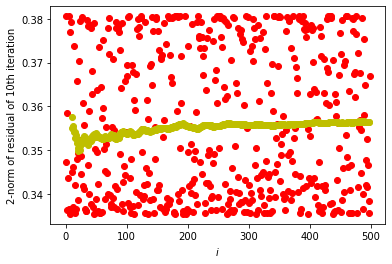

In [12]:
AVG=np.zeros((500,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,500)
for j in range(0,500):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

    
    
pp.plot(count,np.asarray(NonML_Err_List),'or',count[10:-1],AVG[10:-1],'oy')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')

Text(0, 0.5, '2-norm of residual of 10th iteration')

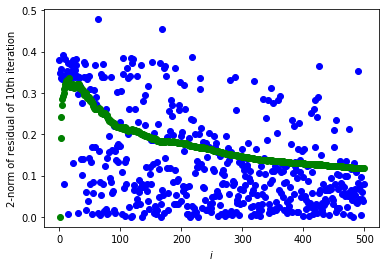

In [13]:
Err_Array_ML=np.asarray(IterErrList10)
AVGML=np.zeros((500,1))

for j in range(0,500):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)
pp.plot(count,np.asarray(Err_Array_ML),'ob',count,AVGML,'og')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')

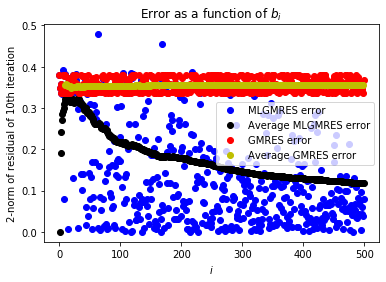

In [11]:
pp.plot(count,np.asarray(Err_Array_ML),'ob',label='MLGMRES error')
pp.plot(count,AVGML,'ok',label='Average MLGMRES error')
pp.plot(count,np.asarray(NonML_Err_List),'or',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'oy',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 10th iteration')
pp.title('Error as a function of $b_i$ ')
pp.legend(loc='best')
pp.savefig('Reduce_Err1.png')

In [ ]:
2020-05-21 20:08:55 [INFO] <ipython-input-6-fa2ed5d53137> 73 - Runtime of Non-decorated version is:
2020-05-21 20:08:55 [INFO] <ipython-input-6-fa2ed5d53137> 74 - 339.86850176709413
2020-05-21 20:08:55 [INFO] <ipython-input-6-fa2ed5d53137> 76 - Runtime of MLGMRES decorator is:
2020-05-21 20:08:55 [INFO] <ipython-input-6-fa2ed5d53137> 77 - 438.634580315731
2020-05-21 20:08:55 [INFO] <ipython-input-6-fa2ed5d53137> 80 - Runtime of training (backprop) is:
2020-05-21 20:08:55 [INFO] <ipython-input-6-fa2ed5d53137> 81 - 139.90492801798973
2020-05-21 20:08:55 [INFO] <ipython-input-6-fa2ed5d53137> 83 - Runtime of forward function is:
2020-05-21 20:08:55 [INFO] <ipython-input-6-fa2ed5d53137> 84 - 0.26097432887763716